In [1]:
import numpy as np
import os
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


# load ndarray

In [2]:
def load_image(path):
    image_list=[]
    for filename in os.listdir(path):
        image=load_img(os.path.join(path,filename))
        image=img_to_array(image) #to ndarray
        image_list.append(image)
    return np.asarray(image_list,'float') 

In [3]:
trainA=load_image('horse2zebra\\trainA')
testA=load_image('horse2zebra\\testA')
trainB=load_image('horse2zebra\\trainB')
testB=load_image('horse2zebra\\testB')
A=np.vstack((trainA,testA))
B=np.vstack((trainB,testB))
print(A.shape,B.shape)

(1187, 256, 256, 3) (1474, 256, 256, 3)


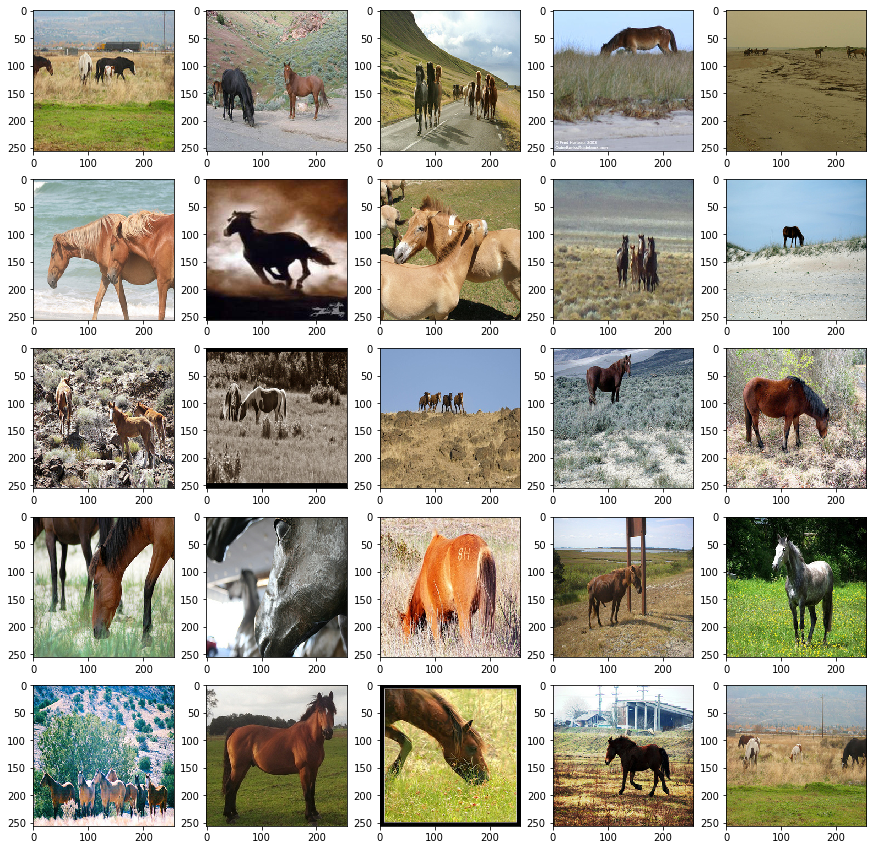

In [4]:
randi=np.random.randint(0,A.shape[0],25)
randA=A[randi]
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(randA[i].astype(int))

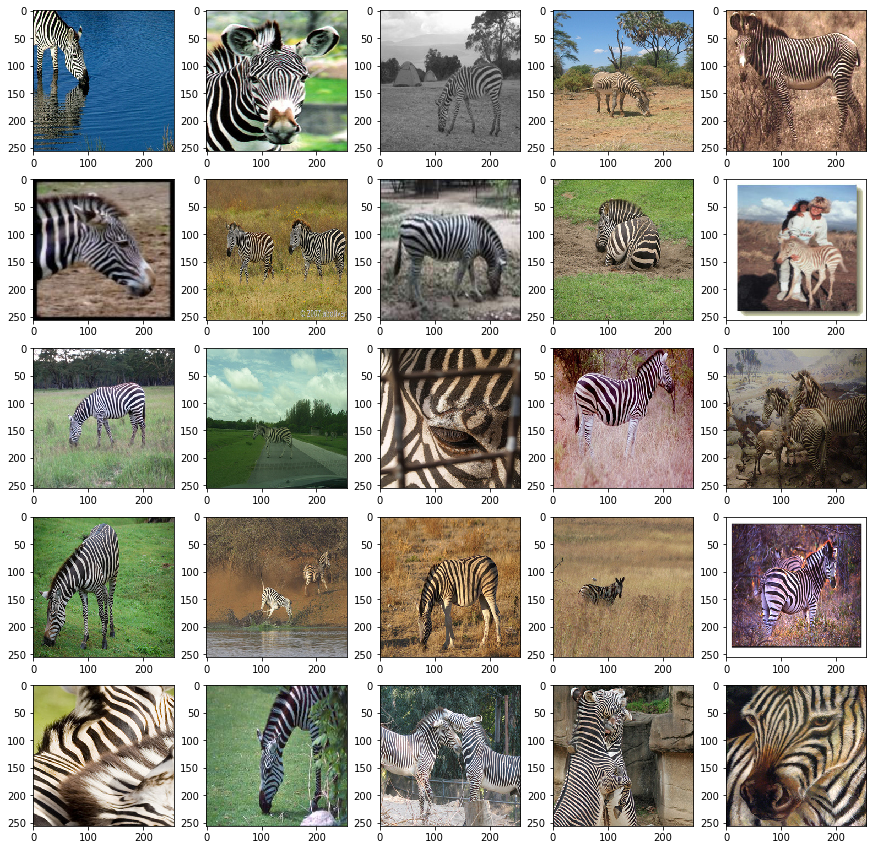

In [5]:
randi=np.random.randint(0,B.shape[0],25)
randB=B[randi]
plt.figure(figsize=(15,15))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(randB[i].astype(int))

# Discriminator NN  
![cycleGAN](https://1.bp.blogspot.com/-cj53ochEvkY/XVPRc4F9A0I/AAAAAAAAEbQ/ERiS_nhQpPEDZOOk8SrxmQ6E2CdZFXMTACLcBGAs/s640/%25E6%2593%25B7%25E5%258F%2596.PNG)  
implement the PatchGAN discriminator  

GAN一般情況下的網絡結構，在一些人的實驗中已經表明對於要求高分辨率、高細節保持的圖像領域中並不適合，有些人根據這一情況設計了PatchGAN的思路。這種GAN的差別主要是在於Discriminator上，一般的GAN是只需要輸出一個true or fasle 的矢量，這是代表對整張圖像的評價；但是PatchGAN輸出的是一個N x N的矩陣，這個N x N的矩陣的每一個元素，比如a(i,j) 只有True or False 這兩個選擇（label 是N x N的矩陣，每一個元素是True 或者False），這樣的結果往往是通過卷積層來達到的，因為逐次疊加的捲積層最終輸出的這個N x N 的矩陣，其中的每一個元素，實際上代表著原圖中的一個比較大的感受野，也就是說對應著原圖中的一個Patch，因此具有這樣結構以及這樣輸出的GAN被稱之為Patch GAN。 

Native keras doesn't go well with tf.keras. 若用tf，則InstanceNormalization會無法執行。  

In [6]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [7]:
def discriminator(image_shape):
    init=keras.initializers.RandomNormal(stddev=0.02) #normal distribution
    x_input=keras.layers.Input(shape=image_shape)
    #to(128*128*64)
    x=keras.layers.Conv2D(64,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x_input)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #to(64*64*128)
    x=keras.layers.Conv2D(128,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #to(32*32*256)
    x=keras.layers.Conv2D(256,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #to(16*16*512)
    x=keras.layers.Conv2D(512,(4,4),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    x=keras.layers.Conv2D(512,(4,4),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.LeakyReLU(alpha=0.2)(x)
    #to(16*16*1),N*N為16*16*1
    x=keras.layers.Conv2D(1,(4,4),padding='same',kernel_initializer=init)(x) 
    
    model=keras.Model(inputs=x_input,outputs=x)
    model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),loss_weights=[0.5])
    return model

In [8]:
model=discriminator(A[0].shape)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      3136      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       131200    
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 128)       256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 64, 64, 128)       0         
_________________________________________________________________
conv

# Generator NN  
![cycleGAN](https://1.bp.blogspot.com/-cj53ochEvkY/XVPRc4F9A0I/AAAAAAAAEbQ/ERiS_nhQpPEDZOOk8SrxmQ6E2CdZFXMTACLcBGAs/s640/%25E6%2593%25B7%25E5%258F%2596.PNG)  

### Residual NN

In [9]:
def residual_block(filters,input_layer):
    init=keras.initializers.RandomNormal(stddev=0.02) #normal distribution
    #1st
    x=keras.layers.Conv2D(filters,(3,3),padding='same',kernel_initializer=init)(input_layer)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #2nd
    x=keras.layers.Conv2D(filters,(3,3),padding='same',kernel_initializer=init)(input_layer)
    x=InstanceNormalization(axis=-1)(x)
    
    x=keras.layers.Concatenate()([x,input_layer])
    return x

![generator](https://hardikbansal.github.io/CycleGANBlog/images/Generator.jpg)  
First downsampling then upsmapling,interpreting the encoding with a number of ResNet layers  

In [10]:
def generator(image_shape,residual_num=1):
    init=keras.initializers.RandomNormal(stddev=0.02)
    x_input=keras.layers.Input(shape=image_shape)
    
    #downsampling
    #to(256*256*64)
    x=keras.layers.Conv2D(64,(7,7),padding='same',kernel_initializer=init)(x_input)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #to(128*128*128)
    x=keras.layers.Conv2D(128,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #to(64*64*256)
    x=keras.layers.Conv2D(256,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    
    for i in range(residual_num):
        x=residual_block(256,x)
        
    #upsampling
    #to(128*128*128)
    x=keras.layers.Conv2DTranspose(128,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #to(256*256*64)
    x=keras.layers.Conv2DTranspose(64,(3,3),strides=(2,2),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('relu')(x)
    #to(256*256*3)
    x=keras.layers.Conv2D(3,(7,7),padding='same',kernel_initializer=init)(x)
    x=InstanceNormalization(axis=-1)(x)
    x=keras.layers.Activation('tanh')(x)
    
    model=keras.Model(inputs=x_input,outputs=x)
    
    return model

In [11]:
model=generator(A[0].shape)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 256, 256, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
instance_normalization_5 (Insta (None, 256, 256, 64) 128         conv2d_7[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 64) 0           instance_normalization_5[0][0]   
__________________________________________________________________________________________________
conv2d_8 (

# composite NN (目的是為了要訓練g_model)
假設我們要訓練一個A->B的generator  
updated via the weighted sum of four loss function:  
* __Adversarial Loss__: Domain-A -> Generator-B -> Domain-B -> Discriminator-B -> \[real/fake\]
* __Identity Loss__: Domain-B -> Generator-B -> Domain-B
* __Forward Cycle Loss__: Domain-A -> Generator-B -> Domain-B -> Generator-A -> Domain-A
* __Backward Cycle Loss__: Domain-B -> Generator-A -> Domain-A -> Generator-B -> Domain-B

input is Domain-A & Domain-B  

In [12]:
#Domain A->Domain B ; g_modelB:image to Domain B
def composite(g_modelAtoB,g_modelBtoA,d_model,input_shape): 
    g_modelAtoB.trainable=True 
    g_modelBtoA.trainable=False
    d_model.trainable=False
    
    A_input=keras.layers.Input(shape=input_shape)
    B_input=keras.layers.Input(shape=input_shape)
    #adversarial loss
    adversary_output=g_modelAtoB(A_input)
    adversary_output=d_model(adversary_output)
    #identity loss
    identity_output=g_modelAtoB(B_input)
    #forward cycle loss
    forward_output=g_modelAtoB(A_input)
    forward_output=g_modelBtoA(forward_output)
    #backward cycle loss
    backward_output=g_modelBtoA(B_input)
    backward_output=g_modelAtoB(backward_output)
    
    model=keras.Model(inputs=[A_input,B_input],outputs=[adversary_output,identity_output,forward_output,backward_output])
    model.compile(loss=['mse','mae','mae','mae'],optimizer=keras.optimizers.Adam(lr=0.0002, beta_1=0.5),loss_weights=[1,5,10,10])
    return model

# Image_Generator(for Discriminator)

In [13]:
def real_image_generator(dataset,num,patch_shape):
    randi=np.random.randint(0,dataset.shape[0],num)
    x=dataset[randi]
    y=np.ones((num,)+patch_shape)
    return x,y

In [14]:
#圖片生圖片
def fake_image_generator(g_model,images,patch_shape): 
    x=g_model.predict(images)
    y=np.zeros((images.shape[0],)+patch_shape)
    return x,y

# Training

In [15]:
#會使用舊的image
def update_fake_image(pool,images,pool_size=50):
    select=[]
    for image in images:
        if len(pool)<pool_size:
            pool.append(image)
            select.append(image)
        elif np.random.random()<0.5:
            select.append(image)
        else: #use old
            randi=np.random.randint(0,pool_size)
            select.append(pool[randi])
            pool[randi]=image
    return np.asarray(select,'float')

要train 4個NN:  
![cycleGAN](https://i.imgur.com/OH7Tvpy.png)  

In [16]:
def fit(g_modelAtoB,g_modelBtoA,d_modelA,d_modelB,c_modelAtoB,c_modelBtoA,epochs=100,batch_size=1):
    batchs=A.shape[0]//batch_size
    poolA,poolB=[],[]
    patch_shape=d_modelA.output_shape[1:]
    for epoch in range(1,epochs+1):
        for batch in range(1,batchs+1):
            #domain images
            realA_x,realA_y=real_image_generator(A,batch_size,patch_shape)
            realB_x,realB_y=real_image_generator(B,batch_size,patch_shape)
            fakeA_x,fakeA_y=fake_image_generator(g_modelBtoA,realB_x,patch_shape)
            fakeB_x,fakeB_y=fake_image_generator(g_modelAtoB,realA_x,patch_shape)
            fakeA_x=update_fake_image(poolA,fakeA_x)
            fakeB_x=update_fake_image(poolB,fakeB_x)
            #update generator_B->A
            loss_g_BA,_,_,_,_=c_modelBtoA.train_on_batch(x=[realB_x,realA_x],y=[realA_y,realA_x,realB_x,realA_x])
            #update discriminator_A
            loss_d1_A=d_modelA.train_on_batch(x=realA_x,y=realA_y)
            loss_d2_A=d_modelA.train_on_batch(x=fakeA_x,y=fakeA_y)
            #update generator_A->B
            loss_g_AB,_,_,_,_=c_modelAtoB.train_on_batch(x=[realA_x,realB_x],y=[realB_y,realB_x,realA_x,realB_x])
            #update discriminator_B
            loss_d1_B=d_modelB.train_on_batch(x=realB_x,y=realB_y)
            loss_d2_B=d_modelB.train_on_batch(x=fakeB_x,y=fakeB_y)
            print('epoch{} {}/{} dA[{:.2f} {:.2f}] dB[{:.2f} {:.2f}] gA[{:.2f}] gB[{:.2f}]'.format(epoch,batch,batchs,loss_d1_A,loss_d2_A,loss_d1_B,loss_d2_B,loss_g_BA,loss_g_AB))
        if epoch%5==0:
            summarize(epoch,g_modelAtoB,g_modelBtoA)

In [17]:
#save img,save model
def summarize(epoch,g_modelAtoB,g_modelBtoA):
    in_A,_=real_image_generator(A,5,(0,))
    out_B,_=fake_image_generator(g_modelAtoB,in_A,(0,))
    in_B,_=real_image_generator(B,5,(0,))
    out_A,_=fake_image_generator(g_modelBtoA,in_B,(0,))
    in_A=(in_A+1)/2
    out_B=(out_B+1)/2
    in_B=(in_B+1)/2
    out_A=(out_A+1)/2
    
    plt.figure(figsize=(15,12))
    #Domain A-> Domain B
    for i in range(5):
        plt.subplot(4,5,i+1)
        plt.imshow(in_A[i])
        plt.axis('off')
        plt.title('real A')
        plt.subplot(4,5,i+1+5)
        plt.imshow(out_B[i])
        plt.axis('off')
        plt.title('fake B')
    #B->A
    for i in range(5):
        plt.subplot(4,5,10+i+1)
        plt.imshow(in_B[i])
        plt.axis('off')
        plt.title('real B')
        plt.subplot(4,5,10+i+1+5)
        plt.imshow(out_A[i])
        plt.axis('off')
        plt.title('fake A')
    plt.savefig('cycleGAN horse-zebra\\epoch{}.png'.format(epoch))
    plt.close()
    #save model
    g_modelAtoB.save('cycleGAN horse-zebra\\generator AtoB epoch{}.h5'.format(epoch))
    g_modelBtoA.save('cycleGAN horse-zebra\\generator BtoA epoch{}.h5'.format(epoch))

# Start GAN

### load A&B from [0,255] to [-1,1]

In [18]:
A=(A-127.5)/127.5
B=(B-127.5)/127.5

### train

In [19]:
g_modelAtoB=generator(A[0].shape)
g_modelBtoA=generator(B[0].shape)
d_modelA=discriminator(A[0].shape)
d_modelB=discriminator(B[0].shape)
c_modelAtoB=composite(g_modelAtoB,g_modelBtoA,d_modelB,A[0].shape)
c_modelBtoA=composite(g_modelBtoA,g_modelAtoB,d_modelA,B[0].shape)

fit(g_modelAtoB,g_modelBtoA,d_modelA,d_modelB,c_modelAtoB,c_modelBtoA,epochs=100)

Instructions for updating:
Use tf.cast instead.


C:\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch1 1/1187 dA[1.11 1.26] dB[1.19 1.04] gA[17.83] gB[17.08]
epoch1 2/1187 dA[9.01 3.04] dB[1.76 1.97] gA[21.08] gB[21.05]
epoch1 3/1187 dA[9.29 0.83] dB[10.34 2.78] gA[17.40] gB[22.71]
epoch1 4/1187 dA[2.09 1.09] dB[4.20 2.84] gA[17.97] gB[18.77]
epoch1 5/1187 dA[1.12 1.22] dB[1.31 2.15] gA[18.33] gB[18.43]
epoch1 6/1187 dA[1.61 2.43] dB[1.25 3.31] gA[17.73] gB[17.76]
epoch1 7/1187 dA[2.22 1.58] dB[0.85 1.92] gA[15.78] gB[15.80]
epoch1 8/1187 dA[2.91 0.93] dB[0.92 1.41] gA[16.11] gB[16.73]
epoch1 9/1187 dA[1.45 0.55] dB[0.84 1.02] gA[14.89] gB[15.73]
epoch1 10/1187 dA[0.59 0.53] dB[0.76 1.10] gA[14.24] gB[14.77]
epoch1 11/1187 dA[1.17 0.55] dB[0.73 1.23] gA[13.85] gB[14.58]
epoch1 12/1187 dA[0.85 0.63] dB[0.88 0.83] gA[15.10] gB[15.05]
epoch1 13/1187 dA[0.63 0.49] dB[0.71 0.62] gA[13.84] gB[13.55]
epoch1 14/1187 dA[0.54 0.69] dB[0.48 0.66] gA[13.39] gB[12.35]
epoch1 15/1187 dA[0.61 0.74] dB[0.58 0.47] gA[11.41] gB[11.09]
epoch1 16/1187 dA[0.58 0.67] dB[0.60 0.58] gA[12.15] gB[11.85]


epoch1 134/1187 dA[0.16 0.07] dB[0.32 0.11] gA[8.43] gB[10.02]
epoch1 135/1187 dA[0.28 0.15] dB[0.18 0.18] gA[6.38] gB[6.40]
epoch1 136/1187 dA[0.18 0.17] dB[0.19 0.18] gA[5.80] gB[5.72]
epoch1 137/1187 dA[0.10 0.19] dB[0.11 0.11] gA[7.97] gB[6.98]
epoch1 138/1187 dA[0.13 0.10] dB[0.16 0.18] gA[8.82] gB[8.18]
epoch1 139/1187 dA[0.17 0.25] dB[0.44 0.23] gA[6.37] gB[6.53]
epoch1 140/1187 dA[0.14 0.15] dB[0.13 0.13] gA[6.23] gB[6.60]
epoch1 141/1187 dA[0.17 0.17] dB[0.19 0.24] gA[6.45] gB[6.15]
epoch1 142/1187 dA[0.15 0.13] dB[0.18 0.11] gA[6.44] gB[6.62]
epoch1 143/1187 dA[0.15 0.18] dB[0.17 0.06] gA[5.46] gB[6.00]
epoch1 144/1187 dA[0.26 0.18] dB[0.16 0.34] gA[6.91] gB[6.35]
epoch1 145/1187 dA[0.13 0.14] dB[0.12 0.17] gA[6.93] gB[6.47]
epoch1 146/1187 dA[0.12 0.19] dB[0.24 0.18] gA[6.36] gB[7.07]
epoch1 147/1187 dA[0.15 0.09] dB[0.21 0.16] gA[8.01] gB[9.16]
epoch1 148/1187 dA[0.07 0.13] dB[0.11 0.06] gA[6.21] gB[7.38]
epoch1 149/1187 dA[0.07 0.22] dB[0.21 0.33] gA[8.12] gB[7.46]
epoch1 

epoch1 267/1187 dA[0.25 0.18] dB[0.15 0.22] gA[6.07] gB[5.22]
epoch1 268/1187 dA[0.13 0.04] dB[0.15 0.13] gA[7.89] gB[7.24]
epoch1 269/1187 dA[0.21 0.14] dB[0.28 0.18] gA[6.79] gB[6.57]
epoch1 270/1187 dA[0.14 0.10] dB[0.11 0.19] gA[6.08] gB[5.43]
epoch1 271/1187 dA[0.11 0.20] dB[0.12 0.11] gA[6.11] gB[6.07]
epoch1 272/1187 dA[0.15 0.16] dB[0.15 0.11] gA[6.59] gB[6.24]
epoch1 273/1187 dA[0.14 0.20] dB[0.25 0.23] gA[6.42] gB[5.90]
epoch1 274/1187 dA[0.04 0.08] dB[0.09 0.22] gA[7.57] gB[8.13]
epoch1 275/1187 dA[0.08 0.06] dB[0.16 0.04] gA[9.69] gB[9.23]
epoch1 276/1187 dA[0.03 0.07] dB[0.32 0.21] gA[5.75] gB[5.63]
epoch1 277/1187 dA[0.08 0.08] dB[0.09 0.19] gA[6.41] gB[6.15]
epoch1 278/1187 dA[0.10 0.05] dB[0.08 0.04] gA[8.78] gB[8.85]
epoch1 279/1187 dA[0.07 0.13] dB[0.20 0.11] gA[7.52] gB[7.85]
epoch1 280/1187 dA[0.15 0.06] dB[0.07 0.05] gA[8.09] gB[8.73]
epoch1 281/1187 dA[0.06 0.04] dB[0.10 0.09] gA[9.43] gB[10.65]
epoch1 282/1187 dA[0.04 0.05] dB[0.10 0.15] gA[6.84] gB[6.63]
epoch1 

epoch1 400/1187 dA[0.24 0.14] dB[0.24 0.20] gA[6.95] gB[5.88]
epoch1 401/1187 dA[0.12 0.04] dB[0.22 0.26] gA[5.41] gB[5.17]
epoch1 402/1187 dA[0.12 0.45] dB[0.18 0.30] gA[6.02] gB[5.22]
epoch1 403/1187 dA[0.18 0.05] dB[0.21 0.04] gA[7.38] gB[6.44]
epoch1 404/1187 dA[0.24 0.33] dB[0.15 0.25] gA[7.42] gB[6.49]
epoch1 405/1187 dA[0.06 0.09] dB[0.25 0.39] gA[6.27] gB[6.00]
epoch1 406/1187 dA[0.10 0.22] dB[0.23 0.07] gA[7.80] gB[7.85]
epoch1 407/1187 dA[0.19 0.05] dB[0.27 0.23] gA[9.18] gB[7.86]
epoch1 408/1187 dA[0.02 0.04] dB[0.05 0.17] gA[6.36] gB[5.96]
epoch1 409/1187 dA[0.04 0.02] dB[0.44 0.12] gA[6.46] gB[5.83]
epoch1 410/1187 dA[0.07 0.07] dB[0.11 0.13] gA[4.91] gB[4.66]
epoch1 411/1187 dA[0.09 0.07] dB[0.07 0.08] gA[7.41] gB[8.15]
epoch1 412/1187 dA[0.10 0.39] dB[0.14 0.15] gA[6.09] gB[6.41]
epoch1 413/1187 dA[0.28 0.10] dB[0.07 0.07] gA[5.56] gB[5.03]
epoch1 414/1187 dA[0.22 0.11] dB[0.15 0.05] gA[6.67] gB[6.87]
epoch1 415/1187 dA[0.08 0.41] dB[0.13 0.11] gA[5.98] gB[6.63]
epoch1 4

epoch1 533/1187 dA[0.24 0.15] dB[0.20 0.23] gA[7.18] gB[6.63]
epoch1 534/1187 dA[0.20 0.15] dB[0.07 0.10] gA[9.43] gB[7.34]
epoch1 535/1187 dA[0.14 0.12] dB[0.13 0.06] gA[5.92] gB[5.70]
epoch1 536/1187 dA[0.10 0.08] dB[0.04 0.09] gA[6.16] gB[6.74]
epoch1 537/1187 dA[0.14 0.15] dB[0.06 0.04] gA[7.12] gB[7.10]
epoch1 538/1187 dA[0.08 0.16] dB[0.10 0.18] gA[6.92] gB[6.32]
epoch1 539/1187 dA[0.05 0.11] dB[0.12 0.01] gA[11.41] gB[12.88]
epoch1 540/1187 dA[0.09 0.09] dB[0.11 0.12] gA[5.66] gB[5.45]
epoch1 541/1187 dA[0.10 0.06] dB[0.04 0.09] gA[8.77] gB[7.86]
epoch1 542/1187 dA[0.32 0.12] dB[0.32 0.09] gA[4.83] gB[4.71]
epoch1 543/1187 dA[0.06 0.27] dB[0.27 0.36] gA[5.57] gB[5.78]
epoch1 544/1187 dA[0.21 0.17] dB[0.05 0.12] gA[8.98] gB[7.12]
epoch1 545/1187 dA[0.33 0.09] dB[0.04 0.04] gA[7.19] gB[8.45]
epoch1 546/1187 dA[0.11 0.14] dB[0.42 0.09] gA[5.00] gB[5.70]
epoch1 547/1187 dA[0.11 0.04] dB[0.06 0.06] gA[8.73] gB[8.34]
epoch1 548/1187 dA[0.05 0.15] dB[0.17 0.12] gA[4.85] gB[5.50]
epoch1

epoch1 666/1187 dA[0.37 0.06] dB[0.47 0.06] gA[6.06] gB[5.30]
epoch1 667/1187 dA[0.04 0.07] dB[0.07 0.13] gA[7.31] gB[7.67]
epoch1 668/1187 dA[0.13 0.07] dB[0.08 0.04] gA[6.29] gB[5.29]
epoch1 669/1187 dA[0.06 0.24] dB[0.02 0.03] gA[6.81] gB[6.02]
epoch1 670/1187 dA[0.06 0.16] dB[0.03 0.03] gA[6.65] gB[6.15]
epoch1 671/1187 dA[0.13 0.17] dB[0.36 0.10] gA[7.05] gB[6.06]
epoch1 672/1187 dA[0.13 0.04] dB[0.03 0.27] gA[7.43] gB[6.33]
epoch1 673/1187 dA[0.04 0.12] dB[0.23 0.06] gA[5.46] gB[4.94]
epoch1 674/1187 dA[0.18 0.05] dB[0.16 0.12] gA[6.02] gB[6.69]
epoch1 675/1187 dA[0.05 0.17] dB[0.14 0.50] gA[7.81] gB[5.89]
epoch1 676/1187 dA[0.10 0.13] dB[0.36 0.04] gA[5.86] gB[5.65]
epoch1 677/1187 dA[0.08 0.29] dB[0.09 0.29] gA[6.25] gB[6.80]
epoch1 678/1187 dA[0.28 0.03] dB[0.24 0.07] gA[7.09] gB[7.07]
epoch1 679/1187 dA[0.04 0.02] dB[0.09 0.11] gA[4.88] gB[4.07]
epoch1 680/1187 dA[0.06 0.30] dB[0.07 0.03] gA[10.23] gB[9.13]
epoch1 681/1187 dA[0.24 0.11] dB[0.05 0.05] gA[6.50] gB[6.40]
epoch1 

epoch1 799/1187 dA[0.12 0.18] dB[0.03 0.12] gA[5.14] gB[4.09]
epoch1 800/1187 dA[0.11 0.23] dB[0.22 0.19] gA[8.57] gB[7.71]
epoch1 801/1187 dA[0.20 0.12] dB[0.03 0.04] gA[6.19] gB[4.78]
epoch1 802/1187 dA[0.23 0.19] dB[0.29 0.11] gA[6.62] gB[6.96]
epoch1 803/1187 dA[0.04 0.12] dB[0.18 0.32] gA[6.50] gB[5.31]
epoch1 804/1187 dA[0.29 0.14] dB[0.06 0.09] gA[5.94] gB[5.33]
epoch1 805/1187 dA[0.06 0.11] dB[0.06 0.15] gA[8.47] gB[7.80]
epoch1 806/1187 dA[0.02 0.14] dB[0.18 0.16] gA[6.50] gB[6.09]
epoch1 807/1187 dA[0.17 0.07] dB[0.32 0.09] gA[6.51] gB[5.25]
epoch1 808/1187 dA[0.22 0.09] dB[0.05 0.07] gA[5.70] gB[5.76]
epoch1 809/1187 dA[0.06 0.38] dB[0.16 0.05] gA[4.80] gB[5.32]
epoch1 810/1187 dA[0.10 0.06] dB[0.26 0.14] gA[5.54] gB[5.30]
epoch1 811/1187 dA[0.11 0.24] dB[0.15 0.03] gA[7.51] gB[7.65]
epoch1 812/1187 dA[0.14 0.04] dB[0.39 0.07] gA[8.78] gB[8.18]
epoch1 813/1187 dA[0.06 0.11] dB[0.10 0.19] gA[5.34] gB[5.18]
epoch1 814/1187 dA[0.08 0.05] dB[0.15 0.11] gA[10.90] gB[8.62]
epoch1 

epoch1 932/1187 dA[0.13 0.04] dB[0.20 0.24] gA[8.64] gB[6.39]
epoch1 933/1187 dA[0.39 0.16] dB[0.02 0.03] gA[7.40] gB[8.12]
epoch1 934/1187 dA[0.04 0.14] dB[0.04 0.03] gA[4.69] gB[5.19]
epoch1 935/1187 dA[0.23 0.16] dB[0.07 0.05] gA[6.03] gB[6.33]
epoch1 936/1187 dA[0.03 0.02] dB[0.05 0.02] gA[7.10] gB[6.77]
epoch1 937/1187 dA[0.14 0.02] dB[0.02 0.07] gA[5.42] gB[5.29]
epoch1 938/1187 dA[0.08 0.48] dB[0.27 0.10] gA[5.11] gB[5.56]
epoch1 939/1187 dA[0.20 0.04] dB[0.05 0.07] gA[6.20] gB[5.50]
epoch1 940/1187 dA[0.13 0.36] dB[0.22 0.08] gA[6.47] gB[6.89]
epoch1 941/1187 dA[0.13 0.08] dB[0.20 0.23] gA[4.51] gB[4.38]
epoch1 942/1187 dA[0.35 0.27] dB[0.09 0.14] gA[6.52] gB[6.83]
epoch1 943/1187 dA[0.22 0.06] dB[0.02 0.05] gA[5.72] gB[4.88]
epoch1 944/1187 dA[0.10 0.13] dB[0.07 0.03] gA[5.15] gB[6.15]
epoch1 945/1187 dA[0.07 0.03] dB[0.27 0.08] gA[6.38] gB[6.96]
epoch1 946/1187 dA[0.13 0.30] dB[0.24 0.25] gA[5.59] gB[4.88]
epoch1 947/1187 dA[0.18 0.04] dB[0.07 0.03] gA[8.16] gB[8.41]
epoch1 9

epoch1 1064/1187 dA[0.18 0.08] dB[0.09 0.21] gA[5.77] gB[6.07]
epoch1 1065/1187 dA[0.04 0.03] dB[0.08 0.12] gA[6.96] gB[6.29]
epoch1 1066/1187 dA[0.11 0.12] dB[0.27 0.06] gA[3.92] gB[4.65]
epoch1 1067/1187 dA[0.21 0.14] dB[0.04 0.30] gA[7.30] gB[6.88]
epoch1 1068/1187 dA[0.02 0.14] dB[0.40 0.03] gA[4.01] gB[4.69]
epoch1 1069/1187 dA[0.02 0.02] dB[0.24 0.30] gA[5.93] gB[4.61]
epoch1 1070/1187 dA[0.03 0.02] dB[0.03 0.09] gA[6.73] gB[5.55]
epoch1 1071/1187 dA[0.27 0.57] dB[0.27 0.13] gA[6.91] gB[6.00]
epoch1 1072/1187 dA[0.05 0.05] dB[0.03 0.09] gA[4.33] gB[4.26]
epoch1 1073/1187 dA[0.40 0.09] dB[0.04 0.05] gA[5.75] gB[5.29]
epoch1 1074/1187 dA[0.03 0.20] dB[0.09 0.03] gA[7.20] gB[7.38]
epoch1 1075/1187 dA[0.03 0.06] dB[0.18 0.17] gA[5.82] gB[5.83]
epoch1 1076/1187 dA[0.08 0.05] dB[0.01 0.03] gA[5.18] gB[5.45]
epoch1 1077/1187 dA[0.09 0.25] dB[0.18 0.05] gA[5.95] gB[6.00]
epoch1 1078/1187 dA[0.14 0.02] dB[0.04 0.07] gA[6.05] gB[4.89]
epoch1 1079/1187 dA[0.02 0.05] dB[0.30 0.11] gA[6.56] g

epoch2 8/1187 dA[0.02 0.20] dB[0.17 0.14] gA[4.84] gB[5.21]
epoch2 9/1187 dA[0.64 0.05] dB[0.07 0.15] gA[5.85] gB[5.33]
epoch2 10/1187 dA[0.12 0.42] dB[0.23 0.14] gA[3.73] gB[4.16]
epoch2 11/1187 dA[0.05 0.04] dB[0.03 0.08] gA[5.31] gB[4.62]
epoch2 12/1187 dA[0.48 0.06] dB[0.13 0.07] gA[5.14] gB[4.41]
epoch2 13/1187 dA[0.03 0.24] dB[0.02 0.05] gA[5.00] gB[5.16]
epoch2 14/1187 dA[0.04 0.04] dB[0.13 0.09] gA[4.31] gB[4.05]
epoch2 15/1187 dA[0.14 0.07] dB[0.09 0.15] gA[3.98] gB[4.07]
epoch2 16/1187 dA[0.33 0.18] dB[0.37 0.13] gA[5.02] gB[5.05]
epoch2 17/1187 dA[0.01 0.13] dB[0.23 0.08] gA[3.80] gB[3.93]
epoch2 18/1187 dA[0.02 0.06] dB[0.05 0.17] gA[4.97] gB[4.81]
epoch2 19/1187 dA[0.03 0.05] dB[0.33 0.02] gA[4.58] gB[4.39]
epoch2 20/1187 dA[0.20 0.15] dB[0.09 0.24] gA[6.96] gB[6.49]
epoch2 21/1187 dA[0.06 0.07] dB[0.10 0.21] gA[3.84] gB[3.60]
epoch2 22/1187 dA[0.04 0.24] dB[0.28 0.04] gA[6.02] gB[6.24]
epoch2 23/1187 dA[0.12 0.03] dB[0.06 0.09] gA[11.52] gB[8.98]
epoch2 24/1187 dA[0.50 0.

epoch2 142/1187 dA[0.08 0.02] dB[0.03 0.02] gA[7.44] gB[6.54]
epoch2 143/1187 dA[0.09 0.12] dB[0.08 0.05] gA[7.77] gB[6.56]
epoch2 144/1187 dA[0.04 0.03] dB[0.04 0.22] gA[8.01] gB[6.75]
epoch2 145/1187 dA[0.08 0.06] dB[0.33 0.14] gA[5.01] gB[5.17]
epoch2 146/1187 dA[0.24 0.08] dB[0.03 0.07] gA[10.07] gB[8.23]
epoch2 147/1187 dA[0.18 0.18] dB[0.36 0.02] gA[4.90] gB[5.17]
epoch2 148/1187 dA[0.03 0.20] dB[0.07 0.08] gA[6.57] gB[7.55]
epoch2 149/1187 dA[0.04 0.04] dB[0.06 0.17] gA[7.28] gB[4.68]
epoch2 150/1187 dA[0.26 0.05] dB[0.19 0.05] gA[4.09] gB[4.60]
epoch2 151/1187 dA[0.01 0.12] dB[0.11 0.21] gA[4.55] gB[4.54]
epoch2 152/1187 dA[0.02 0.03] dB[0.15 0.05] gA[10.28] gB[8.00]
epoch2 153/1187 dA[0.07 0.07] dB[0.24 0.01] gA[9.44] gB[8.56]
epoch2 154/1187 dA[0.09 0.05] dB[0.09 0.07] gA[4.38] gB[4.59]
epoch2 155/1187 dA[0.04 0.20] dB[0.18 0.21] gA[3.54] gB[3.89]
epoch2 156/1187 dA[0.04 0.06] dB[0.05 0.02] gA[6.66] gB[6.31]
epoch2 157/1187 dA[0.08 0.17] dB[0.16 0.05] gA[5.78] gB[5.24]
epoch2

epoch2 275/1187 dA[0.22 0.36] dB[0.28 0.05] gA[3.21] gB[3.82]
epoch2 276/1187 dA[0.25 0.10] dB[0.08 0.12] gA[5.44] gB[4.95]
epoch2 277/1187 dA[0.22 0.06] dB[0.06 0.23] gA[5.04] gB[4.22]
epoch2 278/1187 dA[0.05 0.13] dB[0.05 0.02] gA[7.08] gB[7.47]
epoch2 279/1187 dA[0.18 0.06] dB[0.06 0.12] gA[4.82] gB[4.41]
epoch2 280/1187 dA[0.05 0.10] dB[0.06 0.05] gA[3.71] gB[4.39]
epoch2 281/1187 dA[0.01 0.02] dB[0.10 0.04] gA[7.18] gB[6.86]
epoch2 282/1187 dA[0.01 0.02] dB[0.01 0.08] gA[4.37] gB[3.91]
epoch2 283/1187 dA[0.03 0.10] dB[0.11 0.05] gA[4.68] gB[4.65]
epoch2 284/1187 dA[0.12 0.04] dB[0.30 0.13] gA[4.51] gB[4.94]
epoch2 285/1187 dA[0.01 0.03] dB[0.04 0.14] gA[3.41] gB[3.58]
epoch2 286/1187 dA[0.12 0.04] dB[0.05 0.06] gA[7.45] gB[5.95]
epoch2 287/1187 dA[0.01 0.02] dB[0.26 0.07] gA[4.71] gB[3.68]
epoch2 288/1187 dA[0.06 0.10] dB[0.03 0.09] gA[4.92] gB[4.66]
epoch2 289/1187 dA[0.11 0.17] dB[0.29 0.07] gA[6.16] gB[7.17]
epoch2 290/1187 dA[0.08 0.06] dB[0.12 0.08] gA[6.01] gB[6.94]
epoch2 2

epoch2 408/1187 dA[0.02 0.25] dB[0.15 0.02] gA[4.87] gB[4.93]
epoch2 409/1187 dA[0.14 0.02] dB[0.14 0.08] gA[6.31] gB[5.54]
epoch2 410/1187 dA[0.01 0.23] dB[0.13 0.39] gA[5.63] gB[4.49]
epoch2 411/1187 dA[0.18 0.01] dB[0.04 0.20] gA[6.02] gB[4.69]
epoch2 412/1187 dA[0.02 0.07] dB[0.24 0.01] gA[8.62] gB[7.09]
epoch2 413/1187 dA[0.20 0.02] dB[0.30 0.18] gA[6.50] gB[6.45]
epoch2 414/1187 dA[0.17 0.25] dB[0.03 0.18] gA[4.80] gB[4.53]
epoch2 415/1187 dA[0.17 0.42] dB[0.03 0.04] gA[5.98] gB[7.24]
epoch2 416/1187 dA[0.19 0.06] dB[0.20 0.03] gA[5.08] gB[5.52]
epoch2 417/1187 dA[0.15 0.04] dB[0.04 0.09] gA[4.79] gB[4.35]
epoch2 418/1187 dA[0.23 0.10] dB[0.10 0.07] gA[4.12] gB[3.95]
epoch2 419/1187 dA[0.04 0.23] dB[0.02 0.04] gA[4.97] gB[6.46]
epoch2 420/1187 dA[0.15 0.02] dB[0.12 0.02] gA[4.72] gB[5.22]
epoch2 421/1187 dA[0.17 0.38] dB[0.33 0.41] gA[3.71] gB[4.10]
epoch2 422/1187 dA[0.11 0.09] dB[0.05 0.11] gA[5.19] gB[4.47]
epoch2 423/1187 dA[0.18 0.02] dB[0.13 0.04] gA[7.38] gB[7.11]
epoch2 4

epoch2 541/1187 dA[0.03 0.03] dB[0.30 0.04] gA[4.46] gB[4.52]
epoch2 542/1187 dA[0.06 0.03] dB[0.02 0.24] gA[7.88] gB[7.85]
epoch2 543/1187 dA[0.01 0.02] dB[0.23 0.04] gA[5.42] gB[5.05]
epoch2 544/1187 dA[0.09 0.13] dB[0.07 0.17] gA[6.64] gB[6.24]
epoch2 545/1187 dA[0.02 0.11] dB[0.02 0.07] gA[6.77] gB[6.74]
epoch2 546/1187 dA[0.14 0.02] dB[0.38 0.05] gA[4.49] gB[3.78]
epoch2 547/1187 dA[0.17 0.09] dB[0.02 0.06] gA[4.44] gB[4.17]
epoch2 548/1187 dA[0.03 0.02] dB[0.37 0.11] gA[4.50] gB[3.84]
epoch2 549/1187 dA[0.27 0.10] dB[0.24 0.27] gA[4.99] gB[3.74]
epoch2 550/1187 dA[0.06 0.19] dB[0.05 0.18] gA[5.10] gB[4.72]
epoch2 551/1187 dA[0.12 0.02] dB[0.33 0.09] gA[6.06] gB[5.46]
epoch2 552/1187 dA[0.34 0.15] dB[0.10 0.30] gA[3.90] gB[3.52]
epoch2 553/1187 dA[0.07 0.19] dB[0.07 0.10] gA[4.57] gB[4.14]
epoch2 554/1187 dA[0.05 0.01] dB[0.14 0.02] gA[5.49] gB[4.74]
epoch2 555/1187 dA[0.02 0.10] dB[0.06 0.20] gA[5.96] gB[4.97]
epoch2 556/1187 dA[0.24 0.03] dB[0.01 0.01] gA[5.28] gB[4.71]
epoch2 5

epoch2 674/1187 dA[0.01 0.02] dB[0.02 0.05] gA[7.03] gB[7.80]
epoch2 675/1187 dA[0.35 0.09] dB[0.31 0.10] gA[4.35] gB[4.19]
epoch2 676/1187 dA[0.11 0.14] dB[0.09 0.04] gA[5.02] gB[4.97]
epoch2 677/1187 dA[0.21 0.06] dB[0.02 0.03] gA[5.67] gB[6.44]
epoch2 678/1187 dA[0.07 0.14] dB[0.01 0.26] gA[8.76] gB[9.12]
epoch2 679/1187 dA[0.03 0.14] dB[0.39 0.01] gA[4.63] gB[4.80]
epoch2 680/1187 dA[0.03 0.05] dB[0.04 0.13] gA[4.94] gB[5.49]
epoch2 681/1187 dA[0.02 0.29] dB[0.30 0.09] gA[4.63] gB[5.69]
epoch2 682/1187 dA[0.12 0.01] dB[0.12 0.20] gA[5.71] gB[4.35]
epoch2 683/1187 dA[0.19 0.02] dB[0.04 0.24] gA[5.52] gB[4.27]
epoch2 684/1187 dA[0.01 0.03] dB[0.09 0.02] gA[6.14] gB[6.38]
epoch2 685/1187 dA[0.11 0.06] dB[0.04 0.04] gA[5.26] gB[5.65]
epoch2 686/1187 dA[0.02 0.08] dB[0.29 0.03] gA[4.86] gB[5.06]
epoch2 687/1187 dA[0.11 0.02] dB[0.25 0.33] gA[6.66] gB[6.05]
epoch2 688/1187 dA[0.15 0.04] dB[0.02 0.04] gA[4.62] gB[3.90]
epoch2 689/1187 dA[0.04 0.16] dB[0.07 0.05] gA[5.49] gB[5.17]
epoch2 6

epoch2 807/1187 dA[0.47 0.10] dB[0.06 0.02] gA[4.93] gB[5.48]
epoch2 808/1187 dA[0.05 0.07] dB[0.42 0.09] gA[3.39] gB[4.32]
epoch2 809/1187 dA[0.10 0.58] dB[0.14 0.26] gA[3.41] gB[3.85]
epoch2 810/1187 dA[0.16 0.05] dB[0.06 0.12] gA[5.25] gB[3.78]
epoch2 811/1187 dA[0.47 0.13] dB[0.16 0.11] gA[3.95] gB[3.45]
epoch2 812/1187 dA[0.02 0.20] dB[0.24 0.09] gA[4.10] gB[4.28]
epoch2 813/1187 dA[0.19 0.08] dB[0.01 0.08] gA[4.45] gB[4.74]
epoch2 814/1187 dA[0.08 0.08] dB[0.05 0.02] gA[5.13] gB[4.80]
epoch2 815/1187 dA[0.01 0.03] dB[0.06 0.03] gA[9.30] gB[8.49]
epoch2 816/1187 dA[0.07 0.05] dB[0.02 0.06] gA[6.65] gB[7.99]
epoch2 817/1187 dA[0.18 0.07] dB[0.03 0.01] gA[7.10] gB[8.67]
epoch2 818/1187 dA[0.02 0.16] dB[0.29 0.09] gA[5.08] gB[4.21]
epoch2 819/1187 dA[0.02 0.02] dB[0.05 0.11] gA[8.13] gB[6.25]
epoch2 820/1187 dA[0.22 0.18] dB[0.01 0.07] gA[6.32] gB[6.80]
epoch2 821/1187 dA[0.36 0.09] dB[0.09 0.09] gA[5.82] gB[5.73]
epoch2 822/1187 dA[0.02 0.08] dB[0.23 0.20] gA[4.27] gB[3.59]
epoch2 8

epoch2 940/1187 dA[0.01 0.14] dB[0.05 0.05] gA[5.14] gB[5.29]
epoch2 941/1187 dA[0.39 0.05] dB[0.10 0.02] gA[5.27] gB[5.40]
epoch2 942/1187 dA[0.01 0.09] dB[0.10 0.17] gA[6.00] gB[5.43]
epoch2 943/1187 dA[0.09 0.10] dB[0.03 0.05] gA[7.44] gB[8.64]
epoch2 944/1187 dA[0.03 0.14] dB[0.09 0.26] gA[5.41] gB[6.19]
epoch2 945/1187 dA[0.12 0.04] dB[0.25 0.03] gA[6.33] gB[5.53]
epoch2 946/1187 dA[0.06 0.09] dB[0.04 0.09] gA[5.13] gB[5.61]
epoch2 947/1187 dA[0.04 0.03] dB[0.16 0.06] gA[5.01] gB[5.11]
epoch2 948/1187 dA[0.05 0.16] dB[0.25 0.49] gA[4.82] gB[4.08]
epoch2 949/1187 dA[0.14 0.08] dB[0.53 0.11] gA[4.47] gB[4.78]
epoch2 950/1187 dA[0.01 0.05] dB[0.02 0.08] gA[4.05] gB[3.23]
epoch2 951/1187 dA[0.30 0.05] dB[0.07 0.07] gA[4.21] gB[4.69]
epoch2 952/1187 dA[0.03 0.22] dB[0.24 0.07] gA[5.02] gB[5.45]
epoch2 953/1187 dA[0.04 0.05] dB[0.03 0.03] gA[5.59] gB[6.25]
epoch2 954/1187 dA[0.04 0.01] dB[0.06 0.14] gA[4.25] gB[3.97]
epoch2 955/1187 dA[0.06 0.07] dB[0.26 0.06] gA[4.67] gB[4.58]
epoch2 9

epoch2 1071/1187 dA[0.31 0.14] dB[0.09 0.13] gA[4.42] gB[4.25]
epoch2 1072/1187 dA[0.08 0.09] dB[0.13 0.03] gA[4.64] gB[4.57]
epoch2 1073/1187 dA[0.10 0.12] dB[0.03 0.06] gA[3.77] gB[3.75]
epoch2 1074/1187 dA[0.13 0.15] dB[0.15 0.03] gA[5.16] gB[5.96]
epoch2 1075/1187 dA[0.27 0.08] dB[0.20 0.35] gA[4.27] gB[4.25]
epoch2 1076/1187 dA[0.10 0.19] dB[0.03 0.10] gA[5.38] gB[4.65]
epoch2 1077/1187 dA[0.01 0.04] dB[0.05 0.05] gA[4.04] gB[4.85]
epoch2 1078/1187 dA[0.03 0.02] dB[0.19 0.34] gA[7.26] gB[6.15]
epoch2 1079/1187 dA[0.23 0.04] dB[0.01 0.05] gA[7.31] gB[5.85]
epoch2 1080/1187 dA[0.34 0.22] dB[0.36 0.04] gA[4.82] gB[4.30]
epoch2 1081/1187 dA[0.02 0.20] dB[0.06 0.12] gA[6.94] gB[5.92]
epoch2 1082/1187 dA[0.22 0.03] dB[0.03 0.07] gA[7.29] gB[5.62]
epoch2 1083/1187 dA[0.31 0.07] dB[0.15 0.04] gA[6.88] gB[5.82]
epoch2 1084/1187 dA[0.02 0.19] dB[0.03 0.23] gA[4.47] gB[4.14]
epoch2 1085/1187 dA[0.10 0.05] dB[0.12 0.07] gA[4.25] gB[4.72]
epoch2 1086/1187 dA[0.27 0.10] dB[0.28 0.16] gA[3.81] g

epoch3 15/1187 dA[0.04 0.02] dB[0.36 0.12] gA[5.96] gB[5.71]
epoch3 16/1187 dA[0.02 0.04] dB[0.03 0.14] gA[4.06] gB[3.38]
epoch3 17/1187 dA[0.17 0.03] dB[0.01 0.02] gA[7.10] gB[7.40]
epoch3 18/1187 dA[0.15 0.09] dB[0.02 0.01] gA[4.29] gB[4.30]
epoch3 19/1187 dA[0.16 0.23] dB[0.21 0.08] gA[4.05] gB[4.75]
epoch3 20/1187 dA[0.02 0.17] dB[0.40 0.32] gA[6.68] gB[6.67]
epoch3 21/1187 dA[0.65 0.26] dB[0.03 0.09] gA[6.09] gB[7.07]
epoch3 22/1187 dA[0.14 0.03] dB[0.26 0.11] gA[4.99] gB[4.75]
epoch3 23/1187 dA[0.07 0.13] dB[0.22 0.16] gA[3.64] gB[3.44]
epoch3 24/1187 dA[0.04 0.12] dB[0.01 0.12] gA[5.57] gB[5.15]
epoch3 25/1187 dA[0.12 0.02] dB[0.21 0.03] gA[4.47] gB[4.07]
epoch3 26/1187 dA[0.31 0.08] dB[0.02 0.03] gA[5.81] gB[5.67]
epoch3 27/1187 dA[0.04 0.17] dB[0.24 0.11] gA[6.79] gB[7.98]
epoch3 28/1187 dA[0.13 0.06] dB[0.01 0.07] gA[6.24] gB[5.82]
epoch3 29/1187 dA[0.02 0.03] dB[0.16 0.15] gA[8.36] gB[6.63]
epoch3 30/1187 dA[0.01 0.03] dB[0.06 0.04] gA[6.60] gB[5.75]
epoch3 31/1187 dA[0.02 0

epoch3 149/1187 dA[0.02 0.10] dB[0.10 0.28] gA[4.86] gB[4.51]
epoch3 150/1187 dA[0.11 0.01] dB[0.18 0.16] gA[4.53] gB[4.10]
epoch3 151/1187 dA[0.27 0.23] dB[0.05 0.10] gA[4.12] gB[4.23]
epoch3 152/1187 dA[0.21 0.13] dB[0.34 0.01] gA[4.01] gB[4.00]
epoch3 153/1187 dA[0.04 0.21] dB[0.08 0.06] gA[6.11] gB[5.61]
epoch3 154/1187 dA[0.06 0.04] dB[0.06 0.03] gA[5.16] gB[4.55]
epoch3 155/1187 dA[0.23 0.09] dB[0.46 0.04] gA[4.50] gB[4.38]
epoch3 156/1187 dA[0.03 0.19] dB[0.09 0.08] gA[5.27] gB[4.99]
epoch3 157/1187 dA[0.06 0.01] dB[0.22 0.11] gA[4.63] gB[4.24]
epoch3 158/1187 dA[0.03 0.26] dB[0.11 0.11] gA[5.28] gB[4.80]
epoch3 159/1187 dA[0.33 0.10] dB[0.18 0.12] gA[4.79] gB[4.08]
epoch3 160/1187 dA[0.25 0.03] dB[0.04 0.14] gA[4.74] gB[4.76]
epoch3 161/1187 dA[0.10 0.21] dB[0.19 0.09] gA[4.97] gB[5.22]
epoch3 162/1187 dA[0.09 0.01] dB[0.10 0.04] gA[5.95] gB[5.34]
epoch3 163/1187 dA[0.39 0.08] dB[0.14 0.13] gA[4.45] gB[3.35]
epoch3 164/1187 dA[0.12 0.19] dB[0.22 0.15] gA[5.24] gB[5.64]
epoch3 1

epoch3 282/1187 dA[0.07 0.10] dB[0.02 0.03] gA[5.15] gB[3.94]
epoch3 283/1187 dA[0.12 0.15] dB[0.17 0.24] gA[4.19] gB[4.14]
epoch3 284/1187 dA[0.05 0.01] dB[0.09 0.09] gA[5.76] gB[4.08]
epoch3 285/1187 dA[0.16 0.30] dB[0.11 0.14] gA[6.41] gB[6.92]
epoch3 286/1187 dA[0.60 0.25] dB[0.09 0.14] gA[5.75] gB[5.12]
epoch3 287/1187 dA[0.06 0.16] dB[0.66 0.01] gA[4.65] gB[6.52]
epoch3 288/1187 dA[0.12 0.03] dB[0.03 0.11] gA[4.03] gB[3.58]
epoch3 289/1187 dA[0.14 0.08] dB[0.03 0.06] gA[6.95] gB[6.40]
epoch3 290/1187 dA[0.11 0.67] dB[0.12 0.04] gA[4.72] gB[5.55]
epoch3 291/1187 dA[0.07 0.04] dB[0.14 0.16] gA[3.63] gB[4.08]
epoch3 292/1187 dA[0.15 0.12] dB[0.05 0.06] gA[8.59] gB[7.41]
epoch3 293/1187 dA[0.27 0.78] dB[0.23 0.23] gA[3.81] gB[3.72]
epoch3 294/1187 dA[0.31 0.06] dB[0.07 0.29] gA[6.62] gB[5.06]
epoch3 295/1187 dA[0.26 0.07] dB[0.09 0.03] gA[5.00] gB[5.07]
epoch3 296/1187 dA[0.07 0.08] dB[0.50 0.03] gA[4.71] gB[4.53]
epoch3 297/1187 dA[0.05 0.29] dB[0.11 0.45] gA[3.90] gB[4.13]
epoch3 2

epoch3 415/1187 dA[0.11 0.07] dB[0.05 0.01] gA[5.09] gB[4.80]
epoch3 416/1187 dA[0.13 0.12] dB[0.15 0.19] gA[6.63] gB[6.12]
epoch3 417/1187 dA[0.07 0.11] dB[0.06 0.08] gA[5.72] gB[5.14]
epoch3 418/1187 dA[0.21 0.05] dB[0.08 0.22] gA[4.50] gB[3.74]
epoch3 419/1187 dA[0.04 0.19] dB[0.44 0.22] gA[3.72] gB[3.37]
epoch3 420/1187 dA[0.02 0.24] dB[0.11 0.03] gA[6.51] gB[6.32]
epoch3 421/1187 dA[0.03 0.02] dB[0.02 0.29] gA[5.95] gB[4.92]
epoch3 422/1187 dA[0.66 0.10] dB[0.27 0.05] gA[5.20] gB[5.58]
epoch3 423/1187 dA[0.04 0.18] dB[0.10 0.05] gA[5.96] gB[6.64]
epoch3 424/1187 dA[0.07 0.26] dB[0.11 0.13] gA[3.84] gB[3.65]
epoch3 425/1187 dA[0.04 0.06] dB[0.02 0.02] gA[9.61] gB[7.72]
epoch3 426/1187 dA[0.33 0.10] dB[0.04 0.05] gA[4.46] gB[3.60]
epoch3 427/1187 dA[0.02 0.09] dB[0.16 0.02] gA[4.37] gB[4.97]
epoch3 428/1187 dA[0.23 0.03] dB[0.04 0.02] gA[3.89] gB[3.65]
epoch3 429/1187 dA[0.03 0.10] dB[0.05 0.01] gA[4.24] gB[3.85]
epoch3 430/1187 dA[0.26 0.06] dB[0.14 0.49] gA[3.88] gB[3.83]
epoch3 4

epoch3 548/1187 dA[0.02 0.34] dB[0.02 0.15] gA[7.20] gB[8.30]
epoch3 549/1187 dA[0.05 0.08] dB[0.71 0.02] gA[4.51] gB[6.29]
epoch3 550/1187 dA[0.10 0.10] dB[0.09 0.25] gA[5.94] gB[5.45]
epoch3 551/1187 dA[0.08 0.11] dB[0.05 0.09] gA[6.52] gB[5.68]
epoch3 552/1187 dA[0.14 0.01] dB[0.14 0.24] gA[3.38] gB[3.92]
epoch3 553/1187 dA[0.05 0.06] dB[0.03 0.04] gA[4.68] gB[4.34]
epoch3 554/1187 dA[0.06 0.10] dB[0.02 0.06] gA[7.98] gB[10.79]
epoch3 555/1187 dA[0.14 0.23] dB[0.25 0.11] gA[5.35] gB[5.78]
epoch3 556/1187 dA[0.32 0.30] dB[0.10 0.15] gA[4.84] gB[4.82]
epoch3 557/1187 dA[0.36 0.06] dB[0.05 0.07] gA[4.85] gB[4.90]
epoch3 558/1187 dA[0.02 0.01] dB[0.17 0.19] gA[9.23] gB[8.64]
epoch3 559/1187 dA[0.10 0.12] dB[0.03 0.16] gA[5.64] gB[5.01]
epoch3 560/1187 dA[0.12 0.06] dB[0.09 0.09] gA[5.26] gB[4.74]
epoch3 561/1187 dA[0.23 0.17] dB[0.40 0.15] gA[3.89] gB[4.90]
epoch3 562/1187 dA[0.11 0.25] dB[0.10 0.13] gA[5.07] gB[4.74]
epoch3 563/1187 dA[0.26 0.09] dB[0.07 0.41] gA[6.10] gB[4.15]
epoch3 

epoch3 681/1187 dA[0.07 0.02] dB[0.09 0.15] gA[5.76] gB[5.37]
epoch3 682/1187 dA[0.05 0.01] dB[0.01 0.02] gA[4.11] gB[4.25]
epoch3 683/1187 dA[0.00 0.09] dB[0.07 0.06] gA[3.98] gB[4.13]
epoch3 684/1187 dA[0.09 0.02] dB[0.02 0.10] gA[14.45] gB[11.11]
epoch3 685/1187 dA[0.11 0.08] dB[0.03 0.06] gA[7.56] gB[9.69]
epoch3 686/1187 dA[0.26 0.01] dB[0.18 0.04] gA[5.79] gB[5.14]
epoch3 687/1187 dA[0.01 0.44] dB[0.13 0.19] gA[5.45] gB[5.04]
epoch3 688/1187 dA[0.50 0.03] dB[0.07 0.03] gA[5.70] gB[5.28]
epoch3 689/1187 dA[0.02 0.01] dB[0.30 0.05] gA[4.56] gB[5.04]
epoch3 690/1187 dA[0.02 0.08] dB[0.01 0.08] gA[6.94] gB[6.29]
epoch3 691/1187 dA[0.14 0.19] dB[0.50 0.16] gA[4.53] gB[5.12]
epoch3 692/1187 dA[0.20 0.26] dB[0.09 0.12] gA[5.16] gB[5.56]
epoch3 693/1187 dA[0.08 0.02] dB[0.09 0.02] gA[5.01] gB[4.43]
epoch3 694/1187 dA[0.29 0.06] dB[0.05 0.23] gA[4.16] gB[4.02]
epoch3 695/1187 dA[0.03 0.20] dB[0.02 0.01] gA[6.49] gB[7.16]
epoch3 696/1187 dA[0.05 0.03] dB[0.16 0.05] gA[6.03] gB[6.05]
epoch3

epoch3 814/1187 dA[0.13 0.09] dB[0.15 0.04] gA[3.83] gB[3.85]
epoch3 815/1187 dA[0.03 0.05] dB[0.03 0.01] gA[6.27] gB[6.56]
epoch3 816/1187 dA[0.25 0.09] dB[0.02 0.05] gA[4.84] gB[5.25]
epoch3 817/1187 dA[0.07 0.27] dB[0.09 0.05] gA[3.79] gB[3.82]
epoch3 818/1187 dA[0.01 0.01] dB[0.04 0.09] gA[5.78] gB[5.45]
epoch3 819/1187 dA[0.39 0.22] dB[0.28 0.45] gA[3.78] gB[3.30]
epoch3 820/1187 dA[0.01 0.10] dB[0.06 0.05] gA[4.44] gB[4.34]
epoch3 821/1187 dA[0.27 0.08] dB[0.57 0.02] gA[4.13] gB[4.32]
epoch3 822/1187 dA[0.09 0.15] dB[0.06 0.33] gA[4.05] gB[4.39]
epoch3 823/1187 dA[0.05 0.07] dB[0.24 0.58] gA[5.04] gB[4.24]
epoch3 824/1187 dA[0.04 0.03] dB[0.15 0.02] gA[3.43] gB[4.04]
epoch3 825/1187 dA[0.05 0.08] dB[0.29 0.14] gA[5.66] gB[6.38]
epoch3 826/1187 dA[0.03 0.15] dB[0.03 0.14] gA[4.61] gB[4.72]
epoch3 827/1187 dA[0.06 0.03] dB[0.25 0.04] gA[4.95] gB[4.44]
epoch3 828/1187 dA[0.00 0.05] dB[0.10 0.43] gA[3.94] gB[3.63]
epoch3 829/1187 dA[0.04 0.01] dB[0.04 0.04] gA[4.60] gB[4.32]
epoch3 8

epoch3 947/1187 dA[0.20 0.05] dB[0.01 0.09] gA[6.69] gB[5.13]
epoch3 948/1187 dA[0.03 0.31] dB[0.25 0.07] gA[7.63] gB[7.47]
epoch3 949/1187 dA[0.03 0.06] dB[0.04 0.01] gA[6.85] gB[6.15]
epoch3 950/1187 dA[0.03 0.05] dB[0.04 0.04] gA[12.49] gB[10.33]
epoch3 951/1187 dA[0.21 0.14] dB[0.07 0.03] gA[4.00] gB[3.30]
epoch3 952/1187 dA[0.04 0.19] dB[0.03 0.54] gA[6.78] gB[5.60]
epoch3 953/1187 dA[0.70 0.40] dB[0.34 0.05] gA[3.99] gB[4.28]
epoch3 954/1187 dA[0.45 0.05] dB[0.39 0.09] gA[4.95] gB[4.62]
epoch3 955/1187 dA[0.05 0.10] dB[0.05 0.38] gA[5.52] gB[4.46]
epoch3 956/1187 dA[0.06 0.05] dB[0.21 0.03] gA[4.41] gB[4.01]
epoch3 957/1187 dA[0.13 0.23] dB[0.08 0.13] gA[4.35] gB[4.33]
epoch3 958/1187 dA[0.06 0.04] dB[0.17 0.27] gA[7.86] gB[5.19]
epoch3 959/1187 dA[0.02 0.07] dB[0.07 0.13] gA[7.46] gB[6.74]
epoch3 960/1187 dA[0.14 0.01] dB[0.12 0.08] gA[5.62] gB[4.55]
epoch3 961/1187 dA[0.01 0.07] dB[0.02 0.05] gA[6.39] gB[5.72]
epoch3 962/1187 dA[0.04 0.05] dB[0.18 0.04] gA[7.58] gB[5.88]
epoch3

epoch3 1078/1187 dA[0.03 0.10] dB[0.10 0.11] gA[4.27] gB[4.17]
epoch3 1079/1187 dA[0.10 0.14] dB[0.09 0.02] gA[5.82] gB[5.75]
epoch3 1080/1187 dA[0.05 0.16] dB[0.01 0.05] gA[5.99] gB[7.42]
epoch3 1081/1187 dA[0.01 0.02] dB[0.10 0.05] gA[4.97] gB[5.64]
epoch3 1082/1187 dA[0.27 0.08] dB[0.20 0.15] gA[5.16] gB[3.99]
epoch3 1083/1187 dA[0.17 0.18] dB[0.04 0.23] gA[3.89] gB[3.78]
epoch3 1084/1187 dA[0.03 0.07] dB[0.11 0.13] gA[5.04] gB[4.90]
epoch3 1085/1187 dA[0.07 0.10] dB[0.01 0.05] gA[4.69] gB[4.81]
epoch3 1086/1187 dA[0.35 0.08] dB[0.03 0.01] gA[7.27] gB[9.89]
epoch3 1087/1187 dA[0.02 0.11] dB[0.11 0.10] gA[5.04] gB[5.41]
epoch3 1088/1187 dA[0.46 0.10] dB[0.03 0.09] gA[4.21] gB[3.94]
epoch3 1089/1187 dA[0.03 0.06] dB[0.30 0.12] gA[4.93] gB[6.58]
epoch3 1090/1187 dA[0.06 0.48] dB[0.01 0.24] gA[6.93] gB[6.64]
epoch3 1091/1187 dA[0.05 0.06] dB[0.16 0.03] gA[5.64] gB[7.18]
epoch3 1092/1187 dA[0.17 0.02] dB[0.15 0.05] gA[5.66] gB[5.17]
epoch3 1093/1187 dA[0.18 0.10] dB[0.05 0.14] gA[5.18] g

epoch4 22/1187 dA[0.07 0.02] dB[0.01 0.04] gA[7.47] gB[6.64]
epoch4 23/1187 dA[0.27 0.43] dB[0.39 0.02] gA[4.33] gB[5.04]
epoch4 24/1187 dA[0.21 0.10] dB[0.11 0.08] gA[4.92] gB[4.39]
epoch4 25/1187 dA[0.27 0.14] dB[0.05 0.38] gA[4.95] gB[4.48]
epoch4 26/1187 dA[0.01 0.14] dB[0.21 0.13] gA[5.20] gB[6.06]
epoch4 27/1187 dA[0.10 0.04] dB[0.16 0.13] gA[4.17] gB[4.16]
epoch4 28/1187 dA[0.02 0.03] dB[0.03 0.06] gA[6.28] gB[6.48]
epoch4 29/1187 dA[0.01 0.03] dB[0.03 0.03] gA[7.38] gB[6.21]
epoch4 30/1187 dA[0.03 0.06] dB[0.07 0.15] gA[7.80] gB[8.54]
epoch4 31/1187 dA[0.06 0.01] dB[0.30 0.07] gA[4.64] gB[5.22]
epoch4 32/1187 dA[0.01 0.13] dB[0.02 0.02] gA[3.81] gB[3.01]
epoch4 33/1187 dA[0.02 0.03] dB[0.02 0.17] gA[7.30] gB[6.29]
epoch4 34/1187 dA[0.01 0.01] dB[0.22 0.12] gA[4.90] gB[4.46]
epoch4 35/1187 dA[0.33 0.25] dB[0.16 0.02] gA[3.76] gB[3.87]
epoch4 36/1187 dA[0.01 0.04] dB[0.03 0.17] gA[4.73] gB[3.88]
epoch4 37/1187 dA[0.07 0.02] dB[0.04 0.02] gA[6.66] gB[6.18]
epoch4 38/1187 dA[0.06 0

epoch4 156/1187 dA[0.34 0.09] dB[0.18 0.05] gA[3.89] gB[3.44]
epoch4 157/1187 dA[0.02 0.04] dB[0.19 0.17] gA[3.98] gB[3.42]
epoch4 158/1187 dA[0.30 0.15] dB[0.01 0.07] gA[6.11] gB[5.45]
epoch4 159/1187 dA[0.25 0.06] dB[0.24 0.06] gA[4.57] gB[4.59]
epoch4 160/1187 dA[0.01 0.09] dB[0.03 0.09] gA[5.89] gB[5.52]
epoch4 161/1187 dA[0.11 0.26] dB[0.01 0.03] gA[4.33] gB[4.50]
epoch4 162/1187 dA[0.32 0.03] dB[0.02 0.03] gA[6.66] gB[6.68]
epoch4 163/1187 dA[0.01 0.13] dB[0.03 0.01] gA[6.30] gB[6.04]
epoch4 164/1187 dA[0.01 0.01] dB[0.02 0.07] gA[6.42] gB[6.46]
epoch4 165/1187 dA[0.03 0.21] dB[0.50 0.05] gA[4.44] gB[5.03]
epoch4 166/1187 dA[0.15 0.02] dB[0.01 0.30] gA[4.05] gB[3.22]
epoch4 167/1187 dA[0.03 0.63] dB[0.03 0.05] gA[5.53] gB[4.50]
epoch4 168/1187 dA[0.08 0.03] dB[0.03 0.01] gA[6.96] gB[6.53]
epoch4 169/1187 dA[0.73 0.04] dB[0.44 0.09] gA[4.23] gB[3.76]
epoch4 170/1187 dA[0.04 0.25] dB[0.07 0.13] gA[4.67] gB[4.68]
epoch4 171/1187 dA[0.19 0.13] dB[0.06 0.06] gA[4.02] gB[4.27]
epoch4 1

epoch4 289/1187 dA[0.05 0.04] dB[0.01 0.02] gA[6.09] gB[5.47]
epoch4 290/1187 dA[0.05 0.01] dB[0.05 0.07] gA[6.17] gB[5.19]
epoch4 291/1187 dA[0.13 0.18] dB[0.06 0.01] gA[5.93] gB[5.40]
epoch4 292/1187 dA[0.10 0.08] dB[0.04 0.21] gA[4.38] gB[4.33]
epoch4 293/1187 dA[0.01 0.02] dB[0.01 0.02] gA[7.25] gB[6.37]
epoch4 294/1187 dA[0.05 0.14] dB[0.10 0.03] gA[4.60] gB[5.05]
epoch4 295/1187 dA[0.06 0.04] dB[0.20 0.19] gA[4.18] gB[3.80]
epoch4 296/1187 dA[0.18 0.03] dB[0.08 0.15] gA[3.94] gB[3.72]
epoch4 297/1187 dA[0.02 0.06] dB[0.02 0.02] gA[4.89] gB[5.14]
epoch4 298/1187 dA[0.01 0.03] dB[0.05 0.01] gA[5.46] gB[5.07]
epoch4 299/1187 dA[0.29 0.42] dB[0.24 0.34] gA[4.46] gB[5.06]
epoch4 300/1187 dA[0.03 0.05] dB[0.12 0.02] gA[4.22] gB[4.24]
epoch4 301/1187 dA[0.19 0.01] dB[0.06 0.10] gA[4.22] gB[4.21]
epoch4 302/1187 dA[0.04 0.11] dB[0.02 0.01] gA[4.63] gB[4.25]
epoch4 303/1187 dA[0.24 0.04] dB[0.02 0.02] gA[4.61] gB[4.71]
epoch4 304/1187 dA[0.07 0.26] dB[0.42 0.08] gA[4.33] gB[4.76]
epoch4 3

epoch4 422/1187 dA[0.05 0.30] dB[0.03 0.12] gA[3.90] gB[4.11]
epoch4 423/1187 dA[0.14 0.06] dB[0.08 0.02] gA[5.44] gB[5.98]
epoch4 424/1187 dA[0.10 0.14] dB[0.03 0.03] gA[4.41] gB[4.14]
epoch4 425/1187 dA[0.03 0.01] dB[0.02 0.04] gA[6.30] gB[6.95]
epoch4 426/1187 dA[0.27 0.06] dB[0.12 0.08] gA[3.91] gB[3.50]
epoch4 427/1187 dA[0.28 0.06] dB[0.33 0.34] gA[2.95] gB[2.92]
epoch4 428/1187 dA[0.01 0.04] dB[0.08 0.04] gA[5.24] gB[4.84]
epoch4 429/1187 dA[0.02 0.07] dB[0.07 0.07] gA[4.38] gB[4.93]
epoch4 430/1187 dA[0.01 0.09] dB[0.02 0.02] gA[4.58] gB[5.71]
epoch4 431/1187 dA[0.03 0.05] dB[0.25 0.03] gA[5.07] gB[5.22]
epoch4 432/1187 dA[0.07 0.05] dB[0.01 0.20] gA[5.13] gB[3.38]
epoch4 433/1187 dA[0.01 0.03] dB[0.05 0.05] gA[7.43] gB[6.50]
epoch4 434/1187 dA[0.36 0.13] dB[0.09 0.01] gA[4.24] gB[3.59]
epoch4 435/1187 dA[0.03 0.02] dB[0.02 0.14] gA[3.94] gB[4.53]
epoch4 436/1187 dA[0.03 0.40] dB[0.11 0.04] gA[3.12] gB[3.86]
epoch4 437/1187 dA[0.11 0.01] dB[0.03 0.00] gA[7.52] gB[8.24]
epoch4 4

epoch4 555/1187 dA[0.16 0.06] dB[0.09 0.06] gA[4.75] gB[4.63]
epoch4 556/1187 dA[0.03 0.15] dB[0.02 0.01] gA[6.06] gB[5.00]
epoch4 557/1187 dA[0.01 0.03] dB[0.51 0.13] gA[5.39] gB[6.12]
epoch4 558/1187 dA[0.31 0.04] dB[0.02 0.04] gA[6.32] gB[4.85]
epoch4 559/1187 dA[0.02 0.13] dB[0.05 0.01] gA[3.66] gB[4.77]
epoch4 560/1187 dA[0.07 0.27] dB[0.10 0.18] gA[4.78] gB[4.69]
epoch4 561/1187 dA[0.27 0.04] dB[0.03 0.03] gA[5.77] gB[4.38]
epoch4 562/1187 dA[0.27 0.04] dB[0.01 0.02] gA[6.66] gB[7.23]
epoch4 563/1187 dA[0.01 0.17] dB[0.00 0.10] gA[4.78] gB[5.12]
epoch4 564/1187 dA[0.05 0.04] dB[0.08 0.01] gA[5.44] gB[6.52]
epoch4 565/1187 dA[0.02 0.01] dB[0.05 0.02] gA[4.17] gB[4.29]
epoch4 566/1187 dA[0.18 0.21] dB[0.03 0.19] gA[7.10] gB[8.73]
epoch4 567/1187 dA[0.01 0.13] dB[0.10 0.01] gA[5.53] gB[5.94]
epoch4 568/1187 dA[0.02 0.02] dB[0.01 0.04] gA[8.59] gB[8.34]
epoch4 569/1187 dA[0.26 0.05] dB[0.15 0.19] gA[5.34] gB[5.22]
epoch4 570/1187 dA[0.03 0.03] dB[0.38 0.11] gA[4.86] gB[5.06]
epoch4 5

epoch4 688/1187 dA[0.13 0.24] dB[0.01 0.17] gA[6.70] gB[5.94]
epoch4 689/1187 dA[0.21 0.03] dB[0.02 0.01] gA[4.61] gB[4.04]
epoch4 690/1187 dA[0.08 0.07] dB[0.16 0.06] gA[5.15] gB[5.17]
epoch4 691/1187 dA[0.01 0.03] dB[0.10 0.07] gA[5.02] gB[4.99]
epoch4 692/1187 dA[0.02 0.06] dB[0.02 0.09] gA[4.20] gB[4.60]
epoch4 693/1187 dA[0.02 0.10] dB[0.18 0.07] gA[5.02] gB[4.87]
epoch4 694/1187 dA[0.18 0.01] dB[0.01 0.02] gA[5.88] gB[4.99]
epoch4 695/1187 dA[0.05 0.01] dB[0.26 0.03] gA[5.01] gB[5.20]
epoch4 696/1187 dA[0.07 0.01] dB[0.03 0.25] gA[6.38] gB[6.29]
epoch4 697/1187 dA[0.01 0.08] dB[0.17 0.06] gA[5.68] gB[5.17]
epoch4 698/1187 dA[0.52 0.12] dB[0.01 0.04] gA[7.36] gB[7.52]
epoch4 699/1187 dA[0.19 0.11] dB[0.03 0.02] gA[4.05] gB[4.57]
epoch4 700/1187 dA[0.04 0.12] dB[0.33 0.06] gA[5.10] gB[5.59]
epoch4 701/1187 dA[0.05 0.03] dB[0.04 0.01] gA[7.40] gB[6.81]
epoch4 702/1187 dA[0.02 0.02] dB[0.05 0.13] gA[7.23] gB[5.67]
epoch4 703/1187 dA[0.11 0.13] dB[0.05 0.05] gA[4.39] gB[4.47]
epoch4 7

epoch4 821/1187 dA[0.01 0.12] dB[0.11 0.17] gA[5.41] gB[5.74]
epoch4 822/1187 dA[0.01 0.05] dB[0.26 0.27] gA[4.69] gB[4.29]
epoch4 823/1187 dA[0.02 0.33] dB[0.01 0.04] gA[5.55] gB[5.43]
epoch4 824/1187 dA[0.17 0.03] dB[0.01 0.03] gA[5.63] gB[5.48]
epoch4 825/1187 dA[0.54 0.10] dB[0.03 0.05] gA[4.59] gB[3.60]
epoch4 826/1187 dA[0.01 0.03] dB[0.24 0.03] gA[3.33] gB[3.77]
epoch4 827/1187 dA[0.01 0.04] dB[0.02 0.02] gA[5.37] gB[4.86]
epoch4 828/1187 dA[0.01 0.02] dB[0.01 0.29] gA[7.37] gB[5.89]
epoch4 829/1187 dA[0.05 0.12] dB[0.01 0.02] gA[5.29] gB[6.45]
epoch4 830/1187 dA[0.24 0.01] dB[0.03 0.02] gA[4.46] gB[4.73]
epoch4 831/1187 dA[0.02 0.03] dB[0.11 0.01] gA[3.44] gB[4.63]
epoch4 832/1187 dA[0.05 0.04] dB[0.04 0.20] gA[3.96] gB[3.65]
epoch4 833/1187 dA[0.03 0.04] dB[0.01 0.01] gA[5.03] gB[5.11]
epoch4 834/1187 dA[0.02 0.02] dB[0.03 0.01] gA[8.21] gB[8.50]
epoch4 835/1187 dA[0.03 0.02] dB[0.17 0.02] gA[7.57] gB[6.96]
epoch4 836/1187 dA[0.01 0.21] dB[0.07 0.06] gA[6.67] gB[6.00]
epoch4 8

epoch4 954/1187 dA[0.03 0.03] dB[0.03 0.03] gA[7.08] gB[8.14]
epoch4 955/1187 dA[0.06 0.06] dB[0.01 0.05] gA[7.26] gB[9.40]
epoch4 956/1187 dA[0.03 0.01] dB[0.04 0.01] gA[6.75] gB[4.97]
epoch4 957/1187 dA[0.02 0.02] dB[0.04 0.05] gA[4.13] gB[3.17]
epoch4 958/1187 dA[0.10 0.03] dB[0.20 0.11] gA[4.34] gB[3.73]
epoch4 959/1187 dA[0.02 0.05] dB[0.03 0.35] gA[6.35] gB[4.84]
epoch4 960/1187 dA[0.08 0.21] dB[0.03 0.02] gA[8.82] gB[10.00]
epoch4 961/1187 dA[0.43 0.07] dB[0.37 0.03] gA[4.52] gB[4.69]
epoch4 962/1187 dA[0.05 0.12] dB[0.01 0.11] gA[4.99] gB[5.47]
epoch4 963/1187 dA[0.19 0.07] dB[0.03 0.05] gA[4.06] gB[4.30]
epoch4 964/1187 dA[0.11 0.07] dB[0.05 0.03] gA[5.10] gB[4.74]
epoch4 965/1187 dA[0.01 0.03] dB[0.09 0.08] gA[6.26] gB[4.99]
epoch4 966/1187 dA[0.21 0.04] dB[0.09 0.07] gA[7.11] gB[7.72]
epoch4 967/1187 dA[0.18 0.05] dB[0.04 0.03] gA[6.15] gB[9.17]
epoch4 968/1187 dA[0.04 0.01] dB[0.65 0.05] gA[4.78] gB[3.63]
epoch4 969/1187 dA[0.20 0.10] dB[0.14 0.22] gA[3.63] gB[3.31]
epoch4 

epoch4 1085/1187 dA[0.01 0.03] dB[0.01 0.01] gA[4.22] gB[4.15]
epoch4 1086/1187 dA[0.36 0.04] dB[0.12 0.01] gA[5.26] gB[4.40]
epoch4 1087/1187 dA[0.05 0.05] dB[0.01 0.19] gA[5.57] gB[4.16]
epoch4 1088/1187 dA[0.21 0.34] dB[0.02 0.02] gA[3.19] gB[3.87]
epoch4 1089/1187 dA[0.21 0.15] dB[0.16 0.01] gA[5.33] gB[5.60]
epoch4 1090/1187 dA[0.05 0.05] dB[0.02 0.07] gA[3.57] gB[3.50]
epoch4 1091/1187 dA[0.25 0.13] dB[0.02 0.07] gA[5.24] gB[5.68]
epoch4 1092/1187 dA[0.02 0.02] dB[0.04 0.12] gA[7.04] gB[6.22]
epoch4 1093/1187 dA[0.42 0.07] dB[0.01 0.02] gA[4.68] gB[4.81]
epoch4 1094/1187 dA[0.08 0.17] dB[0.59 0.39] gA[6.04] gB[5.16]
epoch4 1095/1187 dA[0.05 0.01] dB[0.01 0.03] gA[4.52] gB[4.26]
epoch4 1096/1187 dA[0.17 0.02] dB[0.41 0.10] gA[4.20] gB[3.93]
epoch4 1097/1187 dA[0.02 0.06] dB[0.03 0.17] gA[5.17] gB[4.98]
epoch4 1098/1187 dA[0.03 0.07] dB[0.09 0.03] gA[4.57] gB[5.14]
epoch4 1099/1187 dA[0.01 0.01] dB[0.04 0.10] gA[4.27] gB[4.36]
epoch4 1100/1187 dA[0.11 0.02] dB[0.40 0.13] gA[4.49] g

epoch5 30/1187 dA[0.17 0.17] dB[0.02 0.01] gA[4.31] gB[5.37]
epoch5 31/1187 dA[0.04 0.04] dB[0.08 0.01] gA[6.89] gB[6.00]
epoch5 32/1187 dA[0.05 0.12] dB[0.01 0.05] gA[5.01] gB[4.50]
epoch5 33/1187 dA[0.15 0.14] dB[0.20 0.07] gA[4.93] gB[4.71]
epoch5 34/1187 dA[0.36 0.37] dB[0.02 0.57] gA[4.05] gB[3.85]
epoch5 35/1187 dA[0.39 0.11] dB[0.25 0.02] gA[3.98] gB[4.30]
epoch5 36/1187 dA[0.01 0.04] dB[0.07 0.09] gA[5.26] gB[5.11]
epoch5 37/1187 dA[0.17 0.03] dB[0.05 0.02] gA[5.42] gB[5.00]
epoch5 38/1187 dA[0.08 0.08] dB[0.01 0.02] gA[4.71] gB[5.04]
epoch5 39/1187 dA[0.03 0.07] dB[0.06 0.08] gA[4.45] gB[4.25]
epoch5 40/1187 dA[0.27 0.05] dB[0.00 0.05] gA[3.68] gB[3.90]
epoch5 41/1187 dA[0.09 0.25] dB[0.06 0.05] gA[4.76] gB[5.58]
epoch5 42/1187 dA[0.08 0.04] dB[0.09 0.01] gA[5.86] gB[5.82]
epoch5 43/1187 dA[0.01 0.24] dB[0.03 0.52] gA[5.05] gB[5.32]
epoch5 44/1187 dA[0.29 0.01] dB[0.19 0.02] gA[6.63] gB[4.59]
epoch5 45/1187 dA[0.04 0.07] dB[0.08 0.01] gA[4.58] gB[4.67]
epoch5 46/1187 dA[0.02 0

epoch5 164/1187 dA[0.02 0.01] dB[0.08 0.02] gA[4.18] gB[4.73]
epoch5 165/1187 dA[0.02 0.04] dB[0.30 0.31] gA[5.92] gB[4.44]
epoch5 166/1187 dA[0.01 0.02] dB[0.03 0.25] gA[5.15] gB[3.83]
epoch5 167/1187 dA[0.16 0.04] dB[0.17 0.07] gA[4.53] gB[5.30]
epoch5 168/1187 dA[0.01 0.02] dB[0.26 0.15] gA[3.53] gB[3.73]
epoch5 169/1187 dA[0.05 0.05] dB[0.08 0.05] gA[4.07] gB[4.19]
epoch5 170/1187 dA[0.01 0.05] dB[0.01 0.03] gA[5.51] gB[5.27]
epoch5 171/1187 dA[0.14 0.02] dB[0.02 0.07] gA[6.85] gB[6.16]
epoch5 172/1187 dA[0.01 0.03] dB[0.10 0.01] gA[9.90] gB[8.28]
epoch5 173/1187 dA[0.02 0.02] dB[0.12 0.06] gA[6.48] gB[5.65]
epoch5 174/1187 dA[0.01 0.25] dB[0.01 0.05] gA[5.07] gB[6.43]
epoch5 175/1187 dA[0.05 0.00] dB[0.01 0.03] gA[4.44] gB[3.81]
epoch5 176/1187 dA[0.06 0.05] dB[0.02 0.01] gA[5.22] gB[4.86]
epoch5 177/1187 dA[0.14 0.10] dB[0.04 0.02] gA[4.30] gB[4.25]
epoch5 178/1187 dA[0.05 0.02] dB[0.02 0.09] gA[7.17] gB[7.60]
epoch5 179/1187 dA[0.01 0.18] dB[0.41 0.01] gA[4.92] gB[5.73]
epoch5 1

epoch5 297/1187 dA[0.01 0.01] dB[0.10 0.07] gA[3.96] gB[3.49]
epoch5 298/1187 dA[0.01 0.01] dB[0.10 0.10] gA[4.09] gB[3.42]
epoch5 299/1187 dA[0.03 0.43] dB[0.05 0.05] gA[3.90] gB[3.40]
epoch5 300/1187 dA[0.02 0.01] dB[0.02 0.03] gA[6.45] gB[5.46]
epoch5 301/1187 dA[0.32 0.02] dB[0.28 0.00] gA[4.73] gB[4.54]
epoch5 302/1187 dA[0.03 0.01] dB[0.08 0.06] gA[5.34] gB[4.61]
epoch5 303/1187 dA[0.30 0.03] dB[0.01 0.02] gA[5.54] gB[4.84]
epoch5 304/1187 dA[0.01 0.30] dB[0.02 0.02] gA[3.69] gB[3.74]
epoch5 305/1187 dA[0.19 0.28] dB[0.01 0.01] gA[3.75] gB[3.53]
epoch5 306/1187 dA[0.12 0.01] dB[0.12 0.04] gA[4.50] gB[4.32]
epoch5 307/1187 dA[0.00 0.36] dB[0.01 0.04] gA[3.97] gB[4.33]
epoch5 308/1187 dA[0.04 0.02] dB[0.04 0.07] gA[7.68] gB[6.08]
epoch5 309/1187 dA[0.18 0.11] dB[0.04 0.06] gA[4.06] gB[4.19]
epoch5 310/1187 dA[0.29 0.04] dB[0.01 0.02] gA[5.35] gB[4.45]
epoch5 311/1187 dA[0.01 0.01] dB[0.02 0.09] gA[7.23] gB[9.51]
epoch5 312/1187 dA[0.07 0.45] dB[0.51 0.36] gA[4.99] gB[5.06]
epoch5 3

epoch5 430/1187 dA[0.02 0.01] dB[0.02 0.04] gA[5.60] gB[5.03]
epoch5 431/1187 dA[0.43 0.16] dB[0.06 0.11] gA[4.67] gB[3.45]
epoch5 432/1187 dA[0.03 0.09] dB[0.04 0.02] gA[6.30] gB[6.82]
epoch5 433/1187 dA[0.37 0.04] dB[0.34 0.08] gA[4.85] gB[4.36]
epoch5 434/1187 dA[0.01 0.38] dB[0.09 0.06] gA[3.82] gB[4.02]
epoch5 435/1187 dA[0.29 0.03] dB[0.09 0.17] gA[3.85] gB[3.38]
epoch5 436/1187 dA[0.04 0.07] dB[0.02 0.09] gA[4.50] gB[3.82]
epoch5 437/1187 dA[0.12 0.06] dB[0.01 0.02] gA[4.69] gB[4.39]
epoch5 438/1187 dA[0.11 0.11] dB[0.21 0.04] gA[3.50] gB[3.49]
epoch5 439/1187 dA[0.03 0.06] dB[0.04 0.07] gA[8.72] gB[7.79]
epoch5 440/1187 dA[0.04 0.02] dB[0.25 0.04] gA[4.83] gB[4.82]
epoch5 441/1187 dA[0.01 0.02] dB[0.03 0.02] gA[10.84] gB[9.68]
epoch5 442/1187 dA[0.01 0.04] dB[0.06 0.29] gA[6.07] gB[5.01]
epoch5 443/1187 dA[0.03 0.02] dB[0.06 0.06] gA[5.75] gB[6.12]
epoch5 444/1187 dA[0.01 0.01] dB[0.21 0.03] gA[9.99] gB[8.58]
epoch5 445/1187 dA[0.26 0.16] dB[0.39 0.08] gA[4.03] gB[4.27]
epoch5 

epoch5 563/1187 dA[0.01 0.15] dB[0.13 0.02] gA[4.52] gB[4.97]
epoch5 564/1187 dA[0.02 0.09] dB[0.02 0.05] gA[6.27] gB[4.92]
epoch5 565/1187 dA[0.01 0.02] dB[0.02 0.02] gA[6.71] gB[7.05]
epoch5 566/1187 dA[0.09 0.03] dB[0.12 0.03] gA[5.21] gB[4.46]
epoch5 567/1187 dA[0.07 0.01] dB[0.01 0.01] gA[8.68] gB[7.56]
epoch5 568/1187 dA[0.02 0.00] dB[0.01 0.07] gA[5.08] gB[4.98]
epoch5 569/1187 dA[0.27 0.03] dB[0.04 0.02] gA[4.90] gB[5.48]
epoch5 570/1187 dA[0.03 0.55] dB[0.03 0.09] gA[5.20] gB[6.56]
epoch5 571/1187 dA[0.02 0.03] dB[0.03 0.05] gA[4.36] gB[4.14]
epoch5 572/1187 dA[0.12 0.07] dB[0.16 0.01] gA[4.02] gB[4.32]
epoch5 573/1187 dA[0.08 0.02] dB[0.01 0.01] gA[3.94] gB[3.94]
epoch5 574/1187 dA[0.07 0.12] dB[0.01 0.01] gA[4.28] gB[4.49]
epoch5 575/1187 dA[0.01 0.04] dB[0.01 0.04] gA[7.57] gB[7.07]
epoch5 576/1187 dA[0.18 0.08] dB[0.33 0.12] gA[4.32] gB[3.92]
epoch5 577/1187 dA[0.01 0.02] dB[0.03 0.04] gA[4.07] gB[3.90]
epoch5 578/1187 dA[0.05 0.02] dB[0.11 0.03] gA[5.26] gB[4.49]
epoch5 5

epoch5 696/1187 dA[0.06 0.22] dB[0.28 0.04] gA[4.47] gB[6.30]
epoch5 697/1187 dA[0.18 0.15] dB[0.25 0.18] gA[3.65] gB[3.79]
epoch5 698/1187 dA[0.02 0.04] dB[0.08 0.08] gA[6.43] gB[4.94]
epoch5 699/1187 dA[0.01 0.14] dB[0.03 0.23] gA[6.21] gB[5.58]
epoch5 700/1187 dA[0.01 0.01] dB[0.25 0.06] gA[5.98] gB[4.89]
epoch5 701/1187 dA[0.24 0.01] dB[0.07 0.02] gA[3.57] gB[3.80]
epoch5 702/1187 dA[0.03 0.03] dB[0.02 0.05] gA[3.67] gB[3.83]
epoch5 703/1187 dA[0.02 0.10] dB[0.03 0.03] gA[8.58] gB[9.94]
epoch5 704/1187 dA[0.02 0.01] dB[0.09 0.01] gA[6.07] gB[5.41]
epoch5 705/1187 dA[0.11 0.26] dB[0.01 0.14] gA[4.29] gB[4.44]
epoch5 706/1187 dA[0.12 0.13] dB[0.01 0.03] gA[5.34] gB[5.44]
epoch5 707/1187 dA[0.14 0.07] dB[0.01 0.01] gA[3.99] gB[4.13]
epoch5 708/1187 dA[0.06 0.01] dB[0.16 0.13] gA[3.90] gB[3.17]
epoch5 709/1187 dA[0.12 0.05] dB[0.07 0.18] gA[4.38] gB[3.21]
epoch5 710/1187 dA[0.05 0.01] dB[0.03 0.08] gA[4.19] gB[3.81]
epoch5 711/1187 dA[0.01 0.17] dB[0.05 0.01] gA[8.63] gB[9.24]
epoch5 7

epoch5 829/1187 dA[0.01 0.17] dB[0.04 0.05] gA[6.03] gB[6.03]
epoch5 830/1187 dA[0.01 0.02] dB[0.08 0.14] gA[4.77] gB[4.69]
epoch5 831/1187 dA[0.00 0.04] dB[0.24 0.05] gA[10.47] gB[6.68]
epoch5 832/1187 dA[0.01 0.02] dB[0.08 0.06] gA[4.81] gB[4.27]
epoch5 833/1187 dA[0.04 0.01] dB[0.01 0.00] gA[7.61] gB[5.44]
epoch5 834/1187 dA[0.34 0.16] dB[0.06 0.04] gA[5.31] gB[5.17]
epoch5 835/1187 dA[0.03 0.11] dB[0.02 0.25] gA[4.30] gB[3.99]
epoch5 836/1187 dA[0.02 0.03] dB[0.06 0.01] gA[4.98] gB[4.64]
epoch5 837/1187 dA[0.01 0.02] dB[0.05 0.08] gA[4.64] gB[4.30]
epoch5 838/1187 dA[0.02 0.02] dB[0.09 0.07] gA[4.62] gB[4.26]
epoch5 839/1187 dA[0.01 0.06] dB[0.06 0.03] gA[4.46] gB[4.22]
epoch5 840/1187 dA[0.01 0.01] dB[0.01 0.02] gA[7.69] gB[7.02]
epoch5 841/1187 dA[0.01 0.00] dB[0.12 0.22] gA[5.46] gB[4.54]
epoch5 842/1187 dA[0.27 0.21] dB[0.39 0.25] gA[4.82] gB[4.88]
epoch5 843/1187 dA[0.14 0.02] dB[0.03 0.13] gA[5.11] gB[4.44]
epoch5 844/1187 dA[0.43 0.05] dB[0.01 0.01] gA[4.40] gB[6.16]
epoch5 

epoch5 962/1187 dA[0.19 0.21] dB[0.01 0.01] gA[5.78] gB[4.73]
epoch5 963/1187 dA[0.02 0.01] dB[0.04 0.05] gA[4.22] gB[4.64]
epoch5 964/1187 dA[0.12 0.23] dB[0.01 0.06] gA[4.49] gB[4.24]
epoch5 965/1187 dA[0.49 0.04] dB[0.32 0.12] gA[4.22] gB[3.77]
epoch5 966/1187 dA[0.01 0.02] dB[0.00 0.03] gA[4.24] gB[5.35]
epoch5 967/1187 dA[0.01 0.02] dB[0.13 0.03] gA[4.45] gB[4.36]
epoch5 968/1187 dA[0.02 0.02] dB[0.01 0.14] gA[4.25] gB[3.71]
epoch5 969/1187 dA[0.34 0.04] dB[0.54 0.06] gA[5.13] gB[5.08]
epoch5 970/1187 dA[0.06 0.13] dB[0.02 0.17] gA[4.07] gB[3.57]
epoch5 971/1187 dA[0.01 0.02] dB[0.04 0.00] gA[4.88] gB[4.89]
epoch5 972/1187 dA[0.05 0.08] dB[0.02 0.01] gA[4.83] gB[4.18]
epoch5 973/1187 dA[0.07 0.03] dB[0.17 0.19] gA[4.87] gB[4.63]
epoch5 974/1187 dA[0.11 0.03] dB[0.05 0.02] gA[5.32] gB[4.75]
epoch5 975/1187 dA[0.01 0.01] dB[0.48 0.24] gA[5.66] gB[4.45]
epoch5 976/1187 dA[0.18 0.02] dB[0.04 0.04] gA[4.58] gB[4.99]
epoch5 977/1187 dA[0.28 0.32] dB[0.02 0.03] gA[5.81] gB[6.65]
epoch5 9

epoch5 1093/1187 dA[0.10 0.03] dB[0.01 0.05] gA[4.37] gB[3.94]
epoch5 1094/1187 dA[0.04 0.03] dB[0.01 0.01] gA[6.78] gB[5.45]
epoch5 1095/1187 dA[0.01 0.02] dB[0.01 0.06] gA[5.62] gB[4.79]
epoch5 1096/1187 dA[0.13 0.02] dB[0.03 0.01] gA[5.30] gB[5.60]
epoch5 1097/1187 dA[0.03 0.00] dB[0.03 0.01] gA[5.93] gB[4.93]
epoch5 1098/1187 dA[0.14 0.01] dB[0.02 0.03] gA[6.18] gB[6.70]
epoch5 1099/1187 dA[0.03 0.11] dB[0.20 0.02] gA[3.36] gB[3.51]
epoch5 1100/1187 dA[0.02 0.35] dB[0.14 0.14] gA[3.10] gB[3.69]
epoch5 1101/1187 dA[0.02 0.10] dB[0.03 0.02] gA[5.62] gB[5.31]
epoch5 1102/1187 dA[0.33 0.02] dB[0.00 0.02] gA[5.76] gB[4.70]
epoch5 1103/1187 dA[0.35 0.09] dB[0.02 0.01] gA[4.67] gB[4.70]
epoch5 1104/1187 dA[0.07 0.04] dB[0.18 0.05] gA[3.86] gB[4.25]
epoch5 1105/1187 dA[0.02 0.04] dB[0.01 0.06] gA[3.87] gB[3.88]
epoch5 1106/1187 dA[0.03 0.06] dB[0.02 0.03] gA[10.65] gB[8.95]
epoch5 1107/1187 dA[0.05 0.02] dB[0.02 0.02] gA[5.38] gB[5.20]
epoch5 1108/1187 dA[0.22 0.10] dB[0.02 0.02] gA[4.24] 

epoch6 38/1187 dA[0.06 0.20] dB[0.23 0.03] gA[4.39] gB[4.46]
epoch6 39/1187 dA[0.05 0.02] dB[0.02 0.15] gA[3.98] gB[3.46]
epoch6 40/1187 dA[0.16 0.02] dB[0.00 0.09] gA[5.02] gB[4.75]
epoch6 41/1187 dA[0.02 0.02] dB[0.09 0.01] gA[5.56] gB[5.79]
epoch6 42/1187 dA[0.09 0.15] dB[0.15 0.07] gA[3.92] gB[4.38]
epoch6 43/1187 dA[0.01 0.02] dB[0.03 0.02] gA[4.50] gB[4.19]
epoch6 44/1187 dA[0.01 0.02] dB[0.14 0.03] gA[8.38] gB[7.79]
epoch6 45/1187 dA[0.01 0.02] dB[0.11 0.09] gA[5.51] gB[4.31]
epoch6 46/1187 dA[0.40 0.09] dB[0.15 0.05] gA[4.23] gB[3.57]
epoch6 47/1187 dA[0.02 0.05] dB[0.18 0.03] gA[8.51] gB[6.32]
epoch6 48/1187 dA[0.13 0.06] dB[0.02 0.01] gA[4.12] gB[4.59]
epoch6 49/1187 dA[0.05 0.02] dB[0.01 0.29] gA[5.39] gB[4.79]
epoch6 50/1187 dA[0.23 0.09] dB[0.27 0.02] gA[4.58] gB[5.23]
epoch6 51/1187 dA[0.02 0.08] dB[0.02 0.02] gA[4.46] gB[4.36]
epoch6 52/1187 dA[0.25 0.24] dB[0.20 0.25] gA[3.35] gB[3.32]
epoch6 53/1187 dA[0.07 0.07] dB[0.02 0.13] gA[4.80] gB[3.94]
epoch6 54/1187 dA[0.09 0

epoch6 172/1187 dA[0.05 0.03] dB[0.04 0.01] gA[3.73] gB[3.60]
epoch6 173/1187 dA[0.19 0.06] dB[0.06 0.02] gA[4.33] gB[4.10]
epoch6 174/1187 dA[0.05 0.15] dB[0.02 0.04] gA[5.27] gB[5.70]
epoch6 175/1187 dA[0.01 0.01] dB[0.03 0.09] gA[4.91] gB[4.30]
epoch6 176/1187 dA[0.03 0.03] dB[0.11 0.02] gA[6.36] gB[6.50]
epoch6 177/1187 dA[0.16 0.09] dB[0.02 0.06] gA[4.16] gB[4.97]
epoch6 178/1187 dA[0.18 0.07] dB[0.01 0.25] gA[4.07] gB[4.30]
epoch6 179/1187 dA[0.02 0.23] dB[0.54 0.11] gA[4.78] gB[5.56]
epoch6 180/1187 dA[0.03 0.13] dB[0.14 0.11] gA[4.77] gB[4.54]
epoch6 181/1187 dA[0.02 0.04] dB[0.06 0.13] gA[7.84] gB[5.72]
epoch6 182/1187 dA[0.06 0.11] dB[0.03 0.03] gA[5.96] gB[6.24]
epoch6 183/1187 dA[0.18 0.03] dB[0.03 0.02] gA[4.96] gB[5.77]
epoch6 184/1187 dA[0.23 0.16] dB[0.09 0.01] gA[5.88] gB[6.09]
epoch6 185/1187 dA[0.02 0.03] dB[0.03 0.08] gA[6.70] gB[5.33]
epoch6 186/1187 dA[0.02 0.02] dB[0.22 0.02] gA[6.23] gB[5.34]
epoch6 187/1187 dA[0.15 0.02] dB[0.25 0.16] gA[4.38] gB[4.58]
epoch6 1

epoch6 305/1187 dA[0.13 0.01] dB[0.02 0.02] gA[4.34] gB[4.21]
epoch6 306/1187 dA[0.01 0.05] dB[0.03 0.03] gA[3.69] gB[4.50]
epoch6 307/1187 dA[0.08 0.07] dB[0.18 0.11] gA[4.15] gB[4.31]
epoch6 308/1187 dA[0.01 0.02] dB[0.01 0.05] gA[5.01] gB[4.30]
epoch6 309/1187 dA[0.02 0.01] dB[0.01 0.01] gA[7.86] gB[6.88]
epoch6 310/1187 dA[0.01 0.01] dB[0.03 0.01] gA[8.88] gB[8.56]
epoch6 311/1187 dA[0.16 0.13] dB[0.02 0.00] gA[4.68] gB[5.02]
epoch6 312/1187 dA[0.01 0.02] dB[0.02 0.12] gA[4.25] gB[4.57]
epoch6 313/1187 dA[0.03 0.14] dB[0.14 0.02] gA[5.33] gB[6.07]
epoch6 314/1187 dA[0.01 0.05] dB[0.05 0.01] gA[5.03] gB[5.42]
epoch6 315/1187 dA[0.09 0.01] dB[0.02 0.01] gA[7.64] gB[6.88]
epoch6 316/1187 dA[0.03 0.04] dB[0.01 0.03] gA[6.54] gB[5.70]
epoch6 317/1187 dA[0.04 0.03] dB[0.07 0.20] gA[4.03] gB[3.43]
epoch6 318/1187 dA[0.01 0.06] dB[0.02 0.01] gA[3.66] gB[4.22]
epoch6 319/1187 dA[0.04 0.05] dB[0.13 0.03] gA[5.18] gB[6.51]
epoch6 320/1187 dA[0.03 0.07] dB[0.01 0.02] gA[4.73] gB[3.69]
epoch6 3

epoch6 438/1187 dA[0.02 0.05] dB[0.12 0.04] gA[6.21] gB[5.14]
epoch6 439/1187 dA[0.43 0.01] dB[0.01 0.03] gA[4.96] gB[4.96]
epoch6 440/1187 dA[0.02 0.05] dB[0.10 0.03] gA[5.20] gB[4.75]
epoch6 441/1187 dA[0.01 0.01] dB[0.02 0.16] gA[11.33] gB[9.45]
epoch6 442/1187 dA[0.05 0.05] dB[0.11 0.06] gA[4.78] gB[3.76]
epoch6 443/1187 dA[0.05 0.11] dB[0.06 0.01] gA[5.82] gB[6.03]
epoch6 444/1187 dA[0.02 0.01] dB[0.01 0.02] gA[8.14] gB[7.23]
epoch6 445/1187 dA[0.11 0.00] dB[0.37 0.10] gA[4.89] gB[5.08]
epoch6 446/1187 dA[0.01 0.03] dB[0.02 0.19] gA[4.93] gB[4.18]
epoch6 447/1187 dA[0.01 0.02] dB[0.01 0.01] gA[6.50] gB[5.13]
epoch6 448/1187 dA[0.01 0.30] dB[0.12 0.05] gA[3.73] gB[4.20]
epoch6 449/1187 dA[0.03 0.04] dB[0.03 0.01] gA[6.35] gB[5.47]
epoch6 450/1187 dA[0.08 0.00] dB[0.01 0.06] gA[5.52] gB[5.05]
epoch6 451/1187 dA[0.08 0.01] dB[0.03 0.02] gA[5.36] gB[4.97]
epoch6 452/1187 dA[0.03 0.05] dB[0.12 0.01] gA[5.19] gB[6.09]
epoch6 453/1187 dA[0.28 0.09] dB[0.01 0.08] gA[4.79] gB[5.07]
epoch6 

epoch6 571/1187 dA[0.30 0.42] dB[0.03 0.07] gA[6.91] gB[7.61]
epoch6 572/1187 dA[0.01 0.01] dB[0.05 0.02] gA[4.61] gB[4.45]
epoch6 573/1187 dA[0.01 0.03] dB[0.07 0.01] gA[7.35] gB[6.76]
epoch6 574/1187 dA[0.30 0.11] dB[0.22 0.22] gA[4.49] gB[4.04]
epoch6 575/1187 dA[0.01 0.04] dB[0.05 0.03] gA[4.46] gB[5.64]
epoch6 576/1187 dA[0.03 0.04] dB[0.04 0.01] gA[5.44] gB[4.88]
epoch6 577/1187 dA[0.18 0.25] dB[0.02 0.05] gA[4.95] gB[5.66]
epoch6 578/1187 dA[0.04 0.07] dB[0.03 0.01] gA[6.28] gB[6.92]
epoch6 579/1187 dA[0.16 0.02] dB[0.04 0.24] gA[3.74] gB[2.43]
epoch6 580/1187 dA[0.44 0.06] dB[0.20 0.08] gA[4.59] gB[4.54]
epoch6 581/1187 dA[0.06 0.17] dB[0.47 0.03] gA[4.42] gB[5.03]
epoch6 582/1187 dA[0.12 0.01] dB[0.01 0.13] gA[4.11] gB[3.77]
epoch6 583/1187 dA[0.17 0.26] dB[0.01 0.01] gA[5.23] gB[5.23]
epoch6 584/1187 dA[0.03 0.06] dB[0.08 0.06] gA[3.30] gB[3.46]
epoch6 585/1187 dA[0.07 0.01] dB[0.08 0.03] gA[4.42] gB[4.20]
epoch6 586/1187 dA[0.12 0.31] dB[0.01 0.01] gA[3.64] gB[4.66]
epoch6 5

epoch6 704/1187 dA[0.25 0.06] dB[0.01 0.07] gA[5.68] gB[6.50]
epoch6 705/1187 dA[0.25 0.04] dB[0.01 0.05] gA[3.96] gB[4.25]
epoch6 706/1187 dA[0.01 0.02] dB[0.04 0.02] gA[4.63] gB[5.55]
epoch6 707/1187 dA[0.02 0.29] dB[0.24 0.00] gA[6.20] gB[7.20]
epoch6 708/1187 dA[0.03 0.02] dB[0.02 0.04] gA[5.59] gB[5.09]
epoch6 709/1187 dA[0.13 0.04] dB[0.01 0.01] gA[4.16] gB[3.42]
epoch6 710/1187 dA[0.01 0.12] dB[0.03 0.01] gA[3.74] gB[3.38]
epoch6 711/1187 dA[0.02 0.01] dB[0.18 0.17] gA[6.33] gB[4.82]
epoch6 712/1187 dA[0.03 0.01] dB[0.03 0.04] gA[4.67] gB[4.03]
epoch6 713/1187 dA[0.04 0.01] dB[0.01 0.02] gA[6.13] gB[5.71]
epoch6 714/1187 dA[0.09 0.00] dB[0.01 0.11] gA[7.80] gB[6.54]
epoch6 715/1187 dA[0.01 0.01] dB[0.04 0.02] gA[7.42] gB[6.78]
epoch6 716/1187 dA[0.00 0.03] dB[0.08 0.01] gA[4.47] gB[4.91]
epoch6 717/1187 dA[0.04 0.01] dB[0.02 0.01] gA[4.66] gB[4.49]
epoch6 718/1187 dA[0.01 0.10] dB[0.04 0.02] gA[3.89] gB[3.68]
epoch6 719/1187 dA[0.01 0.04] dB[0.03 0.07] gA[7.00] gB[5.30]
epoch6 7

epoch6 837/1187 dA[0.07 0.01] dB[0.02 0.01] gA[4.80] gB[5.43]
epoch6 838/1187 dA[0.02 0.06] dB[0.00 0.01] gA[9.32] gB[7.74]
epoch6 839/1187 dA[0.01 0.00] dB[0.04 0.01] gA[4.59] gB[4.41]
epoch6 840/1187 dA[0.01 0.01] dB[0.09 0.06] gA[5.23] gB[4.85]
epoch6 841/1187 dA[0.03 0.01] dB[0.02 0.08] gA[5.74] gB[4.55]
epoch6 842/1187 dA[0.06 0.06] dB[0.01 0.06] gA[4.97] gB[5.81]
epoch6 843/1187 dA[0.02 0.01] dB[0.37 0.03] gA[4.46] gB[4.20]
epoch6 844/1187 dA[0.24 0.08] dB[0.01 0.04] gA[5.00] gB[4.44]
epoch6 845/1187 dA[0.05 0.27] dB[0.03 0.01] gA[6.34] gB[7.23]
epoch6 846/1187 dA[0.11 0.40] dB[0.05 0.14] gA[4.40] gB[4.35]
epoch6 847/1187 dA[0.30 0.05] dB[0.01 0.01] gA[5.31] gB[5.62]
epoch6 848/1187 dA[0.06 0.02] dB[0.01 0.01] gA[4.92] gB[5.20]
epoch6 849/1187 dA[0.05 0.45] dB[0.02 0.01] gA[5.99] gB[6.23]
epoch6 850/1187 dA[0.02 0.04] dB[0.01 0.02] gA[5.42] gB[5.03]
epoch6 851/1187 dA[0.17 0.09] dB[0.00 0.10] gA[4.60] gB[4.47]
epoch6 852/1187 dA[0.04 0.04] dB[0.10 0.01] gA[5.23] gB[5.41]
epoch6 8

epoch6 970/1187 dA[0.02 0.01] dB[0.16 0.01] gA[4.57] gB[5.67]
epoch6 971/1187 dA[0.45 0.01] dB[0.01 0.14] gA[5.22] gB[4.26]
epoch6 972/1187 dA[0.02 0.07] dB[0.11 0.03] gA[4.43] gB[4.73]
epoch6 973/1187 dA[0.02 0.02] dB[0.01 0.03] gA[5.90] gB[6.39]
epoch6 974/1187 dA[0.07 0.00] dB[0.02 0.01] gA[5.10] gB[6.02]
epoch6 975/1187 dA[0.00 0.13] dB[0.02 0.01] gA[4.85] gB[5.17]
epoch6 976/1187 dA[0.04 0.03] dB[0.03 0.03] gA[4.32] gB[4.06]
epoch6 977/1187 dA[0.22 0.03] dB[0.00 0.00] gA[4.23] gB[3.32]
epoch6 978/1187 dA[0.01 0.02] dB[0.38 0.06] gA[4.15] gB[3.85]
epoch6 979/1187 dA[0.00 0.21] dB[0.04 0.13] gA[4.54] gB[3.46]
epoch6 980/1187 dA[0.04 0.04] dB[0.01 0.01] gA[4.92] gB[4.63]
epoch6 981/1187 dA[0.03 0.02] dB[0.03 0.01] gA[6.26] gB[6.99]
epoch6 982/1187 dA[0.01 0.01] dB[0.18 0.05] gA[3.89] gB[3.79]
epoch6 983/1187 dA[0.01 0.00] dB[0.01 0.02] gA[5.95] gB[4.44]
epoch6 984/1187 dA[0.01 0.08] dB[0.01 0.12] gA[6.73] gB[5.17]
epoch6 985/1187 dA[0.00 0.03] dB[0.05 0.01] gA[6.29] gB[5.47]
epoch6 9

epoch6 1101/1187 dA[0.03 0.03] dB[0.11 0.00] gA[4.22] gB[3.11]
epoch6 1102/1187 dA[0.02 0.03] dB[0.04 0.03] gA[5.38] gB[4.33]
epoch6 1103/1187 dA[0.02 0.01] dB[0.10 0.18] gA[7.44] gB[5.86]
epoch6 1104/1187 dA[0.01 0.02] dB[0.04 0.05] gA[6.54] gB[5.35]
epoch6 1105/1187 dA[0.01 0.01] dB[0.03 0.02] gA[4.82] gB[4.49]
epoch6 1106/1187 dA[0.01 0.05] dB[0.02 0.01] gA[5.09] gB[5.42]
epoch6 1107/1187 dA[0.08 0.01] dB[0.07 0.02] gA[4.14] gB[5.03]
epoch6 1108/1187 dA[0.03 0.01] dB[0.02 0.04] gA[4.58] gB[4.91]
epoch6 1109/1187 dA[0.01 0.04] dB[0.06 0.30] gA[4.69] gB[4.11]
epoch6 1110/1187 dA[0.01 0.04] dB[0.11 0.01] gA[4.66] gB[5.32]
epoch6 1111/1187 dA[0.00 0.02] dB[0.15 0.05] gA[4.61] gB[4.54]
epoch6 1112/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.61] gB[5.14]
epoch6 1113/1187 dA[0.03 0.00] dB[0.10 0.09] gA[6.70] gB[6.48]
epoch6 1114/1187 dA[0.00 0.12] dB[0.01 0.01] gA[8.68] gB[7.75]
epoch6 1115/1187 dA[0.01 0.00] dB[0.05 0.13] gA[5.41] gB[4.54]
epoch6 1116/1187 dA[0.02 0.04] dB[0.03 0.03] gA[5.83] g

epoch7 46/1187 dA[0.00 0.02] dB[0.29 0.01] gA[6.02] gB[5.67]
epoch7 47/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.97] gB[4.99]
epoch7 48/1187 dA[0.01 0.01] dB[0.02 0.02] gA[5.35] gB[4.86]
epoch7 49/1187 dA[0.01 0.01] dB[0.01 0.02] gA[4.27] gB[4.34]
epoch7 50/1187 dA[0.01 0.01] dB[0.10 0.03] gA[6.71] gB[7.24]
epoch7 51/1187 dA[0.01 0.08] dB[0.01 0.01] gA[5.77] gB[5.88]
epoch7 52/1187 dA[0.10 0.02] dB[0.05 0.03] gA[4.93] gB[3.75]
epoch7 53/1187 dA[0.02 0.03] dB[0.11 0.09] gA[4.70] gB[4.48]
epoch7 54/1187 dA[0.25 0.17] dB[0.02 0.16] gA[4.36] gB[4.75]
epoch7 55/1187 dA[0.02 0.09] dB[0.32 0.15] gA[4.09] gB[4.52]
epoch7 56/1187 dA[0.02 0.01] dB[0.02 0.07] gA[6.87] gB[5.51]
epoch7 57/1187 dA[0.44 0.02] dB[0.06 0.05] gA[4.26] gB[4.69]
epoch7 58/1187 dA[0.07 0.04] dB[0.09 0.15] gA[5.40] gB[5.27]
epoch7 59/1187 dA[0.10 0.02] dB[0.03 0.02] gA[4.34] gB[4.25]
epoch7 60/1187 dA[0.03 0.03] dB[0.02 0.03] gA[3.38] gB[3.63]
epoch7 61/1187 dA[0.02 0.07] dB[0.09 0.05] gA[5.46] gB[4.90]
epoch7 62/1187 dA[0.04 0

epoch7 180/1187 dA[0.02 0.11] dB[0.08 0.10] gA[4.04] gB[3.96]
epoch7 181/1187 dA[0.01 0.04] dB[0.02 0.07] gA[9.95] gB[8.49]
epoch7 182/1187 dA[0.01 0.03] dB[0.01 0.01] gA[6.96] gB[4.93]
epoch7 183/1187 dA[0.05 0.01] dB[0.00 0.01] gA[5.20] gB[4.90]
epoch7 184/1187 dA[0.01 0.01] dB[0.15 0.01] gA[5.34] gB[4.91]
epoch7 185/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.65] gB[5.43]
epoch7 186/1187 dA[0.02 0.01] dB[0.06 0.00] gA[4.97] gB[4.55]
epoch7 187/1187 dA[0.09 0.00] dB[0.26 0.02] gA[7.61] gB[5.97]
epoch7 188/1187 dA[0.01 0.01] dB[0.02 0.02] gA[5.42] gB[6.23]
epoch7 189/1187 dA[0.01 0.03] dB[0.01 0.12] gA[3.24] gB[3.44]
epoch7 190/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.67] gB[5.25]
epoch7 191/1187 dA[0.02 0.01] dB[0.01 0.03] gA[6.72] gB[5.71]
epoch7 192/1187 dA[0.26 0.01] dB[0.02 0.01] gA[5.53] gB[4.60]
epoch7 193/1187 dA[0.01 0.22] dB[0.02 0.00] gA[3.93] gB[4.41]
epoch7 194/1187 dA[0.05 0.44] dB[0.08 0.01] gA[3.20] gB[4.11]
epoch7 195/1187 dA[0.17 0.07] dB[0.01 0.06] gA[3.94] gB[4.43]
epoch7 1

epoch7 313/1187 dA[0.04 0.01] dB[0.04 0.03] gA[6.13] gB[4.53]
epoch7 314/1187 dA[0.43 0.14] dB[0.03 0.01] gA[5.25] gB[5.46]
epoch7 315/1187 dA[0.03 0.01] dB[0.03 0.01] gA[4.73] gB[6.00]
epoch7 316/1187 dA[0.01 0.01] dB[0.00 0.02] gA[5.21] gB[5.05]
epoch7 317/1187 dA[0.01 0.01] dB[0.14 0.01] gA[5.22] gB[4.38]
epoch7 318/1187 dA[0.02 0.01] dB[0.01 0.24] gA[4.71] gB[3.48]
epoch7 319/1187 dA[0.01 0.01] dB[0.03 0.01] gA[4.60] gB[4.03]
epoch7 320/1187 dA[0.01 0.06] dB[0.20 0.01] gA[5.78] gB[5.63]
epoch7 321/1187 dA[0.01 0.01] dB[0.03 0.32] gA[7.19] gB[5.74]
epoch7 322/1187 dA[0.10 0.02] dB[0.10 0.01] gA[6.26] gB[4.89]
epoch7 323/1187 dA[0.01 0.01] dB[0.02 0.04] gA[6.24] gB[5.57]
epoch7 324/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.18] gB[5.75]
epoch7 325/1187 dA[0.05 0.09] dB[0.15 0.04] gA[4.52] gB[4.12]
epoch7 326/1187 dA[0.12 0.03] dB[0.01 0.10] gA[4.75] gB[4.64]
epoch7 327/1187 dA[0.02 0.16] dB[0.05 0.01] gA[4.40] gB[4.57]
epoch7 328/1187 dA[0.02 0.02] dB[0.02 0.04] gA[5.18] gB[4.58]
epoch7 3

epoch7 446/1187 dA[0.10 0.04] dB[0.02 0.00] gA[4.08] gB[4.23]
epoch7 447/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.44] gB[4.84]
epoch7 448/1187 dA[0.31 0.05] dB[0.29 0.11] gA[5.00] gB[4.69]
epoch7 449/1187 dA[0.03 0.14] dB[0.01 0.07] gA[4.11] gB[3.49]
epoch7 450/1187 dA[0.02 0.06] dB[0.03 0.03] gA[2.94] gB[3.05]
epoch7 451/1187 dA[0.01 0.11] dB[0.02 0.01] gA[5.66] gB[5.13]
epoch7 452/1187 dA[0.09 0.02] dB[0.06 0.19] gA[5.05] gB[3.09]
epoch7 453/1187 dA[0.02 0.13] dB[0.08 0.00] gA[10.38] gB[8.94]
epoch7 454/1187 dA[0.32 0.12] dB[0.37 0.03] gA[4.49] gB[4.34]
epoch7 455/1187 dA[0.18 0.04] dB[0.06 0.24] gA[5.05] gB[4.27]
epoch7 456/1187 dA[0.02 0.17] dB[0.08 0.01] gA[3.77] gB[3.74]
epoch7 457/1187 dA[0.03 0.03] dB[0.05 0.10] gA[4.80] gB[4.27]
epoch7 458/1187 dA[0.01 0.02] dB[0.13 0.02] gA[6.65] gB[6.12]
epoch7 459/1187 dA[0.01 0.01] dB[0.03 0.06] gA[5.30] gB[4.85]
epoch7 460/1187 dA[0.01 0.01] dB[0.09 0.01] gA[5.37] gB[4.17]
epoch7 461/1187 dA[0.00 0.01] dB[0.05 0.01] gA[6.09] gB[5.46]
epoch7 

epoch7 579/1187 dA[0.03 0.02] dB[0.01 0.12] gA[5.23] gB[4.20]
epoch7 580/1187 dA[0.01 0.09] dB[0.01 0.01] gA[5.02] gB[6.44]
epoch7 581/1187 dA[0.04 0.02] dB[0.02 0.03] gA[6.24] gB[4.86]
epoch7 582/1187 dA[0.23 0.05] dB[0.10 0.08] gA[6.72] gB[5.67]
epoch7 583/1187 dA[0.04 0.06] dB[0.02 0.02] gA[4.38] gB[4.03]
epoch7 584/1187 dA[0.16 0.12] dB[0.03 0.04] gA[4.10] gB[3.72]
epoch7 585/1187 dA[0.01 0.02] dB[0.05 0.01] gA[4.70] gB[4.29]
epoch7 586/1187 dA[0.01 0.03] dB[0.04 0.08] gA[9.93] gB[7.40]
epoch7 587/1187 dA[0.01 0.02] dB[0.02 0.03] gA[4.10] gB[4.22]
epoch7 588/1187 dA[0.04 0.00] dB[0.03 0.01] gA[4.71] gB[6.04]
epoch7 589/1187 dA[0.21 0.19] dB[0.01 0.01] gA[4.00] gB[3.99]
epoch7 590/1187 dA[0.01 0.03] dB[0.06 0.05] gA[3.28] gB[3.20]
epoch7 591/1187 dA[0.02 0.06] dB[0.02 0.01] gA[5.58] gB[5.12]
epoch7 592/1187 dA[0.01 0.03] dB[0.01 0.01] gA[7.91] gB[8.59]
epoch7 593/1187 dA[0.03 0.05] dB[0.01 0.00] gA[4.60] gB[4.98]
epoch7 594/1187 dA[0.10 0.03] dB[0.01 0.24] gA[10.01] gB[10.65]
epoch7

epoch7 712/1187 dA[0.07 0.08] dB[0.25 0.19] gA[5.84] gB[5.27]
epoch7 713/1187 dA[0.02 0.25] dB[0.01 0.19] gA[4.68] gB[4.72]
epoch7 714/1187 dA[0.41 0.04] dB[0.51 0.06] gA[4.61] gB[4.04]
epoch7 715/1187 dA[0.13 0.06] dB[0.02 0.07] gA[5.06] gB[4.55]
epoch7 716/1187 dA[0.02 0.04] dB[0.02 0.05] gA[3.74] gB[4.01]
epoch7 717/1187 dA[0.01 0.03] dB[0.03 0.04] gA[4.00] gB[3.59]
epoch7 718/1187 dA[0.09 0.02] dB[0.01 0.05] gA[3.94] gB[3.85]
epoch7 719/1187 dA[0.01 0.04] dB[0.08 0.03] gA[3.33] gB[4.51]
epoch7 720/1187 dA[0.27 0.17] dB[0.01 0.01] gA[4.64] gB[4.28]
epoch7 721/1187 dA[0.01 0.04] dB[0.07 0.01] gA[3.46] gB[3.66]
epoch7 722/1187 dA[0.03 0.01] dB[0.01 0.01] gA[4.32] gB[3.60]
epoch7 723/1187 dA[0.06 0.02] dB[0.01 0.02] gA[5.73] gB[4.83]
epoch7 724/1187 dA[0.01 0.10] dB[0.01 0.01] gA[4.61] gB[4.23]
epoch7 725/1187 dA[0.01 0.01] dB[0.04 0.00] gA[7.91] gB[7.04]
epoch7 726/1187 dA[0.03 0.02] dB[0.01 0.01] gA[6.37] gB[6.03]
epoch7 727/1187 dA[0.03 0.03] dB[0.40 0.11] gA[4.43] gB[4.35]
epoch7 7

epoch7 845/1187 dA[0.13 0.37] dB[0.03 0.01] gA[5.01] gB[5.37]
epoch7 846/1187 dA[0.04 0.01] dB[0.02 0.08] gA[5.08] gB[5.03]
epoch7 847/1187 dA[0.09 0.02] dB[0.27 0.01] gA[5.55] gB[5.99]
epoch7 848/1187 dA[0.06 0.02] dB[0.01 0.22] gA[5.72] gB[4.37]
epoch7 849/1187 dA[0.10 0.03] dB[0.01 0.02] gA[4.94] gB[5.08]
epoch7 850/1187 dA[0.03 0.04] dB[0.01 0.01] gA[6.12] gB[5.29]
epoch7 851/1187 dA[0.02 0.08] dB[0.14 0.12] gA[3.34] gB[3.72]
epoch7 852/1187 dA[0.02 0.02] dB[0.15 0.18] gA[5.11] gB[4.47]
epoch7 853/1187 dA[0.02 0.01] dB[0.17 0.02] gA[4.63] gB[3.53]
epoch7 854/1187 dA[0.16 0.02] dB[0.01 0.01] gA[3.82] gB[3.57]
epoch7 855/1187 dA[0.02 0.07] dB[0.01 0.01] gA[4.40] gB[4.31]
epoch7 856/1187 dA[0.06 0.49] dB[0.01 0.01] gA[4.46] gB[3.85]
epoch7 857/1187 dA[0.02 0.05] dB[0.01 0.00] gA[3.82] gB[3.36]
epoch7 858/1187 dA[0.02 0.01] dB[0.01 0.01] gA[8.86] gB[7.44]
epoch7 859/1187 dA[0.28 0.20] dB[0.07 0.00] gA[3.75] gB[4.29]
epoch7 860/1187 dA[0.01 0.02] dB[0.01 0.06] gA[4.52] gB[4.31]
epoch7 8

epoch7 978/1187 dA[0.09 0.03] dB[0.20 0.21] gA[4.14] gB[4.43]
epoch7 979/1187 dA[0.32 0.01] dB[0.02 0.03] gA[5.76] gB[4.37]
epoch7 980/1187 dA[0.01 0.05] dB[0.05 0.11] gA[5.00] gB[4.98]
epoch7 981/1187 dA[0.10 0.07] dB[0.02 0.01] gA[3.82] gB[3.70]
epoch7 982/1187 dA[0.01 0.03] dB[0.01 0.00] gA[4.87] gB[5.75]
epoch7 983/1187 dA[0.02 0.01] dB[0.00 0.01] gA[5.90] gB[5.07]
epoch7 984/1187 dA[0.04 0.01] dB[0.37 0.03] gA[4.81] gB[4.55]
epoch7 985/1187 dA[0.00 0.02] dB[0.04 0.02] gA[4.38] gB[4.48]
epoch7 986/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.78] gB[4.68]
epoch7 987/1187 dA[0.01 0.04] dB[0.02 0.02] gA[4.37] gB[4.34]
epoch7 988/1187 dA[0.03 0.00] dB[0.00 0.01] gA[4.96] gB[5.38]
epoch7 989/1187 dA[0.08 0.00] dB[0.01 0.01] gA[5.24] gB[5.63]
epoch7 990/1187 dA[0.01 0.02] dB[0.01 0.03] gA[5.71] gB[5.58]
epoch7 991/1187 dA[0.01 0.09] dB[0.06 0.06] gA[4.38] gB[3.82]
epoch7 992/1187 dA[0.01 0.01] dB[0.01 0.04] gA[4.94] gB[4.23]
epoch7 993/1187 dA[0.01 0.01] dB[0.00 0.01] gA[5.95] gB[6.05]
epoch7 9

epoch7 1109/1187 dA[0.13 0.03] dB[0.02 0.02] gA[3.08] gB[3.71]
epoch7 1110/1187 dA[0.03 0.01] dB[0.25 0.13] gA[4.00] gB[3.82]
epoch7 1111/1187 dA[0.01 0.00] dB[0.16 0.08] gA[4.29] gB[4.14]
epoch7 1112/1187 dA[0.04 0.31] dB[0.01 0.04] gA[3.84] gB[4.38]
epoch7 1113/1187 dA[0.01 0.02] dB[0.01 0.05] gA[5.95] gB[5.40]
epoch7 1114/1187 dA[0.02 0.02] dB[0.03 0.01] gA[5.13] gB[5.09]
epoch7 1115/1187 dA[0.01 0.04] dB[0.01 0.01] gA[6.45] gB[6.45]
epoch7 1116/1187 dA[0.01 0.02] dB[0.01 0.16] gA[5.69] gB[4.44]
epoch7 1117/1187 dA[0.01 0.01] dB[0.44 0.03] gA[5.09] gB[5.13]
epoch7 1118/1187 dA[0.09 0.04] dB[0.01 0.13] gA[3.58] gB[3.43]
epoch7 1119/1187 dA[0.01 0.02] dB[0.01 0.01] gA[3.91] gB[3.95]
epoch7 1120/1187 dA[0.13 0.28] dB[0.04 0.01] gA[4.72] gB[5.98]
epoch7 1121/1187 dA[0.26 0.02] dB[0.06 0.01] gA[5.52] gB[4.66]
epoch7 1122/1187 dA[0.01 0.04] dB[0.14 0.34] gA[4.84] gB[4.04]
epoch7 1123/1187 dA[0.14 0.04] dB[0.01 0.01] gA[4.31] gB[4.14]
epoch7 1124/1187 dA[0.02 0.01] dB[0.11 0.03] gA[6.78] g

epoch8 54/1187 dA[0.05 0.07] dB[0.01 0.01] gA[4.86] gB[4.81]
epoch8 55/1187 dA[0.02 0.01] dB[0.01 0.03] gA[7.50] gB[7.35]
epoch8 56/1187 dA[0.24 0.01] dB[0.05 0.01] gA[3.51] gB[4.01]
epoch8 57/1187 dA[0.02 0.12] dB[0.00 0.01] gA[6.17] gB[5.69]
epoch8 58/1187 dA[0.06 0.01] dB[0.11 0.09] gA[4.30] gB[3.64]
epoch8 59/1187 dA[0.00 0.15] dB[0.01 0.00] gA[5.32] gB[5.13]
epoch8 60/1187 dA[0.02 0.01] dB[0.05 0.02] gA[4.55] gB[4.31]
epoch8 61/1187 dA[0.04 0.02] dB[0.02 0.09] gA[4.96] gB[3.77]
epoch8 62/1187 dA[0.02 0.01] dB[0.01 0.01] gA[4.68] gB[5.25]
epoch8 63/1187 dA[0.03 0.24] dB[0.05 0.01] gA[4.89] gB[5.83]
epoch8 64/1187 dA[0.11 0.02] dB[0.00 0.01] gA[4.71] gB[4.77]
epoch8 65/1187 dA[0.01 0.01] dB[0.12 0.01] gA[7.42] gB[6.38]
epoch8 66/1187 dA[0.01 0.02] dB[0.01 0.01] gA[5.66] gB[4.88]
epoch8 67/1187 dA[0.00 0.04] dB[0.03 0.13] gA[4.80] gB[4.93]
epoch8 68/1187 dA[0.02 0.01] dB[0.01 0.01] gA[3.99] gB[3.59]
epoch8 69/1187 dA[0.36 0.06] dB[0.09 0.00] gA[3.80] gB[4.05]
epoch8 70/1187 dA[0.02 0

epoch8 187/1187 dA[0.03 0.01] dB[0.02 0.09] gA[5.21] gB[4.35]
epoch8 188/1187 dA[0.01 0.01] dB[0.06 0.02] gA[4.71] gB[5.55]
epoch8 189/1187 dA[0.02 0.01] dB[0.03 0.02] gA[4.88] gB[4.83]
epoch8 190/1187 dA[0.01 0.02] dB[0.03 0.01] gA[4.59] gB[4.43]
epoch8 191/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.45] gB[4.32]
epoch8 192/1187 dA[0.02 0.01] dB[0.02 0.02] gA[3.91] gB[3.16]
epoch8 193/1187 dA[0.01 0.01] dB[0.00 0.01] gA[5.16] gB[4.62]
epoch8 194/1187 dA[0.01 0.00] dB[0.02 0.00] gA[3.51] gB[2.85]
epoch8 195/1187 dA[0.14 0.17] dB[0.01 0.01] gA[3.76] gB[3.36]
epoch8 196/1187 dA[0.01 0.01] dB[0.01 0.08] gA[6.11] gB[5.27]
epoch8 197/1187 dA[0.03 0.05] dB[0.00 0.02] gA[7.16] gB[6.88]
epoch8 198/1187 dA[0.00 0.15] dB[0.11 0.02] gA[4.73] gB[4.76]
epoch8 199/1187 dA[0.02 0.01] dB[0.00 0.15] gA[4.70] gB[4.55]
epoch8 200/1187 dA[0.28 0.14] dB[0.00 0.01] gA[5.60] gB[6.13]
epoch8 201/1187 dA[0.02 0.01] dB[0.03 0.00] gA[4.44] gB[5.11]
epoch8 202/1187 dA[0.00 0.02] dB[0.05 0.01] gA[5.75] gB[5.38]
epoch8 2

epoch8 320/1187 dA[0.37 0.03] dB[0.01 0.04] gA[5.57] gB[5.86]
epoch8 321/1187 dA[0.01 0.05] dB[0.01 0.01] gA[7.67] gB[7.64]
epoch8 322/1187 dA[0.08 0.04] dB[0.06 0.07] gA[3.80] gB[3.58]
epoch8 323/1187 dA[0.07 0.01] dB[0.01 0.00] gA[4.79] gB[4.18]
epoch8 324/1187 dA[0.11 0.22] dB[0.14 0.01] gA[4.03] gB[4.14]
epoch8 325/1187 dA[0.02 0.08] dB[0.37 0.06] gA[7.55] gB[6.02]
epoch8 326/1187 dA[0.02 0.01] dB[0.07 0.10] gA[4.76] gB[4.56]
epoch8 327/1187 dA[0.01 0.02] dB[0.09 0.05] gA[6.28] gB[4.26]
epoch8 328/1187 dA[0.00 0.02] dB[0.01 0.04] gA[9.37] gB[7.96]
epoch8 329/1187 dA[0.10 0.01] dB[0.22 0.05] gA[5.54] gB[4.78]
epoch8 330/1187 dA[0.04 0.02] dB[0.01 0.04] gA[5.86] gB[5.22]
epoch8 331/1187 dA[0.01 0.03] dB[0.00 0.00] gA[4.08] gB[4.14]
epoch8 332/1187 dA[0.00 0.02] dB[0.25 0.07] gA[4.83] gB[4.12]
epoch8 333/1187 dA[0.01 0.01] dB[0.01 0.05] gA[5.38] gB[3.99]
epoch8 334/1187 dA[0.27 0.02] dB[0.27 0.01] gA[4.63] gB[4.33]
epoch8 335/1187 dA[0.01 0.03] dB[0.01 0.14] gA[5.54] gB[4.45]
epoch8 3

epoch8 453/1187 dA[0.03 0.05] dB[0.12 0.05] gA[5.15] gB[5.82]
epoch8 454/1187 dA[0.06 0.02] dB[0.01 0.09] gA[3.30] gB[4.39]
epoch8 455/1187 dA[0.01 0.34] dB[0.11 0.17] gA[4.46] gB[4.64]
epoch8 456/1187 dA[0.16 0.05] dB[0.31 0.01] gA[3.38] gB[3.89]
epoch8 457/1187 dA[0.03 0.01] dB[0.04 0.05] gA[5.97] gB[4.73]
epoch8 458/1187 dA[0.02 0.04] dB[0.01 0.07] gA[5.98] gB[5.00]
epoch8 459/1187 dA[0.02 0.03] dB[0.59 0.04] gA[4.52] gB[4.68]
epoch8 460/1187 dA[0.02 0.02] dB[0.04 0.02] gA[4.45] gB[3.58]
epoch8 461/1187 dA[0.03 0.01] dB[0.03 0.20] gA[4.74] gB[3.56]
epoch8 462/1187 dA[0.01 0.03] dB[0.01 0.01] gA[9.31] gB[9.79]
epoch8 463/1187 dA[0.40 0.13] dB[0.01 0.01] gA[4.68] gB[5.31]
epoch8 464/1187 dA[0.01 0.06] dB[0.67 0.03] gA[4.18] gB[5.08]
epoch8 465/1187 dA[0.01 0.01] dB[0.03 0.04] gA[7.12] gB[5.54]
epoch8 466/1187 dA[0.01 0.01] dB[0.08 0.07] gA[4.62] gB[3.66]
epoch8 467/1187 dA[0.01 0.03] dB[0.06 0.22] gA[5.68] gB[4.72]
epoch8 468/1187 dA[0.01 0.01] dB[0.01 0.02] gA[5.21] gB[4.20]
epoch8 4

epoch8 586/1187 dA[0.01 0.22] dB[0.01 0.02] gA[4.05] gB[4.29]
epoch8 587/1187 dA[0.01 0.02] dB[0.02 0.10] gA[3.71] gB[3.27]
epoch8 588/1187 dA[0.02 0.00] dB[0.01 0.01] gA[6.39] gB[6.64]
epoch8 589/1187 dA[0.04 0.00] dB[0.01 0.01] gA[6.39] gB[6.41]
epoch8 590/1187 dA[0.01 0.01] dB[0.25 0.02] gA[3.97] gB[4.29]
epoch8 591/1187 dA[0.01 0.06] dB[0.07 0.16] gA[4.77] gB[4.11]
epoch8 592/1187 dA[0.01 0.01] dB[0.02 0.01] gA[7.61] gB[6.11]
epoch8 593/1187 dA[0.06 0.01] dB[0.02 0.29] gA[6.15] gB[5.14]
epoch8 594/1187 dA[0.01 0.02] dB[0.06 0.04] gA[5.51] gB[5.38]
epoch8 595/1187 dA[0.26 0.03] dB[0.09 0.02] gA[8.24] gB[9.84]
epoch8 596/1187 dA[0.03 0.06] dB[0.23 0.17] gA[4.68] gB[4.93]
epoch8 597/1187 dA[0.32 0.02] dB[0.01 0.03] gA[4.17] gB[4.96]
epoch8 598/1187 dA[0.02 0.14] dB[0.01 0.01] gA[4.00] gB[4.77]
epoch8 599/1187 dA[0.25 0.02] dB[0.01 0.01] gA[4.53] gB[4.65]
epoch8 600/1187 dA[0.01 0.02] dB[0.02 0.14] gA[5.00] gB[4.42]
epoch8 601/1187 dA[0.02 0.33] dB[0.24 0.04] gA[3.73] gB[4.84]
epoch8 6

epoch8 719/1187 dA[0.01 0.02] dB[0.05 0.01] gA[4.74] gB[4.93]
epoch8 720/1187 dA[0.02 0.01] dB[0.01 0.01] gA[5.57] gB[5.32]
epoch8 721/1187 dA[0.01 0.34] dB[0.06 0.00] gA[3.37] gB[3.42]
epoch8 722/1187 dA[0.39 0.05] dB[0.00 0.02] gA[4.02] gB[4.10]
epoch8 723/1187 dA[0.02 0.05] dB[0.01 0.13] gA[4.62] gB[4.22]
epoch8 724/1187 dA[0.07 0.08] dB[0.00 0.06] gA[3.52] gB[3.06]
epoch8 725/1187 dA[0.07 0.03] dB[0.01 0.01] gA[6.12] gB[7.29]
epoch8 726/1187 dA[0.12 0.07] dB[0.23 0.09] gA[4.36] gB[4.06]
epoch8 727/1187 dA[0.01 0.07] dB[0.03 0.02] gA[5.05] gB[5.46]
epoch8 728/1187 dA[0.07 0.10] dB[0.26 0.01] gA[3.51] gB[3.43]
epoch8 729/1187 dA[0.00 0.13] dB[0.03 0.17] gA[3.58] gB[3.80]
epoch8 730/1187 dA[0.01 0.01] dB[0.03 0.01] gA[4.00] gB[3.36]
epoch8 731/1187 dA[0.01 0.02] dB[0.04 0.02] gA[4.28] gB[4.01]
epoch8 732/1187 dA[0.00 0.03] dB[0.01 0.00] gA[5.57] gB[5.36]
epoch8 733/1187 dA[0.00 0.02] dB[0.00 0.01] gA[5.74] gB[4.93]
epoch8 734/1187 dA[0.21 0.05] dB[0.00 0.07] gA[3.67] gB[2.91]
epoch8 7

epoch8 852/1187 dA[0.01 0.01] dB[0.26 0.02] gA[5.23] gB[5.21]
epoch8 853/1187 dA[0.04 0.01] dB[0.01 0.06] gA[4.84] gB[3.70]
epoch8 854/1187 dA[0.28 0.01] dB[0.02 0.34] gA[4.31] gB[3.27]
epoch8 855/1187 dA[0.03 0.07] dB[0.04 0.02] gA[3.68] gB[4.31]
epoch8 856/1187 dA[0.02 0.01] dB[0.01 0.11] gA[6.69] gB[5.26]
epoch8 857/1187 dA[0.00 0.08] dB[0.05 0.04] gA[4.32] gB[4.85]
epoch8 858/1187 dA[0.35 0.04] dB[0.36 0.09] gA[4.74] gB[4.44]
epoch8 859/1187 dA[0.04 0.04] dB[0.19 0.05] gA[5.01] gB[4.32]
epoch8 860/1187 dA[0.02 0.01] dB[0.08 0.05] gA[4.30] gB[3.95]
epoch8 861/1187 dA[0.01 0.01] dB[0.02 0.04] gA[5.58] gB[4.70]
epoch8 862/1187 dA[0.06 0.02] dB[0.01 0.02] gA[3.33] gB[3.33]
epoch8 863/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.64] gB[5.87]
epoch8 864/1187 dA[0.02 0.01] dB[0.07 0.03] gA[5.31] gB[4.38]
epoch8 865/1187 dA[0.01 0.01] dB[0.01 0.05] gA[6.24] gB[5.37]
epoch8 866/1187 dA[0.01 0.03] dB[0.49 0.01] gA[4.79] gB[4.68]
epoch8 867/1187 dA[0.00 0.07] dB[0.01 0.06] gA[5.34] gB[4.60]
epoch8 8

epoch8 985/1187 dA[0.10 0.00] dB[0.15 0.10] gA[3.77] gB[3.13]
epoch8 986/1187 dA[0.02 0.01] dB[0.01 0.02] gA[3.82] gB[3.10]
epoch8 987/1187 dA[0.33 0.12] dB[0.01 0.03] gA[3.98] gB[4.05]
epoch8 988/1187 dA[0.03 0.08] dB[0.01 0.01] gA[7.16] gB[6.29]
epoch8 989/1187 dA[0.08 0.01] dB[0.05 0.07] gA[3.75] gB[3.03]
epoch8 990/1187 dA[0.02 0.20] dB[0.05 0.04] gA[3.23] gB[3.64]
epoch8 991/1187 dA[0.06 0.01] dB[0.07 0.01] gA[4.49] gB[4.57]
epoch8 992/1187 dA[0.06 0.04] dB[0.01 0.04] gA[3.51] gB[3.17]
epoch8 993/1187 dA[0.01 0.02] dB[0.01 0.01] gA[10.16] gB[7.12]
epoch8 994/1187 dA[0.29 0.02] dB[0.00 0.00] gA[4.76] gB[4.57]
epoch8 995/1187 dA[0.01 0.12] dB[0.07 0.03] gA[4.63] gB[3.40]
epoch8 996/1187 dA[0.00 0.16] dB[0.01 0.01] gA[4.62] gB[4.49]
epoch8 997/1187 dA[0.13 0.01] dB[0.01 0.07] gA[5.23] gB[4.62]
epoch8 998/1187 dA[0.01 0.01] dB[0.01 0.08] gA[7.77] gB[6.95]
epoch8 999/1187 dA[0.00 0.00] dB[0.16 0.06] gA[5.25] gB[4.26]
epoch8 1000/1187 dA[0.04 0.10] dB[0.02 0.01] gA[5.91] gB[7.20]
epoch8

epoch8 1116/1187 dA[0.03 0.03] dB[0.02 0.01] gA[3.87] gB[3.39]
epoch8 1117/1187 dA[0.07 0.02] dB[0.01 0.04] gA[4.59] gB[3.83]
epoch8 1118/1187 dA[0.02 0.03] dB[0.02 0.01] gA[6.52] gB[7.33]
epoch8 1119/1187 dA[0.06 0.04] dB[0.03 0.01] gA[4.81] gB[4.43]
epoch8 1120/1187 dA[0.04 0.03] dB[0.02 0.01] gA[4.19] gB[4.32]
epoch8 1121/1187 dA[0.02 0.02] dB[0.01 0.03] gA[4.83] gB[5.39]
epoch8 1122/1187 dA[0.01 0.02] dB[0.00 0.00] gA[4.97] gB[5.98]
epoch8 1123/1187 dA[0.00 0.14] dB[0.01 0.01] gA[5.64] gB[5.74]
epoch8 1124/1187 dA[0.02 0.01] dB[0.10 0.03] gA[4.55] gB[3.33]
epoch8 1125/1187 dA[0.58 0.04] dB[0.19 0.03] gA[4.02] gB[3.23]
epoch8 1126/1187 dA[0.16 0.07] dB[0.20 0.05] gA[2.96] gB[2.88]
epoch8 1127/1187 dA[0.05 0.64] dB[0.02 0.55] gA[3.62] gB[3.19]
epoch8 1128/1187 dA[0.01 0.06] dB[0.10 0.03] gA[3.42] gB[3.23]
epoch8 1129/1187 dA[0.02 0.01] dB[0.24 0.24] gA[6.41] gB[5.06]
epoch8 1130/1187 dA[0.06 0.01] dB[0.13 0.14] gA[7.41] gB[6.19]
epoch8 1131/1187 dA[0.01 0.01] dB[0.01 0.07] gA[6.63] g

epoch9 62/1187 dA[0.01 0.00] dB[0.03 0.02] gA[4.33] gB[4.19]
epoch9 63/1187 dA[0.01 0.00] dB[0.01 0.02] gA[5.16] gB[4.89]
epoch9 64/1187 dA[0.00 0.00] dB[0.03 0.01] gA[5.01] gB[5.06]
epoch9 65/1187 dA[0.15 0.07] dB[0.00 0.01] gA[4.67] gB[4.88]
epoch9 66/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.36] gB[3.82]
epoch9 67/1187 dA[0.00 0.06] dB[0.01 0.01] gA[6.98] gB[6.67]
epoch9 68/1187 dA[0.12 0.04] dB[0.01 0.01] gA[4.81] gB[4.86]
epoch9 69/1187 dA[0.01 0.01] dB[0.01 0.01] gA[6.47] gB[5.50]
epoch9 70/1187 dA[0.00 0.00] dB[0.00 0.01] gA[5.18] gB[5.03]
epoch9 71/1187 dA[0.00 0.08] dB[0.02 0.01] gA[4.00] gB[3.99]
epoch9 72/1187 dA[0.01 0.10] dB[0.34 0.01] gA[4.08] gB[4.52]
epoch9 73/1187 dA[0.01 0.03] dB[0.07 0.02] gA[6.14] gB[4.98]
epoch9 74/1187 dA[0.02 0.00] dB[0.02 0.20] gA[4.97] gB[4.57]
epoch9 75/1187 dA[0.02 0.02] dB[0.01 0.01] gA[11.77] gB[9.47]
epoch9 76/1187 dA[0.02 0.04] dB[0.02 0.01] gA[5.22] gB[5.64]
epoch9 77/1187 dA[0.04 0.01] dB[0.41 0.03] gA[4.75] gB[4.94]
epoch9 78/1187 dA[0.00 

epoch9 195/1187 dA[0.19 0.01] dB[0.15 0.01] gA[4.44] gB[4.54]
epoch9 196/1187 dA[0.01 0.02] dB[0.02 0.09] gA[3.72] gB[3.36]
epoch9 197/1187 dA[0.00 0.03] dB[0.02 0.01] gA[4.37] gB[4.66]
epoch9 198/1187 dA[0.01 0.24] dB[0.01 0.01] gA[5.19] gB[5.20]
epoch9 199/1187 dA[0.00 0.00] dB[0.03 0.03] gA[4.94] gB[4.81]
epoch9 200/1187 dA[0.06 0.01] dB[0.02 0.00] gA[4.52] gB[3.84]
epoch9 201/1187 dA[0.34 0.03] dB[0.00 0.13] gA[4.46] gB[4.84]
epoch9 202/1187 dA[0.01 0.10] dB[0.01 0.01] gA[4.61] gB[4.27]
epoch9 203/1187 dA[0.00 0.09] dB[0.01 0.02] gA[5.80] gB[5.95]
epoch9 204/1187 dA[0.04 0.01] dB[0.06 0.02] gA[5.16] gB[5.10]
epoch9 205/1187 dA[0.13 0.06] dB[0.01 0.01] gA[4.49] gB[5.58]
epoch9 206/1187 dA[0.01 0.03] dB[0.05 0.05] gA[5.21] gB[4.13]
epoch9 207/1187 dA[0.03 0.06] dB[0.08 0.01] gA[4.01] gB[4.05]
epoch9 208/1187 dA[0.00 0.01] dB[0.02 0.02] gA[5.96] gB[5.43]
epoch9 209/1187 dA[0.01 0.02] dB[0.00 0.13] gA[4.13] gB[3.48]
epoch9 210/1187 dA[0.18 0.05] dB[0.02 0.04] gA[3.44] gB[4.54]
epoch9 2

epoch9 328/1187 dA[0.01 0.00] dB[0.01 0.01] gA[5.26] gB[5.43]
epoch9 329/1187 dA[0.04 0.01] dB[0.02 0.00] gA[4.45] gB[4.26]
epoch9 330/1187 dA[0.02 0.02] dB[0.01 0.01] gA[6.89] gB[6.08]
epoch9 331/1187 dA[0.09 0.01] dB[0.01 0.01] gA[4.54] gB[4.44]
epoch9 332/1187 dA[0.01 0.00] dB[0.01 0.00] gA[5.63] gB[5.02]
epoch9 333/1187 dA[0.01 0.03] dB[0.00 0.04] gA[5.36] gB[4.74]
epoch9 334/1187 dA[0.00 0.08] dB[0.01 0.00] gA[3.84] gB[4.70]
epoch9 335/1187 dA[0.02 0.01] dB[0.00 0.00] gA[10.82] gB[8.94]
epoch9 336/1187 dA[0.02 0.01] dB[0.03 0.00] gA[4.71] gB[4.29]
epoch9 337/1187 dA[0.24 0.03] dB[0.01 0.15] gA[5.20] gB[4.66]
epoch9 338/1187 dA[0.29 0.03] dB[0.28 0.10] gA[4.23] gB[4.08]
epoch9 339/1187 dA[0.04 0.04] dB[0.23 0.09] gA[4.75] gB[5.06]
epoch9 340/1187 dA[0.12 0.43] dB[0.01 0.08] gA[4.91] gB[4.88]
epoch9 341/1187 dA[0.01 0.02] dB[0.01 0.01] gA[5.48] gB[6.15]
epoch9 342/1187 dA[0.03 0.01] dB[0.07 0.01] gA[4.34] gB[4.21]
epoch9 343/1187 dA[0.01 0.00] dB[0.02 0.05] gA[6.76] gB[5.68]
epoch9 

epoch9 461/1187 dA[0.00 0.04] dB[0.03 0.01] gA[5.84] gB[4.46]
epoch9 462/1187 dA[0.40 0.02] dB[0.01 0.00] gA[5.86] gB[6.68]
epoch9 463/1187 dA[0.03 0.02] dB[0.01 0.01] gA[3.75] gB[4.13]
epoch9 464/1187 dA[0.02 0.48] dB[0.00 0.12] gA[4.04] gB[3.89]
epoch9 465/1187 dA[0.03 0.01] dB[0.02 0.14] gA[5.15] gB[4.42]
epoch9 466/1187 dA[0.33 0.01] dB[0.03 0.02] gA[5.71] gB[5.57]
epoch9 467/1187 dA[0.01 0.01] dB[0.56 0.02] gA[4.06] gB[4.50]
epoch9 468/1187 dA[0.01 0.04] dB[0.02 0.10] gA[4.79] gB[4.83]
epoch9 469/1187 dA[0.00 0.00] dB[0.01 0.07] gA[3.68] gB[2.97]
epoch9 470/1187 dA[0.00 0.01] dB[0.22 0.02] gA[4.15] gB[4.29]
epoch9 471/1187 dA[0.01 0.01] dB[0.04 0.01] gA[4.88] gB[3.79]
epoch9 472/1187 dA[0.38 0.05] dB[0.01 0.13] gA[3.86] gB[3.61]
epoch9 473/1187 dA[0.01 0.03] dB[0.01 0.01] gA[4.00] gB[4.88]
epoch9 474/1187 dA[0.15 0.06] dB[0.08 0.02] gA[3.51] gB[3.58]
epoch9 475/1187 dA[0.06 0.04] dB[0.13 0.10] gA[4.85] gB[4.41]
epoch9 476/1187 dA[0.08 0.02] dB[0.08 0.03] gA[4.05] gB[4.21]
epoch9 4

epoch9 594/1187 dA[0.02 0.03] dB[0.05 0.01] gA[4.35] gB[4.47]
epoch9 595/1187 dA[0.02 0.01] dB[0.02 0.02] gA[4.50] gB[3.89]
epoch9 596/1187 dA[0.03 0.11] dB[0.01 0.01] gA[5.60] gB[5.43]
epoch9 597/1187 dA[0.00 0.03] dB[0.01 0.00] gA[4.56] gB[3.88]
epoch9 598/1187 dA[0.13 0.05] dB[0.07 0.01] gA[3.64] gB[4.62]
epoch9 599/1187 dA[0.01 0.01] dB[0.02 0.00] gA[4.88] gB[4.72]
epoch9 600/1187 dA[0.00 0.01] dB[0.01 0.03] gA[5.59] gB[5.12]
epoch9 601/1187 dA[0.18 0.01] dB[0.01 0.01] gA[4.09] gB[4.14]
epoch9 602/1187 dA[0.01 0.02] dB[0.01 0.01] gA[6.05] gB[5.15]
epoch9 603/1187 dA[0.22 0.14] dB[0.01 0.18] gA[4.12] gB[4.03]
epoch9 604/1187 dA[0.04 0.02] dB[0.01 0.07] gA[3.74] gB[5.02]
epoch9 605/1187 dA[0.01 0.01] dB[0.09 0.02] gA[5.63] gB[5.86]
epoch9 606/1187 dA[0.01 0.17] dB[0.01 0.01] gA[4.73] gB[5.00]
epoch9 607/1187 dA[0.03 0.01] dB[0.01 0.01] gA[4.28] gB[4.07]
epoch9 608/1187 dA[0.02 0.01] dB[0.01 0.02] gA[7.94] gB[8.03]
epoch9 609/1187 dA[0.01 0.01] dB[0.01 0.00] gA[5.07] gB[4.44]
epoch9 6

epoch9 727/1187 dA[0.03 0.02] dB[0.02 0.01] gA[5.04] gB[4.18]
epoch9 728/1187 dA[0.00 0.02] dB[0.01 0.01] gA[5.90] gB[5.92]
epoch9 729/1187 dA[0.01 0.20] dB[0.24 0.16] gA[3.28] gB[3.31]
epoch9 730/1187 dA[0.03 0.01] dB[0.01 0.03] gA[4.78] gB[3.97]
epoch9 731/1187 dA[0.66 0.02] dB[0.01 0.02] gA[4.21] gB[3.13]
epoch9 732/1187 dA[0.01 0.01] dB[0.31 0.23] gA[5.84] gB[5.27]
epoch9 733/1187 dA[0.02 0.02] dB[0.01 0.01] gA[5.49] gB[6.07]
epoch9 734/1187 dA[0.18 0.10] dB[0.24 0.03] gA[3.65] gB[3.80]
epoch9 735/1187 dA[0.01 0.43] dB[0.02 0.11] gA[4.55] gB[4.67]
epoch9 736/1187 dA[0.03 0.02] dB[0.09 0.03] gA[3.47] gB[4.27]
epoch9 737/1187 dA[0.08 0.01] dB[0.08 0.02] gA[4.11] gB[3.74]
epoch9 738/1187 dA[0.08 0.01] dB[0.00 0.09] gA[4.14] gB[3.57]
epoch9 739/1187 dA[0.04 0.01] dB[0.01 0.01] gA[5.50] gB[3.93]
epoch9 740/1187 dA[0.14 0.01] dB[0.01 0.01] gA[4.50] gB[4.45]
epoch9 741/1187 dA[0.01 0.01] dB[0.03 0.01] gA[3.76] gB[4.57]
epoch9 742/1187 dA[0.01 0.16] dB[0.15 0.05] gA[3.75] gB[5.04]
epoch9 7

epoch9 860/1187 dA[0.46 0.03] dB[0.00 0.03] gA[4.54] gB[4.23]
epoch9 861/1187 dA[0.04 0.01] dB[0.18 0.05] gA[3.91] gB[3.21]
epoch9 862/1187 dA[0.01 0.02] dB[0.01 0.01] gA[3.52] gB[3.47]
epoch9 863/1187 dA[0.00 0.03] dB[0.08 0.02] gA[4.39] gB[4.85]
epoch9 864/1187 dA[0.29 0.10] dB[0.01 0.01] gA[3.61] gB[4.34]
epoch9 865/1187 dA[0.03 0.23] dB[0.02 0.04] gA[4.38] gB[5.27]
epoch9 866/1187 dA[0.05 0.03] dB[0.31 0.03] gA[3.78] gB[3.74]
epoch9 867/1187 dA[0.01 0.02] dB[0.01 0.01] gA[5.03] gB[3.65]
epoch9 868/1187 dA[0.01 0.03] dB[0.01 0.19] gA[5.74] gB[5.44]
epoch9 869/1187 dA[0.10 0.02] dB[0.01 0.02] gA[3.74] gB[4.22]
epoch9 870/1187 dA[0.02 0.01] dB[0.03 0.01] gA[9.65] gB[9.65]
epoch9 871/1187 dA[0.01 0.01] dB[0.34 0.01] gA[3.53] gB[4.03]
epoch9 872/1187 dA[0.02 0.01] dB[0.02 0.20] gA[6.11] gB[5.34]
epoch9 873/1187 dA[0.00 0.03] dB[0.04 0.01] gA[5.27] gB[5.23]
epoch9 874/1187 dA[0.02 0.01] dB[0.23 0.03] gA[3.29] gB[3.10]
epoch9 875/1187 dA[0.00 0.01] dB[0.02 0.01] gA[4.22] gB[3.56]
epoch9 8

epoch9 993/1187 dA[0.02 0.03] dB[0.01 0.01] gA[8.74] gB[7.68]
epoch9 994/1187 dA[0.00 0.03] dB[0.01 0.01] gA[5.80] gB[6.05]
epoch9 995/1187 dA[0.17 0.13] dB[0.18 0.06] gA[3.79] gB[3.63]
epoch9 996/1187 dA[0.02 0.01] dB[0.02 0.15] gA[6.80] gB[5.93]
epoch9 997/1187 dA[0.21 0.05] dB[0.01 0.02] gA[4.27] gB[5.02]
epoch9 998/1187 dA[0.00 0.41] dB[0.01 0.01] gA[4.45] gB[4.83]
epoch9 999/1187 dA[0.03 0.07] dB[0.49 0.07] gA[5.02] gB[5.31]
epoch9 1000/1187 dA[0.05 0.01] dB[0.01 0.22] gA[5.92] gB[4.09]
epoch9 1001/1187 dA[0.02 0.01] dB[0.01 0.02] gA[6.11] gB[4.88]
epoch9 1002/1187 dA[0.01 0.02] dB[0.01 0.01] gA[5.00] gB[4.76]
epoch9 1003/1187 dA[0.00 0.05] dB[0.17 0.01] gA[3.46] gB[3.81]
epoch9 1004/1187 dA[0.01 0.00] dB[0.01 0.03] gA[4.22] gB[4.87]
epoch9 1005/1187 dA[0.03 0.15] dB[0.00 0.01] gA[5.12] gB[6.37]
epoch9 1006/1187 dA[0.07 0.03] dB[0.00 0.01] gA[3.69] gB[3.80]
epoch9 1007/1187 dA[0.27 0.02] dB[0.01 0.03] gA[5.34] gB[4.38]
epoch9 1008/1187 dA[0.07 0.01] dB[0.07 0.03] gA[4.48] gB[4.25]

epoch9 1124/1187 dA[0.02 0.22] dB[0.01 0.01] gA[6.97] gB[6.53]
epoch9 1125/1187 dA[0.16 0.03] dB[0.20 0.11] gA[5.19] gB[5.21]
epoch9 1126/1187 dA[0.01 0.01] dB[0.02 0.02] gA[5.25] gB[6.43]
epoch9 1127/1187 dA[0.10 0.14] dB[0.10 0.02] gA[3.78] gB[4.06]
epoch9 1128/1187 dA[0.23 0.01] dB[0.02 0.01] gA[5.47] gB[4.58]
epoch9 1129/1187 dA[0.01 0.04] dB[0.07 0.01] gA[3.68] gB[4.00]
epoch9 1130/1187 dA[0.00 0.02] dB[0.04 0.33] gA[3.86] gB[3.36]
epoch9 1131/1187 dA[0.01 0.11] dB[0.00 0.02] gA[5.10] gB[5.22]
epoch9 1132/1187 dA[0.04 0.01] dB[0.02 0.01] gA[4.01] gB[5.33]
epoch9 1133/1187 dA[0.14 0.07] dB[0.12 0.01] gA[5.52] gB[5.00]
epoch9 1134/1187 dA[0.01 0.00] dB[0.24 0.16] gA[5.42] gB[4.59]
epoch9 1135/1187 dA[0.01 0.00] dB[0.02 0.06] gA[6.29] gB[4.79]
epoch9 1136/1187 dA[0.42 0.02] dB[0.02 0.06] gA[3.98] gB[3.17]
epoch9 1137/1187 dA[0.02 0.18] dB[0.01 0.02] gA[4.11] gB[4.92]
epoch9 1138/1187 dA[0.11 0.07] dB[0.03 0.00] gA[3.40] gB[3.68]
epoch9 1139/1187 dA[0.01 0.00] dB[0.03 0.04] gA[4.27] g

epoch10 69/1187 dA[0.02 0.02] dB[0.01 0.01] gA[5.32] gB[5.07]
epoch10 70/1187 dA[0.01 0.02] dB[0.00 0.01] gA[8.06] gB[8.89]
epoch10 71/1187 dA[0.01 0.01] dB[0.01 0.00] gA[7.37] gB[6.43]
epoch10 72/1187 dA[0.01 0.02] dB[0.00 0.01] gA[5.37] gB[5.25]
epoch10 73/1187 dA[0.02 0.08] dB[0.35 0.02] gA[4.68] gB[3.66]
epoch10 74/1187 dA[0.12 0.02] dB[0.01 0.40] gA[4.77] gB[3.80]
epoch10 75/1187 dA[0.01 0.04] dB[0.01 0.02] gA[7.08] gB[6.40]
epoch10 76/1187 dA[0.14 0.01] dB[0.01 0.01] gA[5.41] gB[6.54]
epoch10 77/1187 dA[0.01 0.03] dB[0.03 0.01] gA[5.26] gB[5.36]
epoch10 78/1187 dA[0.16 0.07] dB[0.01 0.01] gA[4.00] gB[4.07]
epoch10 79/1187 dA[0.02 0.02] dB[0.01 0.01] gA[5.39] gB[4.52]
epoch10 80/1187 dA[0.01 0.02] dB[0.01 0.00] gA[5.84] gB[6.81]
epoch10 81/1187 dA[0.01 0.00] dB[0.01 0.03] gA[5.29] gB[5.06]
epoch10 82/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.13] gB[3.45]
epoch10 83/1187 dA[0.00 0.02] dB[0.02 0.02] gA[4.14] gB[4.45]
epoch10 84/1187 dA[0.02 0.02] dB[0.00 0.00] gA[3.81] gB[4.59]
epoch10 

epoch10 200/1187 dA[0.09 0.36] dB[0.01 0.02] gA[3.27] gB[3.35]
epoch10 201/1187 dA[0.01 0.03] dB[0.00 0.01] gA[4.08] gB[4.35]
epoch10 202/1187 dA[0.00 0.01] dB[0.01 0.18] gA[7.01] gB[6.23]
epoch10 203/1187 dA[0.02 0.02] dB[0.01 0.03] gA[4.46] gB[4.29]
epoch10 204/1187 dA[0.01 0.05] dB[0.07 0.01] gA[2.92] gB[3.97]
epoch10 205/1187 dA[0.04 0.03] dB[0.40 0.04] gA[4.98] gB[4.98]
epoch10 206/1187 dA[0.03 0.01] dB[0.20 0.02] gA[4.30] gB[4.20]
epoch10 207/1187 dA[0.00 0.06] dB[0.01 0.04] gA[4.83] gB[5.55]
epoch10 208/1187 dA[0.12 0.01] dB[0.01 0.20] gA[4.85] gB[3.93]
epoch10 209/1187 dA[0.06 0.00] dB[0.01 0.02] gA[4.95] gB[4.20]
epoch10 210/1187 dA[0.14 0.25] dB[0.02 0.06] gA[3.81] gB[3.79]
epoch10 211/1187 dA[0.01 0.01] dB[0.06 0.02] gA[4.40] gB[4.69]
epoch10 212/1187 dA[0.13 0.02] dB[0.05 0.04] gA[4.85] gB[4.11]
epoch10 213/1187 dA[0.01 0.02] dB[0.03 0.01] gA[5.11] gB[5.29]
epoch10 214/1187 dA[0.09 0.01] dB[0.13 0.02] gA[4.61] gB[4.66]
epoch10 215/1187 dA[0.02 0.22] dB[0.01 0.00] gA[3.62] g

epoch10 331/1187 dA[0.23 0.01] dB[0.01 0.03] gA[4.69] gB[5.11]
epoch10 332/1187 dA[0.21 0.10] dB[0.09 0.01] gA[4.55] gB[4.17]
epoch10 333/1187 dA[0.44 0.15] dB[0.01 0.12] gA[3.80] gB[3.74]
epoch10 334/1187 dA[0.05 0.20] dB[0.02 0.02] gA[3.65] gB[3.91]
epoch10 335/1187 dA[0.01 0.01] dB[0.01 0.03] gA[5.12] gB[5.02]
epoch10 336/1187 dA[0.41 0.03] dB[0.01 0.05] gA[5.50] gB[4.63]
epoch10 337/1187 dA[0.02 0.03] dB[0.02 0.01] gA[4.61] gB[5.48]
epoch10 338/1187 dA[0.28 0.11] dB[0.02 0.01] gA[3.62] gB[3.76]
epoch10 339/1187 dA[0.01 0.07] dB[0.01 0.02] gA[6.61] gB[8.69]
epoch10 340/1187 dA[0.01 0.03] dB[0.14 0.11] gA[5.72] gB[5.10]
epoch10 341/1187 dA[0.01 0.05] dB[0.00 0.05] gA[5.75] gB[6.70]
epoch10 342/1187 dA[0.41 0.03] dB[0.00 0.01] gA[4.26] gB[4.77]
epoch10 343/1187 dA[0.04 0.05] dB[0.04 0.00] gA[3.99] gB[4.15]
epoch10 344/1187 dA[0.01 0.02] dB[0.02 0.01] gA[6.61] gB[6.48]
epoch10 345/1187 dA[0.01 0.01] dB[0.01 0.05] gA[3.94] gB[3.20]
epoch10 346/1187 dA[0.05 0.02] dB[0.33 0.02] gA[3.67] g

epoch10 462/1187 dA[0.01 0.02] dB[0.02 0.14] gA[5.00] gB[4.43]
epoch10 463/1187 dA[0.01 0.01] dB[0.01 0.04] gA[4.89] gB[4.84]
epoch10 464/1187 dA[0.00 0.01] dB[0.35 0.03] gA[4.27] gB[4.12]
epoch10 465/1187 dA[0.06 0.02] dB[0.01 0.01] gA[3.91] gB[3.50]
epoch10 466/1187 dA[0.01 0.00] dB[0.03 0.04] gA[4.28] gB[3.90]
epoch10 467/1187 dA[0.01 0.02] dB[0.19 0.03] gA[3.45] gB[3.05]
epoch10 468/1187 dA[0.01 0.01] dB[0.01 0.19] gA[4.14] gB[3.81]
epoch10 469/1187 dA[0.00 0.08] dB[0.21 0.07] gA[3.57] gB[3.59]
epoch10 470/1187 dA[0.44 0.01] dB[0.01 0.05] gA[4.91] gB[4.55]
epoch10 471/1187 dA[0.01 0.03] dB[0.01 0.01] gA[6.33] gB[4.93]
epoch10 472/1187 dA[0.08 0.01] dB[0.01 0.02] gA[5.19] gB[4.52]
epoch10 473/1187 dA[0.01 0.15] dB[0.18 0.06] gA[4.03] gB[4.08]
epoch10 474/1187 dA[0.02 0.06] dB[0.11 0.02] gA[3.52] gB[3.73]
epoch10 475/1187 dA[0.12 0.01] dB[0.01 0.04] gA[5.19] gB[4.94]
epoch10 476/1187 dA[0.41 0.06] dB[0.01 0.01] gA[3.74] gB[3.92]
epoch10 477/1187 dA[0.01 0.04] dB[0.01 0.01] gA[3.84] g

epoch10 593/1187 dA[0.00 0.01] dB[0.01 0.02] gA[5.09] gB[4.46]
epoch10 594/1187 dA[0.01 0.01] dB[0.13 0.34] gA[4.87] gB[4.73]
epoch10 595/1187 dA[0.00 0.01] dB[0.03 0.16] gA[3.94] gB[3.19]
epoch10 596/1187 dA[0.03 0.26] dB[0.01 0.01] gA[3.93] gB[4.14]
epoch10 597/1187 dA[0.12 0.01] dB[0.18 0.04] gA[5.34] gB[5.67]
epoch10 598/1187 dA[0.00 0.01] dB[0.06 0.01] gA[9.90] gB[6.91]
epoch10 599/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.99] gB[4.14]
epoch10 600/1187 dA[0.00 0.02] dB[0.00 0.08] gA[4.45] gB[3.46]
epoch10 601/1187 dA[0.09 0.01] dB[0.00 0.01] gA[3.96] gB[4.24]
epoch10 602/1187 dA[0.00 0.03] dB[0.00 0.00] gA[4.00] gB[4.71]
epoch10 603/1187 dA[0.01 0.00] dB[0.03 0.03] gA[5.48] gB[5.00]
epoch10 604/1187 dA[0.00 0.39] dB[0.08 0.20] gA[2.64] gB[3.15]
epoch10 605/1187 dA[0.03 0.02] dB[0.01 0.01] gA[5.49] gB[5.16]
epoch10 606/1187 dA[0.27 0.03] dB[0.01 0.01] gA[5.67] gB[6.04]
epoch10 607/1187 dA[0.06 0.02] dB[0.06 0.01] gA[3.50] gB[4.03]
epoch10 608/1187 dA[0.48 0.02] dB[0.02 0.02] gA[4.98] g

epoch10 724/1187 dA[0.01 0.07] dB[0.10 0.00] gA[4.73] gB[5.14]
epoch10 725/1187 dA[0.01 0.00] dB[0.01 0.00] gA[4.92] gB[4.99]
epoch10 726/1187 dA[0.01 0.03] dB[0.01 0.07] gA[8.64] gB[8.80]
epoch10 727/1187 dA[0.02 0.01] dB[0.02 0.00] gA[4.78] gB[4.03]
epoch10 728/1187 dA[0.01 0.02] dB[0.26 0.04] gA[5.72] gB[4.73]
epoch10 729/1187 dA[0.13 0.00] dB[0.01 0.05] gA[6.48] gB[6.43]
epoch10 730/1187 dA[0.00 0.00] dB[0.13 0.05] gA[5.01] gB[4.44]
epoch10 731/1187 dA[0.01 0.01] dB[0.01 0.04] gA[5.93] gB[5.29]
epoch10 732/1187 dA[0.25 0.05] dB[0.00 0.02] gA[4.75] gB[5.62]
epoch10 733/1187 dA[0.01 0.01] dB[0.01 0.02] gA[6.29] gB[6.34]
epoch10 734/1187 dA[0.01 0.05] dB[0.03 0.01] gA[3.41] gB[3.06]
epoch10 735/1187 dA[0.03 0.26] dB[0.33 0.02] gA[3.01] gB[3.52]
epoch10 736/1187 dA[0.01 0.01] dB[0.02 0.18] gA[5.47] gB[4.43]
epoch10 737/1187 dA[0.01 0.02] dB[0.02 0.02] gA[7.90] gB[5.21]
epoch10 738/1187 dA[0.01 0.01] dB[0.04 0.03] gA[7.71] gB[6.39]
epoch10 739/1187 dA[0.05 0.01] dB[0.09 0.03] gA[5.95] g

epoch10 855/1187 dA[0.00 0.01] dB[0.00 0.02] gA[5.05] gB[4.49]
epoch10 856/1187 dA[0.40 0.01] dB[0.01 0.01] gA[5.20] gB[4.89]
epoch10 857/1187 dA[0.02 0.11] dB[0.00 0.01] gA[6.21] gB[5.29]
epoch10 858/1187 dA[0.00 0.01] dB[0.01 0.09] gA[3.71] gB[3.36]
epoch10 859/1187 dA[0.14 0.02] dB[0.00 0.01] gA[3.91] gB[3.77]
epoch10 860/1187 dA[0.01 0.04] dB[0.00 0.02] gA[4.64] gB[4.48]
epoch10 861/1187 dA[0.06 0.01] dB[0.00 0.17] gA[3.65] gB[3.26]
epoch10 862/1187 dA[0.37 0.03] dB[0.15 0.01] gA[3.88] gB[3.62]
epoch10 863/1187 dA[0.03 0.04] dB[0.01 0.01] gA[4.45] gB[4.34]
epoch10 864/1187 dA[0.02 0.01] dB[0.03 0.01] gA[4.50] gB[4.01]
epoch10 865/1187 dA[0.01 0.37] dB[0.01 0.00] gA[3.58] gB[4.15]
epoch10 866/1187 dA[0.04 0.01] dB[0.02 0.00] gA[4.64] gB[4.12]
epoch10 867/1187 dA[0.01 0.01] dB[0.02 0.01] gA[5.02] gB[4.10]
epoch10 868/1187 dA[0.02 0.02] dB[0.05 0.05] gA[4.07] gB[3.71]
epoch10 869/1187 dA[0.00 0.02] dB[0.01 0.10] gA[5.61] gB[5.22]
epoch10 870/1187 dA[0.00 0.00] dB[0.07 0.01] gA[4.10] g

epoch10 986/1187 dA[0.05 0.01] dB[0.20 0.02] gA[5.09] gB[5.11]
epoch10 987/1187 dA[0.23 0.05] dB[0.02 0.05] gA[4.96] gB[4.85]
epoch10 988/1187 dA[0.06 0.35] dB[0.01 0.03] gA[3.51] gB[4.54]
epoch10 989/1187 dA[0.28 0.02] dB[0.20 0.05] gA[4.86] gB[3.93]
epoch10 990/1187 dA[0.01 0.03] dB[0.01 0.02] gA[5.41] gB[4.68]
epoch10 991/1187 dA[0.02 0.07] dB[0.00 0.00] gA[5.29] gB[4.32]
epoch10 992/1187 dA[0.02 0.01] dB[0.00 0.02] gA[5.16] gB[4.42]
epoch10 993/1187 dA[0.01 0.01] dB[0.01 0.12] gA[6.16] gB[4.95]
epoch10 994/1187 dA[0.12 0.02] dB[0.02 0.01] gA[3.53] gB[3.57]
epoch10 995/1187 dA[0.01 0.01] dB[0.04 0.01] gA[4.44] gB[4.24]
epoch10 996/1187 dA[0.02 0.00] dB[0.01 0.00] gA[4.58] gB[4.97]
epoch10 997/1187 dA[0.01 0.01] dB[0.01 0.02] gA[5.83] gB[4.83]
epoch10 998/1187 dA[0.40 0.10] dB[0.01 0.01] gA[3.67] gB[4.35]
epoch10 999/1187 dA[0.01 0.03] dB[0.00 0.01] gA[3.75] gB[3.56]
epoch10 1000/1187 dA[0.00 0.02] dB[0.01 0.02] gA[3.93] gB[3.85]
epoch10 1001/1187 dA[0.00 0.02] dB[0.01 0.01] gA[5.44]

epoch10 1115/1187 dA[0.39 0.02] dB[0.07 0.07] gA[4.19] gB[3.49]
epoch10 1116/1187 dA[0.02 0.06] dB[0.01 0.08] gA[3.48] gB[3.58]
epoch10 1117/1187 dA[0.02 0.00] dB[0.01 0.01] gA[4.60] gB[4.07]
epoch10 1118/1187 dA[0.04 0.00] dB[0.02 0.00] gA[4.22] gB[4.64]
epoch10 1119/1187 dA[0.01 0.01] dB[0.08 0.01] gA[4.71] gB[3.83]
epoch10 1120/1187 dA[0.00 0.00] dB[0.11 0.01] gA[3.64] gB[3.81]
epoch10 1121/1187 dA[0.02 0.23] dB[0.01 0.02] gA[5.06] gB[4.19]
epoch10 1122/1187 dA[0.01 0.01] dB[0.03 0.01] gA[4.46] gB[4.35]
epoch10 1123/1187 dA[0.01 0.01] dB[0.02 0.01] gA[6.62] gB[5.45]
epoch10 1124/1187 dA[0.01 0.01] dB[0.00 0.04] gA[5.52] gB[4.50]
epoch10 1125/1187 dA[0.08 0.02] dB[0.20 0.05] gA[4.16] gB[3.39]
epoch10 1126/1187 dA[0.35 0.03] dB[0.02 0.12] gA[3.41] gB[3.07]
epoch10 1127/1187 dA[0.02 0.07] dB[0.04 0.05] gA[5.94] gB[5.15]
epoch10 1128/1187 dA[0.02 0.06] dB[0.02 0.07] gA[4.95] gB[5.27]
epoch10 1129/1187 dA[0.03 0.07] dB[0.01 0.04] gA[6.68] gB[7.03]
epoch10 1130/1187 dA[0.11 0.01] dB[0.19 

epoch11 58/1187 dA[0.23 0.01] dB[0.05 0.01] gA[4.42] gB[5.00]
epoch11 59/1187 dA[0.01 0.02] dB[0.03 0.01] gA[4.25] gB[4.94]
epoch11 60/1187 dA[0.02 0.01] dB[0.01 0.02] gA[5.23] gB[4.82]
epoch11 61/1187 dA[0.00 0.12] dB[0.19 0.01] gA[4.31] gB[4.54]
epoch11 62/1187 dA[0.01 0.00] dB[0.02 0.48] gA[6.26] gB[4.72]
epoch11 63/1187 dA[0.01 0.01] dB[0.03 0.02] gA[4.46] gB[4.64]
epoch11 64/1187 dA[0.02 0.01] dB[0.05 0.01] gA[4.28] gB[4.06]
epoch11 65/1187 dA[0.03 0.00] dB[0.42 0.08] gA[4.62] gB[3.68]
epoch11 66/1187 dA[0.35 0.01] dB[0.01 0.01] gA[5.49] gB[4.32]
epoch11 67/1187 dA[0.02 0.05] dB[0.02 0.03] gA[3.69] gB[3.43]
epoch11 68/1187 dA[0.03 0.01] dB[0.02 0.03] gA[4.71] gB[3.89]
epoch11 69/1187 dA[0.04 0.01] dB[0.01 0.01] gA[4.70] gB[5.17]
epoch11 70/1187 dA[0.01 0.01] dB[0.06 0.01] gA[4.01] gB[3.44]
epoch11 71/1187 dA[0.00 0.07] dB[0.06 0.01] gA[3.47] gB[3.34]
epoch11 72/1187 dA[0.04 0.05] dB[0.01 0.12] gA[4.08] gB[3.72]
epoch11 73/1187 dA[0.05 0.02] dB[0.02 0.01] gA[4.39] gB[3.30]
epoch11 

epoch11 189/1187 dA[0.01 0.01] dB[0.00 0.01] gA[5.66] gB[6.46]
epoch11 190/1187 dA[0.00 0.01] dB[0.03 0.01] gA[4.39] gB[4.19]
epoch11 191/1187 dA[0.04 0.07] dB[0.01 0.03] gA[4.00] gB[4.16]
epoch11 192/1187 dA[0.01 0.33] dB[0.02 0.10] gA[3.99] gB[3.60]
epoch11 193/1187 dA[0.10 0.01] dB[0.01 0.01] gA[3.79] gB[4.06]
epoch11 194/1187 dA[0.02 0.01] dB[0.00 0.02] gA[5.08] gB[4.23]
epoch11 195/1187 dA[0.04 0.01] dB[0.01 0.00] gA[4.97] gB[4.75]
epoch11 196/1187 dA[0.06 0.01] dB[0.57 0.11] gA[3.97] gB[3.79]
epoch11 197/1187 dA[0.01 0.06] dB[0.01 0.01] gA[3.28] gB[3.98]
epoch11 198/1187 dA[0.28 0.14] dB[0.01 0.01] gA[4.34] gB[4.45]
epoch11 199/1187 dA[0.06 0.01] dB[0.01 0.00] gA[4.03] gB[4.47]
epoch11 200/1187 dA[0.03 0.01] dB[0.01 0.01] gA[5.17] gB[4.82]
epoch11 201/1187 dA[0.02 0.01] dB[0.03 0.03] gA[3.88] gB[3.52]
epoch11 202/1187 dA[0.02 0.01] dB[0.00 0.01] gA[5.12] gB[4.90]
epoch11 203/1187 dA[0.47 0.02] dB[0.06 0.09] gA[4.78] gB[3.36]
epoch11 204/1187 dA[0.01 0.02] dB[0.36 0.07] gA[3.46] g

epoch11 320/1187 dA[0.06 0.03] dB[0.04 0.01] gA[4.80] gB[4.86]
epoch11 321/1187 dA[0.00 0.05] dB[0.01 0.01] gA[4.54] gB[4.42]
epoch11 322/1187 dA[0.00 0.04] dB[0.05 0.02] gA[4.39] gB[3.67]
epoch11 323/1187 dA[0.01 0.01] dB[0.04 0.34] gA[4.79] gB[3.61]
epoch11 324/1187 dA[0.01 0.08] dB[0.01 0.01] gA[4.04] gB[3.92]
epoch11 325/1187 dA[0.11 0.05] dB[0.01 0.01] gA[4.06] gB[4.79]
epoch11 326/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.74] gB[4.28]
epoch11 327/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.60] gB[4.98]
epoch11 328/1187 dA[0.00 0.00] dB[0.16 0.05] gA[5.35] gB[4.36]
epoch11 329/1187 dA[0.00 0.22] dB[0.01 0.02] gA[4.72] gB[5.55]
epoch11 330/1187 dA[0.01 0.03] dB[0.09 0.21] gA[10.14] gB[6.87]
epoch11 331/1187 dA[0.03 0.05] dB[0.37 0.10] gA[4.78] gB[3.81]
epoch11 332/1187 dA[0.00 0.01] dB[0.01 0.02] gA[7.26] gB[5.89]
epoch11 333/1187 dA[0.04 0.04] dB[0.04 0.02] gA[3.92] gB[3.57]
epoch11 334/1187 dA[0.01 0.00] dB[0.01 0.01] gA[4.83] gB[4.77]
epoch11 335/1187 dA[0.04 0.00] dB[0.15 0.04] gA[4.82] 

epoch11 451/1187 dA[0.01 0.07] dB[0.01 0.03] gA[3.58] gB[4.15]
epoch11 452/1187 dA[0.11 0.18] dB[0.02 0.01] gA[5.58] gB[6.93]
epoch11 453/1187 dA[0.02 0.02] dB[0.20 0.01] gA[3.50] gB[4.01]
epoch11 454/1187 dA[0.20 0.05] dB[0.01 0.03] gA[4.50] gB[4.00]
epoch11 455/1187 dA[0.07 0.02] dB[0.00 0.17] gA[3.98] gB[3.82]
epoch11 456/1187 dA[0.01 0.04] dB[0.01 0.02] gA[3.15] gB[3.08]
epoch11 457/1187 dA[0.02 0.06] dB[0.21 0.01] gA[5.60] gB[5.30]
epoch11 458/1187 dA[0.01 0.03] dB[0.09 0.15] gA[4.84] gB[4.18]
epoch11 459/1187 dA[0.10 0.02] dB[0.01 0.12] gA[4.11] gB[3.57]
epoch11 460/1187 dA[0.03 0.01] dB[0.56 0.29] gA[3.91] gB[3.06]
epoch11 461/1187 dA[0.02 0.02] dB[0.13 0.04] gA[5.22] gB[4.60]
epoch11 462/1187 dA[0.01 0.08] dB[0.08 0.01] gA[5.14] gB[4.23]
epoch11 463/1187 dA[0.18 0.01] dB[0.01 0.11] gA[3.87] gB[3.96]
epoch11 464/1187 dA[0.05 0.03] dB[0.01 0.02] gA[4.42] gB[3.84]
epoch11 465/1187 dA[0.01 0.03] dB[0.03 0.04] gA[4.27] gB[4.46]
epoch11 466/1187 dA[0.01 0.01] dB[0.02 0.01] gA[4.63] g

epoch11 582/1187 dA[0.01 0.02] dB[0.04 0.02] gA[9.62] gB[7.77]
epoch11 583/1187 dA[0.14 0.02] dB[0.01 0.01] gA[4.06] gB[3.90]
epoch11 584/1187 dA[0.12 0.03] dB[0.04 0.02] gA[4.04] gB[3.86]
epoch11 585/1187 dA[0.03 0.13] dB[0.01 0.01] gA[5.46] gB[4.43]
epoch11 586/1187 dA[0.36 0.03] dB[0.00 0.00] gA[3.35] gB[2.62]
epoch11 587/1187 dA[0.01 0.20] dB[0.01 0.01] gA[3.68] gB[4.39]
epoch11 588/1187 dA[0.01 0.01] dB[0.01 0.05] gA[4.12] gB[3.69]
epoch11 589/1187 dA[0.01 0.01] dB[0.03 0.03] gA[5.95] gB[5.96]
epoch11 590/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.12] gB[4.74]
epoch11 591/1187 dA[0.00 0.00] dB[0.04 0.02] gA[5.33] gB[4.69]
epoch11 592/1187 dA[0.13 0.00] dB[0.00 0.07] gA[4.08] gB[4.17]
epoch11 593/1187 dA[0.00 0.01] dB[0.20 0.10] gA[5.04] gB[4.38]
epoch11 594/1187 dA[0.01 0.06] dB[0.01 0.02] gA[3.87] gB[4.50]
epoch11 595/1187 dA[0.36 0.02] dB[0.01 0.01] gA[4.30] gB[4.00]
epoch11 596/1187 dA[0.01 0.04] dB[0.01 0.01] gA[6.23] gB[6.90]
epoch11 597/1187 dA[0.01 0.01] dB[0.01 0.02] gA[6.77] g

epoch11 713/1187 dA[0.01 0.02] dB[0.00 0.11] gA[8.20] gB[6.95]
epoch11 714/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.68] gB[5.59]
epoch11 715/1187 dA[0.00 0.10] dB[0.02 0.00] gA[9.80] gB[8.05]
epoch11 716/1187 dA[0.00 0.10] dB[0.01 0.05] gA[8.99] gB[6.90]
epoch11 717/1187 dA[0.00 0.01] dB[0.05 0.01] gA[6.42] gB[5.60]
epoch11 718/1187 dA[0.10 0.01] dB[0.01 0.08] gA[4.13] gB[3.63]
epoch11 719/1187 dA[0.00 0.00] dB[0.44 0.03] gA[7.52] gB[6.19]
epoch11 720/1187 dA[0.01 0.01] dB[0.03 0.01] gA[4.77] gB[4.34]
epoch11 721/1187 dA[0.00 0.04] dB[0.06 0.03] gA[4.96] gB[4.40]
epoch11 722/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.86] gB[4.10]
epoch11 723/1187 dA[0.14 0.00] dB[0.00 0.01] gA[3.91] gB[3.59]
epoch11 724/1187 dA[0.19 0.01] dB[0.01 0.01] gA[4.22] gB[4.13]
epoch11 725/1187 dA[0.00 0.02] dB[0.04 0.03] gA[4.49] gB[4.40]
epoch11 726/1187 dA[0.02 0.17] dB[0.01 0.01] gA[3.03] gB[3.41]
epoch11 727/1187 dA[0.00 0.22] dB[0.01 0.01] gA[4.57] gB[4.39]
epoch11 728/1187 dA[0.00 0.35] dB[0.01 0.01] gA[4.27] g

epoch11 844/1187 dA[0.00 0.00] dB[0.00 0.00] gA[4.41] gB[4.69]
epoch11 845/1187 dA[0.01 0.04] dB[0.00 0.03] gA[5.26] gB[4.16]
epoch11 846/1187 dA[0.00 0.01] dB[0.06 0.01] gA[4.46] gB[4.70]
epoch11 847/1187 dA[0.17 0.02] dB[0.02 0.26] gA[3.49] gB[2.57]
epoch11 848/1187 dA[0.02 0.03] dB[0.02 0.02] gA[5.68] gB[4.92]
epoch11 849/1187 dA[0.14 0.03] dB[0.28 0.14] gA[4.19] gB[3.49]
epoch11 850/1187 dA[0.00 0.02] dB[0.01 0.02] gA[5.61] gB[5.91]
epoch11 851/1187 dA[0.01 0.01] dB[0.02 0.01] gA[5.26] gB[5.23]
epoch11 852/1187 dA[0.01 0.01] dB[0.13 0.01] gA[3.28] gB[3.61]
epoch11 853/1187 dA[0.00 0.01] dB[0.02 0.06] gA[5.56] gB[4.93]
epoch11 854/1187 dA[0.00 0.01] dB[0.01 0.01] gA[6.63] gB[5.61]
epoch11 855/1187 dA[0.30 0.01] dB[0.01 0.04] gA[3.57] gB[2.94]
epoch11 856/1187 dA[0.02 0.00] dB[0.01 0.05] gA[5.04] gB[5.11]
epoch11 857/1187 dA[0.07 0.05] dB[0.01 0.01] gA[4.52] gB[5.00]
epoch11 858/1187 dA[0.01 0.13] dB[0.04 0.01] gA[6.35] gB[6.16]
epoch11 859/1187 dA[0.18 0.16] dB[0.01 0.01] gA[4.20] g

epoch11 975/1187 dA[0.00 0.01] dB[0.01 0.01] gA[6.24] gB[6.16]
epoch11 976/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.22] gB[4.40]
epoch11 977/1187 dA[0.00 0.01] dB[0.00 0.01] gA[3.99] gB[3.82]
epoch11 978/1187 dA[0.37 0.10] dB[0.02 0.01] gA[4.28] gB[4.53]
epoch11 979/1187 dA[0.01 0.03] dB[0.00 0.02] gA[4.30] gB[4.02]
epoch11 980/1187 dA[0.02 0.10] dB[0.22 0.04] gA[3.83] gB[3.78]
epoch11 981/1187 dA[0.01 0.02] dB[0.01 0.00] gA[4.89] gB[5.55]
epoch11 982/1187 dA[0.05 0.02] dB[0.01 0.09] gA[5.20] gB[4.05]
epoch11 983/1187 dA[0.25 0.12] dB[0.01 0.01] gA[4.41] gB[5.15]
epoch11 984/1187 dA[0.00 0.03] dB[0.27 0.07] gA[6.14] gB[5.56]
epoch11 985/1187 dA[0.05 0.01] dB[0.01 0.01] gA[4.59] gB[4.30]
epoch11 986/1187 dA[0.01 0.01] dB[0.01 0.17] gA[4.59] gB[3.91]
epoch11 987/1187 dA[0.09 0.04] dB[0.02 0.01] gA[3.51] gB[3.07]
epoch11 988/1187 dA[0.20 0.06] dB[0.01 0.01] gA[3.53] gB[3.84]
epoch11 989/1187 dA[0.20 0.07] dB[0.04 0.07] gA[3.41] gB[3.24]
epoch11 990/1187 dA[0.03 0.02] dB[0.00 0.01] gA[3.59] g

epoch11 1104/1187 dA[0.01 0.02] dB[0.02 0.03] gA[4.67] gB[4.04]
epoch11 1105/1187 dA[0.27 0.01] dB[0.01 0.01] gA[4.33] gB[4.39]
epoch11 1106/1187 dA[0.01 0.03] dB[0.01 0.01] gA[6.13] gB[5.52]
epoch11 1107/1187 dA[0.01 0.03] dB[0.06 0.02] gA[4.92] gB[4.07]
epoch11 1108/1187 dA[0.04 0.10] dB[0.02 0.01] gA[4.56] gB[4.39]
epoch11 1109/1187 dA[0.03 0.01] dB[0.10 0.01] gA[4.33] gB[4.02]
epoch11 1110/1187 dA[0.21 0.16] dB[0.01 0.01] gA[3.75] gB[4.01]
epoch11 1111/1187 dA[0.02 0.01] dB[0.02 0.01] gA[4.53] gB[3.87]
epoch11 1112/1187 dA[0.01 0.01] dB[0.01 0.11] gA[6.83] gB[5.40]
epoch11 1113/1187 dA[0.01 0.01] dB[0.03 0.01] gA[7.02] gB[6.33]
epoch11 1114/1187 dA[0.00 0.03] dB[0.00 0.01] gA[4.01] gB[3.72]
epoch11 1115/1187 dA[0.03 0.00] dB[0.05 0.02] gA[4.76] gB[4.51]
epoch11 1116/1187 dA[0.01 0.01] dB[0.06 0.01] gA[5.69] gB[5.29]
epoch11 1117/1187 dA[0.15 0.02] dB[0.05 0.08] gA[3.92] gB[3.33]
epoch11 1118/1187 dA[0.02 0.00] dB[0.02 0.05] gA[7.59] gB[8.01]
epoch11 1119/1187 dA[0.01 0.00] dB[0.01 

epoch12 47/1187 dA[0.01 0.05] dB[0.03 0.00] gA[3.99] gB[4.43]
epoch12 48/1187 dA[0.01 0.04] dB[0.01 0.01] gA[2.87] gB[3.01]
epoch12 49/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.65] gB[5.06]
epoch12 50/1187 dA[0.00 0.01] dB[0.05 0.02] gA[6.68] gB[5.40]
epoch12 51/1187 dA[0.00 0.06] dB[0.01 0.01] gA[5.54] gB[5.57]
epoch12 52/1187 dA[0.01 0.02] dB[0.10 0.06] gA[4.21] gB[4.17]
epoch12 53/1187 dA[0.00 0.02] dB[0.01 0.01] gA[3.94] gB[4.16]
epoch12 54/1187 dA[0.00 0.02] dB[0.00 0.01] gA[5.30] gB[5.17]
epoch12 55/1187 dA[0.01 0.01] dB[0.01 0.11] gA[6.30] gB[5.44]
epoch12 56/1187 dA[0.00 0.13] dB[0.04 0.04] gA[4.52] gB[4.30]
epoch12 57/1187 dA[0.01 0.08] dB[0.01 0.01] gA[6.04] gB[5.72]
epoch12 58/1187 dA[0.01 0.02] dB[0.22 0.06] gA[5.68] gB[4.83]
epoch12 59/1187 dA[0.41 0.03] dB[0.03 0.01] gA[4.14] gB[4.41]
epoch12 60/1187 dA[0.01 0.05] dB[0.42 0.09] gA[5.36] gB[5.51]
epoch12 61/1187 dA[0.22 0.01] dB[0.02 0.02] gA[4.98] gB[4.48]
epoch12 62/1187 dA[0.01 0.03] dB[0.00 0.01] gA[4.44] gB[4.64]
epoch12 

epoch12 178/1187 dA[0.01 0.01] dB[0.00 0.01] gA[5.33] gB[4.78]
epoch12 179/1187 dA[0.00 0.00] dB[0.00 0.00] gA[10.00] gB[8.82]
epoch12 180/1187 dA[0.00 0.00] dB[0.01 0.00] gA[5.59] gB[6.42]
epoch12 181/1187 dA[0.00 0.00] dB[0.26 0.02] gA[5.65] gB[5.80]
epoch12 182/1187 dA[0.00 0.01] dB[0.01 0.04] gA[4.52] gB[4.01]
epoch12 183/1187 dA[0.01 0.00] dB[0.01 0.02] gA[4.77] gB[4.73]
epoch12 184/1187 dA[0.00 0.02] dB[0.01 0.05] gA[6.46] gB[7.39]
epoch12 185/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.39] gB[4.99]
epoch12 186/1187 dA[0.01 0.00] dB[0.29 0.01] gA[4.08] gB[4.28]
epoch12 187/1187 dA[0.01 0.04] dB[0.02 0.07] gA[4.50] gB[4.26]
epoch12 188/1187 dA[0.28 0.03] dB[0.02 0.02] gA[3.42] gB[3.60]
epoch12 189/1187 dA[0.01 0.10] dB[0.01 0.01] gA[6.35] gB[6.48]
epoch12 190/1187 dA[0.06 0.23] dB[0.02 0.02] gA[3.55] gB[4.34]
epoch12 191/1187 dA[0.01 0.01] dB[0.02 0.11] gA[7.95] gB[6.16]
epoch12 192/1187 dA[0.01 0.07] dB[0.01 0.01] gA[3.72] gB[4.30]
epoch12 193/1187 dA[0.04 0.01] dB[0.01 0.02] gA[6.25] 

epoch12 308/1187 dA[0.15 0.34] dB[0.03 0.01] gA[3.21] gB[3.24]
epoch12 309/1187 dA[0.01 0.11] dB[0.04 0.02] gA[7.08] gB[8.47]
epoch12 310/1187 dA[0.01 0.01] dB[0.03 0.01] gA[5.97] gB[4.66]
epoch12 311/1187 dA[0.07 0.01] dB[0.01 0.00] gA[5.49] gB[5.56]
epoch12 312/1187 dA[0.01 0.01] dB[0.00 0.01] gA[9.36] gB[7.15]
epoch12 313/1187 dA[0.03 0.06] dB[0.01 0.01] gA[3.86] gB[3.58]
epoch12 314/1187 dA[0.00 0.03] dB[0.01 0.03] gA[4.54] gB[3.01]
epoch12 315/1187 dA[0.02 0.00] dB[0.10 0.19] gA[4.67] gB[3.60]
epoch12 316/1187 dA[0.10 0.01] dB[0.01 0.01] gA[5.31] gB[5.97]
epoch12 317/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.08] gB[3.37]
epoch12 318/1187 dA[0.01 0.01] dB[0.01 0.14] gA[4.06] gB[3.86]
epoch12 319/1187 dA[0.01 0.05] dB[0.18 0.05] gA[5.26] gB[4.43]
epoch12 320/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.41] gB[3.97]
epoch12 321/1187 dA[0.21 0.01] dB[0.01 0.00] gA[5.63] gB[4.78]
epoch12 322/1187 dA[0.02 0.02] dB[0.31 0.04] gA[4.08] gB[4.68]
epoch12 323/1187 dA[0.04 0.01] dB[0.02 0.03] gA[3.83] g

epoch12 439/1187 dA[0.01 0.04] dB[0.01 0.03] gA[5.96] gB[6.55]
epoch12 440/1187 dA[0.02 0.01] dB[0.00 0.02] gA[4.16] gB[4.12]
epoch12 441/1187 dA[0.00 0.03] dB[0.00 0.02] gA[4.15] gB[3.88]
epoch12 442/1187 dA[0.01 0.01] dB[0.01 0.04] gA[5.07] gB[4.31]
epoch12 443/1187 dA[0.01 0.00] dB[0.00 0.03] gA[6.21] gB[5.68]
epoch12 444/1187 dA[0.41 0.22] dB[0.00 0.00] gA[5.16] gB[5.44]
epoch12 445/1187 dA[0.00 0.01] dB[0.04 0.00] gA[4.29] gB[4.45]
epoch12 446/1187 dA[0.00 0.00] dB[0.00 0.03] gA[5.37] gB[4.38]
epoch12 447/1187 dA[0.00 0.08] dB[0.10 0.02] gA[5.74] gB[5.19]
epoch12 448/1187 dA[0.03 0.01] dB[0.24 0.07] gA[3.70] gB[3.92]
epoch12 449/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.17] gB[3.83]
epoch12 450/1187 dA[0.13 0.01] dB[0.01 0.03] gA[4.75] gB[3.72]
epoch12 451/1187 dA[0.01 0.07] dB[0.01 0.01] gA[5.96] gB[6.14]
epoch12 452/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.65] gB[5.40]
epoch12 453/1187 dA[0.27 0.05] dB[0.03 0.02] gA[3.55] gB[3.49]
epoch12 454/1187 dA[0.01 0.10] dB[0.00 0.00] gA[4.20] g

epoch12 570/1187 dA[0.03 0.00] dB[0.16 0.00] gA[3.82] gB[4.05]
epoch12 571/1187 dA[0.01 0.02] dB[0.00 0.03] gA[4.33] gB[4.56]
epoch12 572/1187 dA[0.01 0.04] dB[0.01 0.13] gA[5.06] gB[4.24]
epoch12 573/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.60] gB[6.00]
epoch12 574/1187 dA[0.03 0.00] dB[0.01 0.01] gA[3.82] gB[3.85]
epoch12 575/1187 dA[0.12 0.02] dB[0.01 0.00] gA[4.15] gB[4.17]
epoch12 576/1187 dA[0.08 0.04] dB[0.01 0.08] gA[4.17] gB[4.34]
epoch12 577/1187 dA[0.01 0.06] dB[0.00 0.01] gA[3.08] gB[3.37]
epoch12 578/1187 dA[0.01 0.04] dB[0.00 0.01] gA[4.17] gB[4.35]
epoch12 579/1187 dA[0.09 0.02] dB[0.00 0.00] gA[5.03] gB[4.58]
epoch12 580/1187 dA[0.24 0.02] dB[0.34 0.04] gA[4.48] gB[4.30]
epoch12 581/1187 dA[0.00 0.01] dB[0.02 0.02] gA[4.33] gB[3.46]
epoch12 582/1187 dA[0.00 0.26] dB[0.02 0.03] gA[3.34] gB[3.55]
epoch12 583/1187 dA[0.04 0.01] dB[0.02 0.01] gA[3.91] gB[3.91]
epoch12 584/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.89] gB[4.81]
epoch12 585/1187 dA[0.01 0.01] dB[0.01 0.04] gA[4.21] g

epoch12 701/1187 dA[0.01 0.02] dB[0.00 0.02] gA[5.55] gB[5.43]
epoch12 702/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.28] gB[4.30]
epoch12 703/1187 dA[0.02 0.02] dB[0.02 0.01] gA[4.69] gB[5.01]
epoch12 704/1187 dA[0.35 0.03] dB[0.29 0.01] gA[3.82] gB[3.73]
epoch12 705/1187 dA[0.01 0.02] dB[0.02 0.03] gA[6.67] gB[6.64]
epoch12 706/1187 dA[0.01 0.23] dB[0.02 0.14] gA[5.46] gB[5.90]
epoch12 707/1187 dA[0.00 0.01] dB[0.01 0.05] gA[3.36] gB[3.13]
epoch12 708/1187 dA[0.02 0.01] dB[0.04 0.02] gA[5.24] gB[5.02]
epoch12 709/1187 dA[0.01 0.01] dB[0.49 0.02] gA[3.82] gB[3.90]
epoch12 710/1187 dA[0.00 0.01] dB[0.01 0.03] gA[4.60] gB[3.94]
epoch12 711/1187 dA[0.01 0.02] dB[0.00 0.02] gA[9.04] gB[7.68]
epoch12 712/1187 dA[0.26 0.02] dB[0.00 0.02] gA[3.96] gB[3.37]
epoch12 713/1187 dA[0.01 0.00] dB[0.03 0.00] gA[4.33] gB[4.41]
epoch12 714/1187 dA[0.00 0.06] dB[0.00 0.01] gA[4.90] gB[4.96]
epoch12 715/1187 dA[0.01 0.11] dB[0.12 0.03] gA[5.72] gB[5.04]
epoch12 716/1187 dA[0.03 0.01] dB[0.01 0.02] gA[4.60] g

epoch12 832/1187 dA[0.09 0.01] dB[0.01 0.02] gA[3.85] gB[3.44]
epoch12 833/1187 dA[0.01 0.05] dB[0.01 0.02] gA[6.43] gB[6.05]
epoch12 834/1187 dA[0.01 0.02] dB[0.01 0.01] gA[4.36] gB[4.64]
epoch12 835/1187 dA[0.00 0.05] dB[0.02 0.01] gA[6.45] gB[6.32]
epoch12 836/1187 dA[0.01 0.01] dB[0.05 0.01] gA[5.13] gB[4.23]
epoch12 837/1187 dA[0.01 0.01] dB[0.04 0.02] gA[4.60] gB[4.53]
epoch12 838/1187 dA[0.45 0.01] dB[0.01 0.06] gA[4.53] gB[3.86]
epoch12 839/1187 dA[0.02 0.13] dB[0.01 0.01] gA[4.15] gB[4.29]
epoch12 840/1187 dA[0.01 0.01] dB[0.03 0.02] gA[6.43] gB[5.11]
epoch12 841/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.70] gB[4.88]
epoch12 842/1187 dA[0.01 0.05] dB[0.13 0.01] gA[5.04] gB[4.90]
epoch12 843/1187 dA[0.01 0.01] dB[0.01 0.26] gA[8.16] gB[5.82]
epoch12 844/1187 dA[0.21 0.02] dB[0.00 0.01] gA[6.05] gB[6.01]
epoch12 845/1187 dA[0.15 0.16] dB[0.27 0.02] gA[3.95] gB[5.64]
epoch12 846/1187 dA[0.02 0.01] dB[0.01 0.01] gA[5.98] gB[6.14]
epoch12 847/1187 dA[0.00 0.02] dB[0.02 0.00] gA[7.38] g

epoch12 963/1187 dA[0.02 0.06] dB[0.00 0.01] gA[4.65] gB[4.59]
epoch12 964/1187 dA[0.02 0.00] dB[0.00 0.01] gA[5.32] gB[6.01]
epoch12 965/1187 dA[0.04 0.22] dB[0.01 0.01] gA[5.32] gB[4.95]
epoch12 966/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.12] gB[4.11]
epoch12 967/1187 dA[0.34 0.01] dB[0.10 0.01] gA[4.87] gB[4.01]
epoch12 968/1187 dA[0.01 0.12] dB[0.02 0.08] gA[7.03] gB[6.43]
epoch12 969/1187 dA[0.01 0.01] dB[0.00 0.01] gA[4.80] gB[4.82]
epoch12 970/1187 dA[0.13 0.04] dB[0.01 0.02] gA[4.39] gB[4.63]
epoch12 971/1187 dA[0.23 0.07] dB[0.28 0.00] gA[3.50] gB[3.68]
epoch12 972/1187 dA[0.01 0.07] dB[0.01 0.01] gA[5.77] gB[5.08]
epoch12 973/1187 dA[0.01 0.07] dB[0.01 0.01] gA[4.67] gB[6.71]
epoch12 974/1187 dA[0.10 0.01] dB[0.00 0.00] gA[4.20] gB[3.62]
epoch12 975/1187 dA[0.01 0.08] dB[0.05 0.13] gA[3.74] gB[3.71]
epoch12 976/1187 dA[0.05 0.01] dB[0.03 0.03] gA[3.46] gB[3.68]
epoch12 977/1187 dA[0.41 0.35] dB[0.05 0.00] gA[3.74] gB[4.06]
epoch12 978/1187 dA[0.00 0.25] dB[0.01 0.01] gA[3.12] g

epoch12 1092/1187 dA[0.00 0.11] dB[0.04 0.02] gA[4.56] gB[5.49]
epoch12 1093/1187 dA[0.01 0.02] dB[0.02 0.01] gA[6.27] gB[5.52]
epoch12 1094/1187 dA[0.02 0.01] dB[0.01 0.01] gA[4.79] gB[5.97]
epoch12 1095/1187 dA[0.33 0.01] dB[0.01 0.00] gA[3.89] gB[4.27]
epoch12 1096/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.93] gB[4.61]
epoch12 1097/1187 dA[0.01 0.01] dB[0.14 0.02] gA[3.91] gB[3.56]
epoch12 1098/1187 dA[0.00 0.06] dB[0.02 0.01] gA[4.79] gB[6.15]
epoch12 1099/1187 dA[0.01 0.01] dB[0.01 0.08] gA[4.91] gB[3.55]
epoch12 1100/1187 dA[0.09 0.01] dB[0.02 0.01] gA[4.10] gB[3.75]
epoch12 1101/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.51] gB[4.18]
epoch12 1102/1187 dA[0.00 0.01] dB[0.00 0.02] gA[4.11] gB[4.06]
epoch12 1103/1187 dA[0.00 0.02] dB[0.23 0.01] gA[3.94] gB[3.60]
epoch12 1104/1187 dA[0.00 0.01] dB[0.02 0.02] gA[3.58] gB[3.36]
epoch12 1105/1187 dA[0.00 0.01] dB[0.02 0.04] gA[4.66] gB[4.00]
epoch12 1106/1187 dA[0.00 0.01] dB[0.01 0.01] gA[4.36] gB[3.97]
epoch12 1107/1187 dA[0.18 0.09] dB[0.01 

epoch13 35/1187 dA[0.00 0.00] dB[0.02 0.05] gA[4.77] gB[4.07]
epoch13 36/1187 dA[0.01 0.03] dB[0.01 0.00] gA[3.88] gB[3.59]
epoch13 37/1187 dA[0.23 0.09] dB[0.20 0.01] gA[3.60] gB[3.75]
epoch13 38/1187 dA[0.36 0.28] dB[0.01 0.02] gA[3.36] gB[3.33]
epoch13 39/1187 dA[0.01 0.02] dB[0.01 0.01] gA[5.51] gB[4.11]
epoch13 40/1187 dA[0.03 0.06] dB[0.00 0.04] gA[4.03] gB[4.32]
epoch13 41/1187 dA[0.00 0.04] dB[0.00 0.01] gA[4.40] gB[4.97]
epoch13 42/1187 dA[0.04 0.01] dB[0.10 0.01] gA[5.01] gB[4.39]
epoch13 43/1187 dA[0.00 0.01] dB[0.14 0.07] gA[4.15] gB[3.89]
epoch13 44/1187 dA[0.01 0.03] dB[0.04 0.08] gA[5.88] gB[4.15]
epoch13 45/1187 dA[0.00 0.05] dB[0.08 0.00] gA[4.03] gB[4.71]
epoch13 46/1187 dA[0.23 0.03] dB[0.09 0.08] gA[5.23] gB[3.64]
epoch13 47/1187 dA[0.01 0.02] dB[0.04 0.01] gA[3.99] gB[3.29]
epoch13 48/1187 dA[0.01 0.02] dB[0.02 0.12] gA[4.33] gB[3.17]
epoch13 49/1187 dA[0.00 0.02] dB[0.32 0.02] gA[6.87] gB[5.56]
epoch13 50/1187 dA[0.05 0.03] dB[0.06 0.26] gA[3.67] gB[3.40]
epoch13 

epoch13 167/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.59] gB[4.45]
epoch13 168/1187 dA[0.01 0.02] dB[0.00 0.03] gA[4.98] gB[4.15]
epoch13 169/1187 dA[0.00 0.02] dB[0.01 0.01] gA[4.59] gB[3.28]
epoch13 170/1187 dA[0.00 0.01] dB[0.01 0.00] gA[7.37] gB[6.46]
epoch13 171/1187 dA[0.00 0.01] dB[0.01 0.01] gA[6.14] gB[4.75]
epoch13 172/1187 dA[0.01 0.00] dB[0.00 0.01] gA[4.48] gB[4.03]
epoch13 173/1187 dA[0.01 0.02] dB[0.00 0.02] gA[7.18] gB[8.16]
epoch13 174/1187 dA[0.00 0.01] dB[0.03 0.14] gA[6.45] gB[4.19]
epoch13 175/1187 dA[0.03 0.01] dB[0.15 0.02] gA[5.41] gB[5.23]
epoch13 176/1187 dA[0.01 0.01] dB[0.02 0.00] gA[3.81] gB[3.70]
epoch13 177/1187 dA[0.01 0.01] dB[0.01 0.02] gA[4.86] gB[4.17]
epoch13 178/1187 dA[0.00 0.00] dB[0.14 0.05] gA[4.26] gB[3.89]
epoch13 179/1187 dA[0.00 0.01] dB[0.00 0.03] gA[7.11] gB[6.06]
epoch13 180/1187 dA[0.02 0.01] dB[0.01 0.00] gA[4.47] gB[3.36]
epoch13 181/1187 dA[0.08 0.01] dB[0.01 0.01] gA[4.53] gB[4.91]
epoch13 182/1187 dA[0.02 0.03] dB[0.04 0.01] gA[3.71] g

epoch13 298/1187 dA[0.01 0.01] dB[0.01 0.02] gA[4.56] gB[4.00]
epoch13 299/1187 dA[0.01 0.00] dB[0.02 0.00] gA[5.30] gB[4.90]
epoch13 300/1187 dA[0.00 0.00] dB[0.00 0.01] gA[3.49] gB[3.31]
epoch13 301/1187 dA[0.01 0.01] dB[0.05 0.00] gA[3.82] gB[3.83]
epoch13 302/1187 dA[0.35 0.01] dB[0.02 0.17] gA[4.07] gB[2.82]
epoch13 303/1187 dA[0.01 0.04] dB[0.00 0.01] gA[7.48] gB[8.03]
epoch13 304/1187 dA[0.00 0.03] dB[0.04 0.03] gA[6.23] gB[5.19]
epoch13 305/1187 dA[0.00 0.33] dB[0.04 0.01] gA[7.82] gB[7.27]
epoch13 306/1187 dA[0.17 0.01] dB[0.00 0.00] gA[4.17] gB[3.82]
epoch13 307/1187 dA[0.19 0.01] dB[0.02 0.01] gA[3.85] gB[3.04]
epoch13 308/1187 dA[0.00 0.02] dB[0.01 0.01] gA[6.40] gB[6.55]
epoch13 309/1187 dA[0.01 0.08] dB[0.01 0.03] gA[3.82] gB[4.03]
epoch13 310/1187 dA[0.13 0.02] dB[0.01 0.08] gA[3.86] gB[3.92]
epoch13 311/1187 dA[0.00 0.02] dB[0.01 0.02] gA[6.72] gB[6.37]
epoch13 312/1187 dA[0.00 0.32] dB[0.01 0.01] gA[5.09] gB[6.38]
epoch13 313/1187 dA[0.15 0.11] dB[0.01 0.01] gA[4.57] g

epoch13 429/1187 dA[0.00 0.05] dB[0.01 0.00] gA[8.99] gB[6.85]
epoch13 430/1187 dA[0.00 0.02] dB[0.11 0.05] gA[4.76] gB[4.68]
epoch13 431/1187 dA[0.04 0.00] dB[0.02 0.04] gA[4.57] gB[3.76]
epoch13 432/1187 dA[0.13 0.05] dB[0.06 0.02] gA[3.86] gB[4.12]
epoch13 433/1187 dA[0.23 0.02] dB[0.01 0.00] gA[3.14] gB[4.02]
epoch13 434/1187 dA[0.01 0.03] dB[0.01 0.01] gA[6.07] gB[6.02]
epoch13 435/1187 dA[0.01 0.01] dB[0.02 0.01] gA[4.21] gB[4.28]
epoch13 436/1187 dA[0.00 0.35] dB[0.15 0.13] gA[2.87] gB[3.01]
epoch13 437/1187 dA[0.00 0.14] dB[0.01 0.06] gA[4.73] gB[4.98]
epoch13 438/1187 dA[0.02 0.02] dB[0.01 0.01] gA[4.87] gB[3.46]
epoch13 439/1187 dA[0.08 0.02] dB[0.00 0.01] gA[6.67] gB[5.79]
epoch13 440/1187 dA[0.02 0.00] dB[0.00 0.02] gA[4.85] gB[4.90]
epoch13 441/1187 dA[0.02 0.01] dB[0.12 0.01] gA[4.44] gB[4.13]
epoch13 442/1187 dA[0.00 0.01] dB[0.10 0.02] gA[6.53] gB[5.35]
epoch13 443/1187 dA[0.00 0.01] dB[0.01 0.16] gA[4.62] gB[4.21]
epoch13 444/1187 dA[0.01 0.01] dB[0.01 0.01] gA[5.94] g

epoch13 560/1187 dA[0.10 0.06] dB[0.02 0.11] gA[5.48] gB[4.13]
epoch13 561/1187 dA[0.00 0.01] dB[0.03 0.02] gA[5.46] gB[4.54]
epoch13 562/1187 dA[0.00 0.05] dB[0.03 0.03] gA[6.29] gB[6.39]
epoch13 563/1187 dA[0.10 0.04] dB[0.04 0.01] gA[4.13] gB[3.71]
epoch13 564/1187 dA[0.00 0.04] dB[0.07 0.02] gA[4.62] gB[4.44]
epoch13 565/1187 dA[0.00 0.01] dB[0.02 0.00] gA[4.45] gB[4.77]
epoch13 566/1187 dA[0.01 0.02] dB[0.02 0.02] gA[5.68] gB[4.68]
epoch13 567/1187 dA[0.20 0.01] dB[0.01 0.06] gA[3.91] gB[3.55]
epoch13 568/1187 dA[0.37 0.10] dB[0.00 0.00] gA[3.56] gB[4.04]
epoch13 569/1187 dA[0.01 0.40] dB[0.03 0.01] gA[2.82] gB[4.09]
epoch13 570/1187 dA[0.07 0.02] dB[0.01 0.01] gA[4.69] gB[4.24]
epoch13 571/1187 dA[0.04 0.20] dB[0.23 0.12] gA[3.47] gB[3.21]
epoch13 572/1187 dA[0.11 0.02] dB[0.02 0.02] gA[3.68] gB[3.64]
epoch13 573/1187 dA[0.06 0.01] dB[0.01 0.01] gA[3.98] gB[4.48]
epoch13 574/1187 dA[0.01 0.01] dB[0.00 0.01] gA[3.87] gB[4.25]
epoch13 575/1187 dA[0.00 0.11] dB[0.01 0.01] gA[4.38] g

epoch13 691/1187 dA[0.02 0.01] dB[0.01 0.00] gA[3.68] gB[4.88]
epoch13 692/1187 dA[0.02 0.06] dB[0.03 0.01] gA[4.81] gB[4.39]
epoch13 693/1187 dA[0.01 0.02] dB[0.01 0.01] gA[6.75] gB[6.61]
epoch13 694/1187 dA[0.00 0.00] dB[0.00 0.05] gA[4.72] gB[3.85]
epoch13 695/1187 dA[0.11 0.07] dB[0.00 0.00] gA[4.53] gB[5.10]
epoch13 696/1187 dA[0.00 0.06] dB[0.01 0.00] gA[3.86] gB[4.81]
epoch13 697/1187 dA[0.10 0.14] dB[0.01 0.01] gA[3.36] gB[3.50]
epoch13 698/1187 dA[0.04 0.00] dB[0.23 0.02] gA[3.14] gB[3.20]
epoch13 699/1187 dA[0.00 0.05] dB[0.21 0.04] gA[7.28] gB[5.75]
epoch13 700/1187 dA[0.04 0.02] dB[0.01 0.12] gA[4.63] gB[3.26]
epoch13 701/1187 dA[0.02 0.00] dB[0.01 0.04] gA[3.29] gB[3.59]
epoch13 702/1187 dA[0.01 0.02] dB[0.01 0.01] gA[6.52] gB[5.78]
epoch13 703/1187 dA[0.00 0.00] dB[0.01 0.01] gA[6.64] gB[5.42]
epoch13 704/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.53] gB[4.25]
epoch13 705/1187 dA[0.29 0.03] dB[0.03 0.00] gA[4.19] gB[4.46]
epoch13 706/1187 dA[0.01 0.01] dB[0.01 0.01] gA[7.17] g

epoch13 822/1187 dA[0.01 0.01] dB[0.02 0.01] gA[3.60] gB[3.66]
epoch13 823/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.19] gB[5.05]
epoch13 824/1187 dA[0.00 0.00] dB[0.01 0.01] gA[8.32] gB[6.95]
epoch13 825/1187 dA[0.02 0.00] dB[0.43 0.01] gA[3.08] gB[3.53]
epoch13 826/1187 dA[0.00 0.03] dB[0.03 0.01] gA[4.60] gB[3.69]
epoch13 827/1187 dA[0.32 0.00] dB[0.01 0.01] gA[4.12] gB[5.06]
epoch13 828/1187 dA[0.00 0.09] dB[0.01 0.03] gA[3.79] gB[3.64]
epoch13 829/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.86] gB[4.31]
epoch13 830/1187 dA[0.01 0.04] dB[0.01 0.01] gA[4.11] gB[4.36]
epoch13 831/1187 dA[0.04 0.04] dB[0.12 0.02] gA[3.65] gB[3.86]
epoch13 832/1187 dA[0.35 0.02] dB[0.01 0.02] gA[4.32] gB[3.40]
epoch13 833/1187 dA[0.00 0.02] dB[0.01 0.01] gA[4.91] gB[4.49]
epoch13 834/1187 dA[0.01 0.02] dB[0.15 0.10] gA[3.44] gB[3.47]
epoch13 835/1187 dA[0.01 0.01] dB[0.03 0.02] gA[3.98] gB[3.10]
epoch13 836/1187 dA[0.01 0.01] dB[0.01 0.01] gA[4.10] gB[3.34]
epoch13 837/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.18] g

epoch13 953/1187 dA[0.01 0.00] dB[0.15 0.01] gA[4.05] gB[3.81]
epoch13 954/1187 dA[0.31 0.11] dB[0.38 0.40] gA[4.57] gB[3.80]
epoch13 955/1187 dA[0.29 0.01] dB[0.01 0.18] gA[3.52] gB[2.63]
epoch13 956/1187 dA[0.01 0.02] dB[0.01 0.01] gA[5.13] gB[4.86]
epoch13 957/1187 dA[0.01 0.04] dB[0.01 0.01] gA[3.71] gB[3.90]
epoch13 958/1187 dA[0.01 0.06] dB[0.05 0.01] gA[4.32] gB[4.49]
epoch13 959/1187 dA[0.00 0.02] dB[0.01 0.02] gA[4.82] gB[4.58]
epoch13 960/1187 dA[0.33 0.01] dB[0.05 0.02] gA[3.91] gB[2.78]
epoch13 961/1187 dA[0.01 0.02] dB[0.00 0.08] gA[6.34] gB[6.76]
epoch13 962/1187 dA[0.01 0.03] dB[0.00 0.01] gA[4.51] gB[5.13]
epoch13 963/1187 dA[0.02 0.04] dB[0.05 0.00] gA[3.69] gB[4.07]
epoch13 964/1187 dA[0.02 0.01] dB[0.00 0.06] gA[4.47] gB[3.94]
epoch13 965/1187 dA[0.02 0.01] dB[0.01 0.01] gA[4.17] gB[3.71]
epoch13 966/1187 dA[0.02 0.00] dB[0.20 0.01] gA[4.24] gB[4.05]
epoch13 967/1187 dA[0.00 0.02] dB[0.01 0.04] gA[3.99] gB[4.15]
epoch13 968/1187 dA[0.21 0.01] dB[0.01 0.00] gA[3.97] g

epoch13 1082/1187 dA[0.08 0.14] dB[0.02 0.01] gA[3.49] gB[3.68]
epoch13 1083/1187 dA[0.36 0.00] dB[0.01 0.01] gA[4.18] gB[4.07]
epoch13 1084/1187 dA[0.02 0.03] dB[0.05 0.00] gA[2.59] gB[2.98]
epoch13 1085/1187 dA[0.00 0.03] dB[0.01 0.02] gA[3.25] gB[3.67]
epoch13 1086/1187 dA[0.01 0.10] dB[0.00 0.01] gA[7.50] gB[6.60]
epoch13 1087/1187 dA[0.00 0.01] dB[0.01 0.02] gA[4.33] gB[3.78]
epoch13 1088/1187 dA[0.00 0.01] dB[0.18 0.03] gA[4.28] gB[3.51]
epoch13 1089/1187 dA[0.10 0.01] dB[0.01 0.08] gA[4.51] gB[3.57]
epoch13 1090/1187 dA[0.09 0.01] dB[0.02 0.04] gA[4.50] gB[4.43]
epoch13 1091/1187 dA[0.01 0.11] dB[0.02 0.01] gA[3.03] gB[3.92]
epoch13 1092/1187 dA[0.01 0.02] dB[0.01 0.01] gA[3.47] gB[3.99]
epoch13 1093/1187 dA[0.00 0.01] dB[0.01 0.00] gA[4.26] gB[4.33]
epoch13 1094/1187 dA[0.02 0.00] dB[0.00 0.01] gA[2.97] gB[3.34]
epoch13 1095/1187 dA[0.00 0.05] dB[0.01 0.00] gA[4.78] gB[5.58]
epoch13 1096/1187 dA[0.00 0.03] dB[0.01 0.00] gA[4.15] gB[3.72]
epoch13 1097/1187 dA[0.01 0.01] dB[0.14 

epoch14 24/1187 dA[0.03 0.01] dB[0.00 0.00] gA[3.93] gB[4.54]
epoch14 25/1187 dA[0.01 0.00] dB[0.01 0.01] gA[6.27] gB[4.99]
epoch14 26/1187 dA[0.14 0.01] dB[0.00 0.01] gA[5.73] gB[6.52]
epoch14 27/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.38] gB[3.56]
epoch14 28/1187 dA[0.01 0.02] dB[0.01 0.01] gA[5.09] gB[4.79]
epoch14 29/1187 dA[0.00 0.02] dB[0.07 0.02] gA[3.36] gB[3.61]
epoch14 30/1187 dA[0.02 0.02] dB[0.00 0.03] gA[5.27] gB[5.21]
epoch14 31/1187 dA[0.01 0.01] dB[0.04 0.01] gA[3.98] gB[4.04]
epoch14 32/1187 dA[0.06 0.03] dB[0.07 0.32] gA[4.27] gB[3.14]
epoch14 33/1187 dA[0.09 0.01] dB[0.01 0.01] gA[4.00] gB[4.45]
epoch14 34/1187 dA[0.01 0.02] dB[0.01 0.01] gA[3.26] gB[3.65]
epoch14 35/1187 dA[0.00 0.01] dB[0.00 0.02] gA[4.09] gB[4.45]
epoch14 36/1187 dA[0.00 0.02] dB[0.00 0.01] gA[5.26] gB[5.31]
epoch14 37/1187 dA[0.01 0.00] dB[0.02 0.00] gA[4.26] gB[4.41]
epoch14 38/1187 dA[0.00 0.01] dB[0.02 0.00] gA[4.09] gB[3.84]
epoch14 39/1187 dA[0.01 0.00] dB[0.10 0.01] gA[3.76] gB[4.06]
epoch14 

epoch14 156/1187 dA[0.02 0.06] dB[0.00 0.01] gA[5.84] gB[4.99]
epoch14 157/1187 dA[0.14 0.00] dB[0.02 0.02] gA[4.47] gB[4.17]
epoch14 158/1187 dA[0.00 0.02] dB[0.01 0.01] gA[5.48] gB[4.71]
epoch14 159/1187 dA[0.00 0.05] dB[0.00 0.05] gA[4.10] gB[4.74]
epoch14 160/1187 dA[0.27 0.01] dB[0.13 0.00] gA[3.74] gB[3.56]
epoch14 161/1187 dA[0.01 0.01] dB[0.00 0.21] gA[5.73] gB[4.61]
epoch14 162/1187 dA[0.03 0.02] dB[0.00 0.02] gA[3.80] gB[4.20]
epoch14 163/1187 dA[0.02 0.03] dB[0.13 0.21] gA[3.87] gB[3.45]
epoch14 164/1187 dA[0.01 0.03] dB[0.04 0.01] gA[4.03] gB[3.90]
epoch14 165/1187 dA[0.00 0.03] dB[0.12 0.01] gA[5.57] gB[5.43]
epoch14 166/1187 dA[0.09 0.05] dB[0.02 0.09] gA[4.22] gB[3.64]
epoch14 167/1187 dA[0.01 0.02] dB[0.02 0.01] gA[4.23] gB[4.22]
epoch14 168/1187 dA[0.00 0.01] dB[0.12 0.02] gA[4.50] gB[4.22]
epoch14 169/1187 dA[0.01 0.00] dB[0.01 0.03] gA[4.31] gB[4.39]
epoch14 170/1187 dA[0.00 0.05] dB[0.01 0.01] gA[8.82] gB[7.40]
epoch14 171/1187 dA[0.01 0.01] dB[0.40 0.07] gA[3.99] g

epoch14 287/1187 dA[0.00 0.02] dB[0.07 0.00] gA[6.41] gB[5.33]
epoch14 288/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.69] gB[3.57]
epoch14 289/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.76] gB[3.06]
epoch14 290/1187 dA[0.00 0.11] dB[0.04 0.00] gA[4.69] gB[3.81]
epoch14 291/1187 dA[0.01 0.01] dB[0.02 0.01] gA[7.17] gB[5.87]
epoch14 292/1187 dA[0.00 0.01] dB[0.01 0.00] gA[6.41] gB[5.44]
epoch14 293/1187 dA[0.01 0.01] dB[0.00 0.07] gA[7.05] gB[5.00]
epoch14 294/1187 dA[0.00 0.02] dB[0.01 0.01] gA[4.15] gB[4.10]
epoch14 295/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.22] gB[4.06]
epoch14 296/1187 dA[0.00 0.01] dB[0.10 0.09] gA[4.08] gB[3.68]
epoch14 297/1187 dA[0.06 0.01] dB[0.01 0.01] gA[4.71] gB[4.28]
epoch14 298/1187 dA[0.00 0.01] dB[0.16 0.03] gA[3.92] gB[4.35]
epoch14 299/1187 dA[0.00 0.02] dB[0.01 0.06] gA[5.84] gB[4.29]
epoch14 300/1187 dA[0.00 0.00] dB[0.01 0.00] gA[5.08] gB[3.95]
epoch14 301/1187 dA[0.00 0.00] dB[0.01 0.01] gA[8.50] gB[6.38]
epoch14 302/1187 dA[0.00 0.00] dB[0.31 0.14] gA[4.43] g

epoch14 418/1187 dA[0.03 0.01] dB[0.01 0.01] gA[4.43] gB[4.77]
epoch14 419/1187 dA[0.01 0.01] dB[0.55 0.01] gA[3.78] gB[3.93]
epoch14 420/1187 dA[0.01 0.00] dB[0.01 0.01] gA[4.44] gB[3.97]
epoch14 421/1187 dA[0.00 0.00] dB[0.01 0.07] gA[3.76] gB[4.36]
epoch14 422/1187 dA[0.00 0.43] dB[0.01 0.01] gA[5.19] gB[5.43]
epoch14 423/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.48] gB[4.41]
epoch14 424/1187 dA[0.01 0.02] dB[0.01 0.00] gA[5.83] gB[5.21]
epoch14 425/1187 dA[0.01 0.01] dB[0.02 0.00] gA[9.21] gB[6.76]
epoch14 426/1187 dA[0.02 0.01] dB[0.00 0.00] gA[5.88] gB[6.17]
epoch14 427/1187 dA[0.03 0.01] dB[0.01 0.00] gA[4.55] gB[3.84]
epoch14 428/1187 dA[0.01 0.01] dB[0.05 0.00] gA[2.98] gB[3.36]
epoch14 429/1187 dA[0.01 0.01] dB[0.02 0.03] gA[4.35] gB[4.32]
epoch14 430/1187 dA[0.00 0.02] dB[0.01 0.00] gA[3.90] gB[3.48]
epoch14 431/1187 dA[0.00 0.01] dB[0.01 0.01] gA[5.11] gB[4.61]
epoch14 432/1187 dA[0.00 0.00] dB[0.00 0.09] gA[6.11] gB[4.32]
epoch14 433/1187 dA[0.00 0.01] dB[0.10 0.00] gA[3.81] g

epoch14 549/1187 dA[0.13 0.01] dB[0.11 0.01] gA[4.49] gB[3.88]
epoch14 550/1187 dA[0.18 0.04] dB[0.01 0.13] gA[3.67] gB[3.14]
epoch14 551/1187 dA[0.00 0.07] dB[0.01 0.06] gA[3.94] gB[4.20]
epoch14 552/1187 dA[0.00 0.00] dB[0.01 0.01] gA[6.07] gB[6.65]
epoch14 553/1187 dA[0.12 0.01] dB[0.04 0.06] gA[3.73] gB[2.88]
epoch14 554/1187 dA[0.02 0.01] dB[0.00 0.00] gA[3.16] gB[3.63]
epoch14 555/1187 dA[0.03 0.01] dB[0.01 0.01] gA[3.97] gB[4.30]
epoch14 556/1187 dA[0.02 0.02] dB[0.01 0.00] gA[5.56] gB[6.56]
epoch14 557/1187 dA[0.00 0.08] dB[0.28 0.02] gA[3.44] gB[3.73]
epoch14 558/1187 dA[0.01 0.02] dB[0.02 0.01] gA[3.47] gB[3.96]
epoch14 559/1187 dA[0.01 0.11] dB[0.02 0.06] gA[3.58] gB[3.47]
epoch14 560/1187 dA[0.32 0.01] dB[0.01 0.01] gA[4.09] gB[3.83]
epoch14 561/1187 dA[0.01 0.02] dB[0.01 0.01] gA[5.51] gB[5.20]
epoch14 562/1187 dA[0.01 0.12] dB[0.02 0.01] gA[4.44] gB[5.05]
epoch14 563/1187 dA[0.00 0.17] dB[0.05 0.00] gA[4.09] gB[4.83]
epoch14 564/1187 dA[0.02 0.02] dB[0.06 0.03] gA[3.86] g

epoch14 680/1187 dA[0.00 0.01] dB[0.24 0.03] gA[5.93] gB[5.50]
epoch14 681/1187 dA[0.31 0.01] dB[0.05 0.05] gA[3.60] gB[2.51]
epoch14 682/1187 dA[0.01 0.03] dB[0.01 0.01] gA[7.63] gB[7.81]
epoch14 683/1187 dA[0.27 0.01] dB[0.01 0.01] gA[3.12] gB[3.53]
epoch14 684/1187 dA[0.03 0.38] dB[0.03 0.02] gA[3.44] gB[3.42]
epoch14 685/1187 dA[0.01 0.02] dB[0.01 0.04] gA[4.66] gB[3.63]
epoch14 686/1187 dA[0.03 0.00] dB[0.02 0.02] gA[4.89] gB[4.09]
epoch14 687/1187 dA[0.00 0.01] dB[0.01 0.02] gA[8.30] gB[6.83]
epoch14 688/1187 dA[0.36 0.04] dB[0.04 0.01] gA[3.72] gB[3.84]
epoch14 689/1187 dA[0.03 0.02] dB[0.01 0.01] gA[5.17] gB[4.84]
epoch14 690/1187 dA[0.01 0.06] dB[0.01 0.00] gA[5.03] gB[5.37]
epoch14 691/1187 dA[0.01 0.01] dB[0.22 0.13] gA[4.67] gB[3.74]
epoch14 692/1187 dA[0.08 0.03] dB[0.01 0.14] gA[4.05] gB[3.60]
epoch14 693/1187 dA[0.01 0.03] dB[0.01 0.01] gA[5.85] gB[6.33]
epoch14 694/1187 dA[0.00 0.00] dB[0.01 0.01] gA[5.62] gB[6.00]
epoch14 695/1187 dA[0.00 0.00] dB[0.00 0.04] gA[9.57] g

epoch14 811/1187 dA[0.43 0.10] dB[0.01 0.13] gA[4.49] gB[4.52]
epoch14 812/1187 dA[0.26 0.03] dB[0.01 0.09] gA[4.38] gB[4.22]
epoch14 813/1187 dA[0.02 0.02] dB[0.01 0.03] gA[5.09] gB[4.49]
epoch14 814/1187 dA[0.11 0.11] dB[0.03 0.10] gA[4.24] gB[4.37]
epoch14 815/1187 dA[0.07 0.07] dB[0.01 0.01] gA[3.78] gB[4.36]
epoch14 816/1187 dA[0.01 0.01] dB[0.35 0.01] gA[4.99] gB[4.79]
epoch14 817/1187 dA[0.01 0.02] dB[0.01 0.04] gA[3.67] gB[3.31]
epoch14 818/1187 dA[0.01 0.02] dB[0.00 0.01] gA[6.15] gB[7.74]
epoch14 819/1187 dA[0.04 0.01] dB[0.01 0.03] gA[5.86] gB[7.21]
epoch14 820/1187 dA[0.00 0.01] dB[0.02 0.01] gA[6.11] gB[5.49]
epoch14 821/1187 dA[0.01 0.01] dB[0.02 0.01] gA[3.64] gB[4.06]
epoch14 822/1187 dA[0.00 0.08] dB[0.00 0.00] gA[5.03] gB[4.62]
epoch14 823/1187 dA[0.00 0.00] dB[0.03 0.00] gA[4.69] gB[4.61]
epoch14 824/1187 dA[0.04 0.01] dB[0.10 0.01] gA[3.17] gB[2.83]
epoch14 825/1187 dA[0.00 0.06] dB[0.01 0.02] gA[4.51] gB[3.80]
epoch14 826/1187 dA[0.00 0.06] dB[0.01 0.01] gA[4.48] g

epoch14 942/1187 dA[0.00 0.01] dB[0.16 0.05] gA[4.47] gB[4.17]
epoch14 943/1187 dA[0.00 0.01] dB[0.42 0.01] gA[3.55] gB[4.03]
epoch14 944/1187 dA[0.02 0.01] dB[0.03 0.05] gA[5.68] gB[4.79]
epoch14 945/1187 dA[0.00 0.00] dB[0.02 0.03] gA[6.93] gB[5.71]
epoch14 946/1187 dA[0.00 0.00] dB[0.01 0.03] gA[4.14] gB[4.34]
epoch14 947/1187 dA[0.04 0.01] dB[0.01 0.01] gA[4.46] gB[4.27]
epoch14 948/1187 dA[0.01 0.03] dB[0.01 0.01] gA[6.97] gB[5.24]
epoch14 949/1187 dA[0.00 0.02] dB[0.01 0.01] gA[4.49] gB[3.97]
epoch14 950/1187 dA[0.28 0.00] dB[0.01 0.00] gA[3.48] gB[3.49]
epoch14 951/1187 dA[0.03 0.11] dB[0.02 0.12] gA[3.25] gB[3.18]
epoch14 952/1187 dA[0.01 0.01] dB[0.19 0.00] gA[4.73] gB[4.67]
epoch14 953/1187 dA[0.06 0.00] dB[0.01 0.02] gA[3.90] gB[3.26]
epoch14 954/1187 dA[0.00 0.02] dB[0.00 0.01] gA[7.62] gB[6.55]
epoch14 955/1187 dA[0.00 0.06] dB[0.01 0.03] gA[3.75] gB[3.81]
epoch14 956/1187 dA[0.00 0.06] dB[0.01 0.11] gA[3.36] gB[3.33]
epoch14 957/1187 dA[0.23 0.02] dB[0.02 0.02] gA[4.35] g

epoch14 1071/1187 dA[0.01 0.08] dB[0.18 0.01] gA[4.90] gB[4.97]
epoch14 1072/1187 dA[0.42 0.04] dB[0.03 0.01] gA[4.11] gB[4.02]
epoch14 1073/1187 dA[0.35 0.03] dB[0.01 0.02] gA[3.40] gB[2.58]
epoch14 1074/1187 dA[0.00 0.00] dB[0.01 0.02] gA[4.21] gB[3.58]
epoch14 1075/1187 dA[0.21 0.16] dB[0.01 0.01] gA[3.91] gB[4.23]
epoch14 1076/1187 dA[0.01 0.04] dB[0.00 0.00] gA[5.02] gB[4.57]
epoch14 1077/1187 dA[0.10 0.01] dB[0.02 0.00] gA[4.34] gB[3.63]
epoch14 1078/1187 dA[0.03 0.00] dB[0.00 0.02] gA[3.37] gB[3.08]
epoch14 1079/1187 dA[0.00 0.02] dB[0.00 0.01] gA[4.87] gB[4.91]
epoch14 1080/1187 dA[0.04 0.00] dB[0.00 0.01] gA[3.41] gB[3.28]
epoch14 1081/1187 dA[0.04 0.05] dB[0.25 0.03] gA[3.74] gB[3.31]
epoch14 1082/1187 dA[0.02 0.02] dB[0.01 0.08] gA[3.55] gB[3.45]
epoch14 1083/1187 dA[0.00 0.08] dB[0.02 0.02] gA[3.47] gB[3.54]
epoch14 1084/1187 dA[0.01 0.06] dB[0.00 0.02] gA[4.65] gB[4.17]
epoch14 1085/1187 dA[0.04 0.01] dB[0.00 0.10] gA[4.89] gB[4.20]
epoch14 1086/1187 dA[0.00 0.01] dB[0.01 

epoch15 13/1187 dA[0.00 0.00] dB[0.01 0.01] gA[3.53] gB[3.23]
epoch15 14/1187 dA[0.00 0.01] dB[0.01 0.02] gA[3.83] gB[4.46]
epoch15 15/1187 dA[0.01 0.01] dB[0.01 0.00] gA[3.71] gB[4.46]
epoch15 16/1187 dA[0.00 0.13] dB[0.19 0.00] gA[3.69] gB[4.33]
epoch15 17/1187 dA[0.03 0.01] dB[0.01 0.12] gA[4.67] gB[4.32]
epoch15 18/1187 dA[0.00 0.00] dB[0.01 0.02] gA[3.88] gB[3.80]
epoch15 19/1187 dA[0.01 0.00] dB[0.28 0.02] gA[4.77] gB[4.51]
epoch15 20/1187 dA[0.24 0.01] dB[0.01 0.01] gA[4.20] gB[4.30]
epoch15 21/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.39] gB[3.73]
epoch15 22/1187 dA[0.00 0.08] dB[0.01 0.04] gA[3.98] gB[3.94]
epoch15 23/1187 dA[0.01 0.05] dB[0.03 0.01] gA[6.06] gB[6.81]
epoch15 24/1187 dA[0.07 0.02] dB[0.01 0.01] gA[3.71] gB[3.81]
epoch15 25/1187 dA[0.07 0.00] dB[0.01 0.04] gA[4.20] gB[3.53]
epoch15 26/1187 dA[0.00 0.03] dB[0.01 0.06] gA[4.96] gB[4.19]
epoch15 27/1187 dA[0.01 0.01] dB[0.08 0.01] gA[4.55] gB[4.30]
epoch15 28/1187 dA[0.04 0.01] dB[0.02 0.02] gA[3.92] gB[3.65]
epoch15 

epoch15 145/1187 dA[0.00 0.02] dB[0.04 0.00] gA[4.87] gB[4.91]
epoch15 146/1187 dA[0.00 0.03] dB[0.01 0.00] gA[6.24] gB[5.52]
epoch15 147/1187 dA[0.00 0.01] dB[0.00 0.04] gA[3.74] gB[3.68]
epoch15 148/1187 dA[0.01 0.01] dB[0.14 0.13] gA[5.74] gB[4.10]
epoch15 149/1187 dA[0.07 0.00] dB[0.00 0.01] gA[4.96] gB[5.89]
epoch15 150/1187 dA[0.06 0.06] dB[0.01 0.01] gA[3.35] gB[3.83]
epoch15 151/1187 dA[0.01 0.02] dB[0.06 0.00] gA[3.43] gB[3.66]
epoch15 152/1187 dA[0.01 0.19] dB[0.01 0.00] gA[4.47] gB[4.56]
epoch15 153/1187 dA[0.07 0.01] dB[0.23 0.01] gA[3.96] gB[3.52]
epoch15 154/1187 dA[0.01 0.01] dB[0.01 0.23] gA[3.77] gB[3.01]
epoch15 155/1187 dA[0.07 0.12] dB[0.01 0.00] gA[3.61] gB[4.01]
epoch15 156/1187 dA[0.10 0.02] dB[0.13 0.05] gA[4.44] gB[4.23]
epoch15 157/1187 dA[0.00 0.02] dB[0.03 0.03] gA[7.08] gB[5.39]
epoch15 158/1187 dA[0.00 0.01] dB[0.00 0.12] gA[5.54] gB[4.65]
epoch15 159/1187 dA[0.26 0.02] dB[0.01 0.01] gA[5.59] gB[4.29]
epoch15 160/1187 dA[0.01 0.16] dB[0.15 0.01] gA[3.25] g

epoch15 276/1187 dA[0.05 0.00] dB[0.01 0.07] gA[4.12] gB[2.97]
epoch15 277/1187 dA[0.01 0.01] dB[0.05 0.04] gA[4.40] gB[3.79]
epoch15 278/1187 dA[0.01 0.01] dB[0.01 0.09] gA[4.73] gB[3.34]
epoch15 279/1187 dA[0.02 0.02] dB[0.24 0.01] gA[4.38] gB[4.10]
epoch15 280/1187 dA[0.11 0.05] dB[0.01 0.11] gA[5.83] gB[6.31]
epoch15 281/1187 dA[0.15 0.03] dB[0.01 0.03] gA[2.96] gB[2.69]
epoch15 282/1187 dA[0.01 0.01] dB[0.02 0.01] gA[6.90] gB[6.57]
epoch15 283/1187 dA[0.01 0.01] dB[0.01 0.03] gA[4.08] gB[4.40]
epoch15 284/1187 dA[0.01 0.06] dB[0.00 0.01] gA[4.83] gB[6.63]
epoch15 285/1187 dA[0.00 0.00] dB[0.00 0.08] gA[4.78] gB[4.44]
epoch15 286/1187 dA[0.13 0.01] dB[0.03 0.01] gA[3.53] gB[4.75]
epoch15 287/1187 dA[0.01 0.01] dB[0.01 0.04] gA[4.07] gB[3.92]
epoch15 288/1187 dA[0.02 0.32] dB[0.01 0.00] gA[2.61] gB[2.96]
epoch15 289/1187 dA[0.13 0.08] dB[0.04 0.01] gA[3.43] gB[3.52]
epoch15 290/1187 dA[0.01 0.00] dB[0.00 0.02] gA[4.57] gB[4.34]
epoch15 291/1187 dA[0.00 0.00] dB[0.00 0.02] gA[5.11] g

epoch15 407/1187 dA[0.03 0.01] dB[0.02 0.01] gA[4.27] gB[3.71]
epoch15 408/1187 dA[0.23 0.01] dB[0.03 0.00] gA[3.78] gB[3.34]
epoch15 409/1187 dA[0.00 0.01] dB[0.01 0.00] gA[5.18] gB[4.21]
epoch15 410/1187 dA[0.01 0.01] dB[0.01 0.01] gA[3.83] gB[3.70]
epoch15 411/1187 dA[0.00 0.02] dB[0.01 0.00] gA[9.72] gB[8.32]
epoch15 412/1187 dA[0.00 0.02] dB[0.00 0.01] gA[4.98] gB[5.71]
epoch15 413/1187 dA[0.01 0.00] dB[0.00 0.00] gA[8.13] gB[7.00]
epoch15 414/1187 dA[0.00 0.03] dB[0.04 0.00] gA[3.93] gB[3.66]
epoch15 415/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.37] gB[4.61]
epoch15 416/1187 dA[0.00 0.00] dB[0.03 0.01] gA[3.42] gB[2.93]
epoch15 417/1187 dA[0.11 0.05] dB[0.00 0.01] gA[2.86] gB[3.05]
epoch15 418/1187 dA[0.01 0.00] dB[0.01 0.00] gA[4.37] gB[4.36]
epoch15 419/1187 dA[0.00 0.05] dB[0.00 0.01] gA[6.52] gB[6.45]
epoch15 420/1187 dA[0.40 0.10] dB[0.00 0.05] gA[4.48] gB[4.64]
epoch15 421/1187 dA[0.02 0.06] dB[0.00 0.01] gA[4.06] gB[4.40]
epoch15 422/1187 dA[0.00 0.01] dB[0.00 0.01] gA[6.95] g

epoch15 538/1187 dA[0.00 0.16] dB[0.02 0.06] gA[3.69] gB[3.25]
epoch15 539/1187 dA[0.05 0.00] dB[0.11 0.01] gA[4.06] gB[3.73]
epoch15 540/1187 dA[0.09 0.23] dB[0.00 0.04] gA[3.56] gB[3.43]
epoch15 541/1187 dA[0.03 0.01] dB[0.01 0.00] gA[4.09] gB[3.54]
epoch15 542/1187 dA[0.07 0.02] dB[0.02 0.01] gA[4.06] gB[2.83]
epoch15 543/1187 dA[0.01 0.02] dB[0.00 0.01] gA[3.82] gB[3.53]
epoch15 544/1187 dA[0.00 0.04] dB[0.01 0.01] gA[7.17] gB[5.92]
epoch15 545/1187 dA[0.00 0.01] dB[0.01 0.00] gA[7.89] gB[6.92]
epoch15 546/1187 dA[0.00 0.01] dB[0.01 0.00] gA[3.25] gB[2.73]
epoch15 547/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.03] gB[3.72]
epoch15 548/1187 dA[0.01 0.02] dB[0.00 0.00] gA[3.93] gB[3.68]
epoch15 549/1187 dA[0.28 0.03] dB[0.01 0.06] gA[3.84] gB[3.54]
epoch15 550/1187 dA[0.01 0.06] dB[0.00 0.01] gA[4.86] gB[4.83]
epoch15 551/1187 dA[0.01 0.02] dB[0.03 0.01] gA[4.16] gB[3.33]
epoch15 552/1187 dA[0.00 0.01] dB[0.01 0.03] gA[5.40] gB[4.39]
epoch15 553/1187 dA[0.00 0.01] dB[0.01 0.00] gA[6.34] g

epoch15 669/1187 dA[0.00 0.19] dB[0.08 0.01] gA[7.17] gB[5.60]
epoch15 670/1187 dA[0.02 0.01] dB[0.02 0.11] gA[4.10] gB[3.50]
epoch15 671/1187 dA[0.01 0.03] dB[0.01 0.00] gA[4.91] gB[4.69]
epoch15 672/1187 dA[0.01 0.00] dB[0.01 0.00] gA[4.94] gB[4.46]
epoch15 673/1187 dA[0.01 0.01] dB[0.01 0.03] gA[6.06] gB[4.49]
epoch15 674/1187 dA[0.01 0.01] dB[0.01 0.01] gA[7.01] gB[5.91]
epoch15 675/1187 dA[0.01 0.01] dB[0.01 0.11] gA[3.46] gB[3.38]
epoch15 676/1187 dA[0.36 0.00] dB[0.01 0.01] gA[3.58] gB[4.15]
epoch15 677/1187 dA[0.32 0.06] dB[0.09 0.01] gA[3.43] gB[3.93]
epoch15 678/1187 dA[0.03 0.06] dB[0.01 0.02] gA[3.20] gB[3.73]
epoch15 679/1187 dA[0.14 0.07] dB[0.01 0.03] gA[4.77] gB[5.27]
epoch15 680/1187 dA[0.01 0.06] dB[0.19 0.02] gA[4.19] gB[4.54]
epoch15 681/1187 dA[0.01 0.11] dB[0.01 0.01] gA[3.84] gB[3.89]
epoch15 682/1187 dA[0.22 0.01] dB[0.00 0.02] gA[5.19] gB[5.34]
epoch15 683/1187 dA[0.00 0.01] dB[0.00 0.01] gA[5.27] gB[4.41]
epoch15 684/1187 dA[0.27 0.15] dB[0.01 0.00] gA[3.23] g

epoch15 800/1187 dA[0.02 0.02] dB[0.58 0.04] gA[5.02] gB[5.20]
epoch15 801/1187 dA[0.00 0.01] dB[0.02 0.07] gA[4.21] gB[4.33]
epoch15 802/1187 dA[0.01 0.05] dB[0.02 0.05] gA[3.00] gB[3.05]
epoch15 803/1187 dA[0.24 0.03] dB[0.04 0.14] gA[4.58] gB[3.23]
epoch15 804/1187 dA[0.01 0.46] dB[0.07 0.01] gA[4.06] gB[4.74]
epoch15 805/1187 dA[0.01 0.00] dB[0.04 0.00] gA[5.65] gB[5.12]
epoch15 806/1187 dA[0.05 0.03] dB[0.04 0.01] gA[4.16] gB[4.41]
epoch15 807/1187 dA[0.39 0.01] dB[0.02 0.01] gA[3.69] gB[2.92]
epoch15 808/1187 dA[0.01 0.01] dB[0.01 0.02] gA[6.63] gB[5.25]
epoch15 809/1187 dA[0.01 0.01] dB[0.02 0.01] gA[4.18] gB[4.17]
epoch15 810/1187 dA[0.00 0.00] dB[0.00 0.01] gA[5.26] gB[5.16]
epoch15 811/1187 dA[0.01 0.00] dB[0.01 0.01] gA[3.29] gB[3.19]
epoch15 812/1187 dA[0.01 0.04] dB[0.01 0.00] gA[3.09] gB[3.85]
epoch15 813/1187 dA[0.00 0.00] dB[0.01 0.00] gA[4.09] gB[3.88]
epoch15 814/1187 dA[0.00 0.00] dB[0.01 0.00] gA[5.59] gB[5.32]
epoch15 815/1187 dA[0.03 0.01] dB[0.01 0.03] gA[6.46] g

epoch15 931/1187 dA[0.04 0.02] dB[0.00 0.03] gA[4.85] gB[5.40]
epoch15 932/1187 dA[0.00 0.01] dB[0.00 0.00] gA[4.52] gB[4.96]
epoch15 933/1187 dA[0.07 0.02] dB[0.11 0.00] gA[3.90] gB[3.27]
epoch15 934/1187 dA[0.05 0.13] dB[0.02 0.01] gA[2.90] gB[3.01]
epoch15 935/1187 dA[0.00 0.01] dB[0.06 0.24] gA[4.18] gB[4.52]
epoch15 936/1187 dA[0.01 0.02] dB[0.27 0.05] gA[4.47] gB[3.54]
epoch15 937/1187 dA[0.01 0.04] dB[0.01 0.01] gA[6.24] gB[4.37]
epoch15 938/1187 dA[0.05 0.17] dB[0.03 0.10] gA[3.44] gB[3.49]
epoch15 939/1187 dA[0.15 0.01] dB[0.02 0.00] gA[3.63] gB[3.33]
epoch15 940/1187 dA[0.03 0.01] dB[0.02 0.14] gA[4.25] gB[3.30]
epoch15 941/1187 dA[0.00 0.04] dB[0.01 0.33] gA[3.47] gB[3.40]
epoch15 942/1187 dA[0.02 0.01] dB[0.30 0.10] gA[3.28] gB[3.42]
epoch15 943/1187 dA[0.01 0.01] dB[0.05 0.05] gA[3.89] gB[3.15]
epoch15 944/1187 dA[0.00 0.07] dB[0.02 0.00] gA[6.26] gB[6.08]
epoch15 945/1187 dA[0.01 0.01] dB[0.04 0.30] gA[4.18] gB[3.40]
epoch15 946/1187 dA[0.07 0.00] dB[0.06 0.08] gA[4.32] g

epoch15 1061/1187 dA[0.30 0.05] dB[0.02 0.03] gA[3.95] gB[3.63]
epoch15 1062/1187 dA[0.03 0.04] dB[0.01 0.04] gA[4.44] gB[4.52]
epoch15 1063/1187 dA[0.01 0.00] dB[0.01 0.00] gA[4.99] gB[4.22]
epoch15 1064/1187 dA[0.02 0.01] dB[0.01 0.01] gA[3.53] gB[3.34]
epoch15 1065/1187 dA[0.14 0.08] dB[0.00 0.00] gA[3.21] gB[4.09]
epoch15 1066/1187 dA[0.00 0.01] dB[0.01 0.03] gA[5.60] gB[4.93]
epoch15 1067/1187 dA[0.00 0.00] dB[0.00 0.01] gA[4.65] gB[6.22]
epoch15 1068/1187 dA[0.02 0.01] dB[0.07 0.01] gA[3.32] gB[3.84]
epoch15 1069/1187 dA[0.10 0.12] dB[0.00 0.00] gA[3.46] gB[4.01]
epoch15 1070/1187 dA[0.03 0.05] dB[0.07 0.01] gA[3.04] gB[2.96]
epoch15 1071/1187 dA[0.03 0.01] dB[0.01 0.02] gA[4.55] gB[4.24]
epoch15 1072/1187 dA[0.07 0.00] dB[0.01 0.01] gA[4.56] gB[3.66]
epoch15 1073/1187 dA[0.00 0.09] dB[0.00 0.06] gA[3.81] gB[3.16]
epoch15 1074/1187 dA[0.00 0.02] dB[0.14 0.06] gA[3.17] gB[3.18]
epoch15 1075/1187 dA[0.00 0.02] dB[0.00 0.01] gA[3.60] gB[3.75]
epoch15 1076/1187 dA[0.05 0.02] dB[0.01 

epoch16 3/1187 dA[0.01 0.00] dB[0.04 0.01] gA[3.83] gB[4.10]
epoch16 4/1187 dA[0.00 0.01] dB[0.01 0.03] gA[3.93] gB[4.32]
epoch16 5/1187 dA[0.01 0.00] dB[0.01 0.01] gA[6.44] gB[5.38]
epoch16 6/1187 dA[0.00 0.09] dB[0.00 0.00] gA[4.46] gB[4.09]
epoch16 7/1187 dA[0.00 0.02] dB[0.01 0.00] gA[4.48] gB[4.43]
epoch16 8/1187 dA[0.01 0.01] dB[0.01 0.00] gA[4.24] gB[4.20]
epoch16 9/1187 dA[0.00 0.00] dB[0.00 0.00] gA[5.18] gB[3.82]
epoch16 10/1187 dA[0.00 0.00] dB[0.00 0.03] gA[4.82] gB[4.86]
epoch16 11/1187 dA[0.01 0.00] dB[0.26 0.01] gA[3.86] gB[3.62]
epoch16 12/1187 dA[0.00 0.00] dB[0.01 0.01] gA[4.87] gB[4.50]
epoch16 13/1187 dA[0.00 0.00] dB[0.01 0.02] gA[5.51] gB[5.26]
epoch16 14/1187 dA[0.25 0.01] dB[0.01 0.00] gA[4.57] gB[3.82]
epoch16 15/1187 dA[0.09 0.02] dB[0.01 0.00] gA[3.49] gB[3.73]
epoch16 16/1187 dA[0.01 0.11] dB[0.00 0.00] gA[3.77] gB[4.35]
epoch16 17/1187 dA[0.02 0.00] dB[0.00 0.01] gA[5.22] gB[4.71]
epoch16 18/1187 dA[0.01 0.01] dB[0.00 0.00] gA[4.15] gB[3.87]
epoch16 19/1187

KeyboardInterrupt: 

# generate fake image (style transform)

In [ ]:
def load_image(filename):
    image=load_img(filename,target_size=(256,256))
    image=img_to_array(image) #to ndarray
    return image

In [ ]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
custom={'InstanceNormalization':InstanceNormalization}
modelAtoB=keras.models.load_model('cycleGAN horse-zebra\\generator AtoB epoch1.h5',custom)
modelBtoA=keras.models.load_model('cycleGAN horse-zebra\\generator BtoA epoch1.h5',custom)

In [ ]:
before=load_image('images.jpg')
plt.imshow(before.astype(int))

In [ ]:
before=(before-127.5)/127.5
before=np.expand_dims(before,axis=0)
after=modelAtoB.predict(before)
plt.imshow((after[0]+1)/2)

In [ ]:
reconstruct=modelBtoA.predict(after)
plt.imshow((reconstruct[0]+1)/2)